<a href="https://colab.research.google.com/github/A1171/Suite_Classifier/blob/main/Suite_Classifier_demo.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Заголовки


In [1]:
!pip install html2text

In [17]:
import requests
from bs4 import BeautifulSoup
import re
import numpy as np
import html2text
from collections.abc import Iterable
import html2text

In [3]:
import keras
from keras import regularizers
from keras import layers
from keras import activations
from keras.models import load_model
from matplotlib import pyplot
from sklearn import preprocessing
from sklearn import metrics
import numpy as np
import tensorflow as tf
from sklearn.preprocessing import LabelBinarizer
import pickle
import gc
from keras.preprocessing.text import Tokenizer
from sklearn.model_selection import train_test_split
import gensim

In [4]:
from sklearn.metrics import confusion_matrix
import seaborn as sn
import matplotlib.pyplot as plt

In [5]:
from google.colab import drive
drive.mount('/content/drive')
ProjectFolder="/content/drive/MyDrive/NN/SuiteClassifier1/"

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


#Функции

In [6]:
def ModelTfIdfClass_0(Shape1,OutsClasses=3,l2=5e-05):
  inputs1 = keras.Input(shape=Shape1)

  x = layers.Dense(64, activation="tanh",kernel_regularizer=regularizers.l2(l2))(inputs1)
  x = layers.Dropout(0.2)(x)
  x = layers.Dense(32, activation="relu",kernel_regularizer=regularizers.l2(l2))(x)
  x = layers.Dense(OutsClasses, activation='softmax')(x)
  return keras.Model(inputs=inputs1, outputs=x)

def ModelTfIdfClass_1(Shape1,OutsClasses=3):
  inputs1 = keras.Input(shape=Shape1)
  l2=5e-05
  x = layers.Dense(128, activation="tanh",kernel_regularizer=regularizers.l2(l2))(inputs1)
  x = layers.Dropout(0.1)(x)
  x = layers.Dense(64, activation="tanh",kernel_regularizer=regularizers.l2(l2))(x)
  x = layers.Dropout(0.1)(x)
  x = layers.Dense(16, activation="relu",kernel_regularizer=regularizers.l2(l2))(x)
  x = layers.Dense(OutsClasses, activation='softmax')(x)
  return keras.Model(inputs=inputs1, outputs=x)

In [7]:
h = html2text.HTML2Text()
h.ignore_links = True                     #Giving attributes
EngSymbols="QWERTYUIOPASDFGHJKLXCVBNMqwertyuiopasdfghjklzxcvbnm-?[]"
list_of_chars = list('\r\n\t\"\',.-_+=:;*#{}$%|QWERTYUIOPASDFGHJKLXCVBNMqwertyuiopasdfghjklzxcvbnm')
pattern = '[' +  ''.join(list_of_chars) +  ']'
def CheckEngWord(Str1):
    SummEng=0
    for Smb in Str1:
        if(Smb in EngSymbols):
            SummEng+=1
    if(len(Str1)>0):
        if(SummEng/len(Str1)>0.5 and len(Str1)>0):return True
    return False
def LinkToBodyHead(Link1):
    headers = {
    "User-Agent": "Mozilla/5.0 (Windows NT 10.0; Win64; x64; rv:66.0) Gecko/20100101 Firefox/66.0",
    "Accept-Encoding": "*",
    "Connection": "keep-alive"
    }
    try:
        htmlfile = requests.get(Link1,headers=headers, verify=False)

        if(htmlfile.status_code!=200):
            print("Load error",Link1,htmlfile.status_code)
            return -1,-1,htmlfile.status_code
        else:
            print("Loaded",Link1)
            soup=BeautifulSoup(htmlfile.content,'lxml')
            if(type(soup)!=type(None)):
                if(type(soup.title)!=type(None)):
                    title = soup.title.text
                else:
                    title = ""
            else:
                title = ""
            return htmlfile.content,title,htmlfile.status_code
    except :
        print("Load error exception")
        return -1,-1,-1
def BodyToText(HTMLContent):
    DecodedString=HTMLContent.decode('utf-8',errors='replace')
    Words=[]
    RusLetters=list("ЙЦУКЕНГШЩЗХЪФЫВАПРОЛДЖЭЯЧСМИТЬБЮЁйцукенгшщзхъфывапролджэячсмитьбюё!")
    Exit=False
    LastLetter=-1
    for i in range(len(DecodedString)):
      char=DecodedString[i]
      if(char in RusLetters and not Exit and i>LastLetter):
        Stop=False
        LastLetter=i
        while(not Stop):
          if LastLetter+1<len(DecodedString):
            if DecodedString[LastLetter+1] in RusLetters:
              LastLetter+=1
            else:
              Stop=True
          else:
            Stop=True
            Exit=True
        if(DecodedString[i:LastLetter+1].lower()!="!"):
          Words.append(DecodedString[i:LastLetter+1].lower())
    return Words

def LinkToText(Link1):
    headers = {
    "User-Agent": "Mozilla/5.0 (Windows NT 10.0; Win64; x64; rv:66.0) Gecko/20100101 Firefox/66.0",
    "Accept-Encoding": "*",
    "Connection": "keep-alive"
    }
    try:
        htmlfile = requests.get(Link1,headers=headers, verify=False)

        if(htmlfile.status_code!=200):
            print("Load error",Link1,htmlfile.status_code)
            return -1,-1,htmlfile.status_code
        else:
            print("Loaded",Link1)
            soup=BeautifulSoup(htmlfile.content,'lxml')
            if(type(soup)!=type(None)):
                if(type(soup.title)!=type(None)):
                    title = soup.title.text
                else:
                    title = ""
            else:
                title = ""
            text = h.handle(htmlfile.content.decode('utf-8',errors='replace'))#,encoding = 'unicode_escape'
            text=re.sub(pattern, '', text).replace("content","")
            text2=text.split(" ")
            text2=[item.split("(") for item in text2]
            text2=[item for item1 in text2 for item in item1]
            text2=[item.split(")") for item in text2]
            text2=[item for item1 in text2 for item in item1]
            delIndex=[]
            for i in range(len(text2)):
                if(text2[i]=='\r' or text2[i]==' \r' or text2[i]==' ' or text2[i]==''):
                    delIndex.append(i)
                if(CheckEngWord(text2[i])):
                    delIndex.append(i)
            text2=np.delete(text2,delIndex,axis=0)
            return text2,title,htmlfile.status_code
    except :
        print("Load error exception")
        return -1,-1,-1
def WeightsFromOneOut(ClassesCnt):
            WeightMatrix=max(ClassesCnt)/ClassesCnt
            Multiplier=np.sum(1/WeightMatrix)/len(WeightMatrix)
            WeightMatrix=WeightMatrix*Multiplier
            return dict(enumerate(WeightMatrix.flatten(), 0))
def PlotClassificationMatrix(PredictedLabels,RealLabels,figsize = (8,8),Captions1=[]):
  result1 = confusion_matrix(np.argmax(RealLabels,axis=1), np.argmax(PredictedLabels,axis=1) , normalize='pred')
  plt.figure(figsize = figsize)
  plt.xticks(rotation=35, ha='right')
  ax= plt.subplot()
  sn.heatmap(result1, annot=True, fmt='g', ax=ax);  #annot=True to annotate cells, ftm='g' to disable scientific notation
  ax.set_xlabel('Predicted labels');
  ax.set_ylabel('True labels');
  ax.set_title('Confusion Matrix');
  if(len(Captions1)>0):
    ax.xaxis.set_ticklabels(Captions1); #ax.yaxis.set_ticklabels(Captions);
  plt.show()
  MeanPrec=0
  for i in range(PredictedLabels.shape[-1]):
    MeanPrec+=result1[i,i]
  MeanPrec/=PredictedLabels.shape[-1]
  print(MeanPrec)

#Load all suites

Текстовый файл со списком сайтов имеет следующую структуру:

CrashComisar

https://xn----42-43dabn9cbjao2alt1akra6r.xn--p1ai/

https://avtodor-tr.ru/security/help/

https://avarcomf.ru/



WaterWell

https://scvazhina.ru/

https://burvoda72.ru/

https://bur74.ru/

Строка с названием категории, дальше строки со ссылками на сайты. Перечень категорий сохраним в переменную и загрузим все ссылки с разделением по категориям.


In [ ]:
Captions=["CrashComisar","WaterWell","electric","evacuator","PCHelp","DoorBreak","Doors","GlassRepair"]
with open(ProjectFolder+'suite_types_2_demo.txt', 'r', encoding="cp1251") as f:#"utf-8") as f:
  Lines=f.readlines()

CategoryLinks=[]
Pointer=0
for Caption in Captions:
    while(Lines[Pointer].replace("\n","")!=Caption):
        Pointer+=1
    print(Caption,Pointer)
    CategoryLinks.append([])
    Pointer+=1
    while(Lines[Pointer]!="\n"):
        CategoryLinks[-1].append(Lines[Pointer].replace("\n",""))
        Pointer+=1

Загрузим все сайты в списки с разделением по категориям. Отдельно заголовок и тело сайта. И сохраним их в файлы. В реальном проекте былло 70+ категорий, поэтому все сайты не влазили в память и сохранялись пачками по 10 категорий.

In [9]:
  StartCategory=0
  EndCategory=1000
  #reload all suites
  SuitesLoaded=[]
  HeadersLoaded=[]
  LinksLoaded=[]
  ErrorLinks=[]
  i=StartCategory
  j=0
  for CategoryLinks1 in CategoryLinks[StartCategory:EndCategory+1]:
      SuitesLoaded.append([])
      HeadersLoaded.append([])
      LinksLoaded.append([])
      j=0
      for Link in CategoryLinks1:
          Text,Header,Status=LinkToBodyHead(Link)
          if(Status==200):
              HeadersLoaded[-1].append(Header)
              SuitesLoaded[-1].append(Text)
              LinksLoaded[-1].append(Link)
          else:
            ErrorLinks.append(Link)
          print(i,j,"Load result code",Status,Link)
          j+=1
      if((i%10==0 and i>0) or (i==EndCategory) or (i==len(CategoryLinks))):
        #write
        DumpFileName=ProjectFolder+"suites_dump_"+str(i//10)+".pkl"
        if(i==EndCategory and i%10>0):DumpFileName=ProjectFolder+"suites_dump_"+str((i+9)//10)+".pkl"
        with open(DumpFileName, 'wb') as f: pickle.dump([HeadersLoaded,SuitesLoaded,LinksLoaded,ErrorLinks],f)
        SuitesLoaded=[]
        HeadersLoaded=[]
        LinksLoaded=[]
        ErrorLinks=[]
        gc.collect()

      i+=1


/usr/local/lib/python3.10/dist-packages/urllib3/connectionpool.py:1056: InsecureRequestWarning: Unverified HTTPS request is being made to host 'xn----42-43dabn9cbjao2alt1akra6r.xn--p1ai'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(


Loaded https://xn----42-43dabn9cbjao2alt1akra6r.xn--p1ai/
0 0 Load result code 200 https://xn----42-43dabn9cbjao2alt1akra6r.xn--p1ai/


/usr/local/lib/python3.10/dist-packages/urllib3/connectionpool.py:1056: InsecureRequestWarning: Unverified HTTPS request is being made to host 'avtodor-tr.ru'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(


Loaded https://avtodor-tr.ru/security/help/
0 1 Load result code 200 https://avtodor-tr.ru/security/help/
Load error exception
0 2 Load result code -1 komissar-top.ru


/usr/local/lib/python3.10/dist-packages/urllib3/connectionpool.py:1056: InsecureRequestWarning: Unverified HTTPS request is being made to host 'avarcomf.ru'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(


Loaded https://avarcomf.ru/
0 3 Load result code 200 https://avarcomf.ru/


/usr/local/lib/python3.10/dist-packages/urllib3/connectionpool.py:1056: InsecureRequestWarning: Unverified HTTPS request is being made to host '52avar.com'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(


Loaded https://52avar.com/
0 4 Load result code 200 https://52avar.com/


/usr/local/lib/python3.10/dist-packages/urllib3/connectionpool.py:1056: InsecureRequestWarning: Unverified HTTPS request is being made to host 'xn----dtbefq2bjgec.xn--p1ai'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(


Loaded https://xn----dtbefq2bjgec.xn--p1ai/
0 5 Load result code 200 https://xn----dtbefq2bjgec.xn--p1ai/


/usr/local/lib/python3.10/dist-packages/urllib3/connectionpool.py:1056: InsecureRequestWarning: Unverified HTTPS request is being made to host 'avarie.ru'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(


Loaded https://avarie.ru/
0 6 Load result code 200 https://avarie.ru/


/usr/local/lib/python3.10/dist-packages/urllib3/connectionpool.py:1056: InsecureRequestWarning: Unverified HTTPS request is being made to host 'unitoll.ru'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(


Loaded https://unitoll.ru/safety/emergency_service/
0 7 Load result code 200 https://unitoll.ru/safety/emergency_service/


/usr/local/lib/python3.10/dist-packages/urllib3/connectionpool.py:1056: InsecureRequestWarning: Unverified HTTPS request is being made to host 'www.xn----7sbb5ajejflxefa6ld2c.xn--p1ai'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(


Loaded https://www.xn----7sbb5ajejflxefa6ld2c.xn--p1ai/
0 8 Load result code 200 https://www.xn----7sbb5ajejflxefa6ld2c.xn--p1ai/


/usr/local/lib/python3.10/dist-packages/urllib3/connectionpool.py:1056: InsecureRequestWarning: Unverified HTTPS request is being made to host 'avariinyi-komissar72.ru'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(


Loaded https://avariinyi-komissar72.ru/
0 9 Load result code 200 https://avariinyi-komissar72.ru/


/usr/local/lib/python3.10/dist-packages/urllib3/connectionpool.py:1056: InsecureRequestWarning: Unverified HTTPS request is being made to host 'xn----7sbb3ajmnthazm.xn--p1ai'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(


Loaded https://комиссар-уфа.рф/
0 10 Load result code 200 https://комиссар-уфа.рф/


/usr/local/lib/python3.10/dist-packages/urllib3/connectionpool.py:1056: InsecureRequestWarning: Unverified HTTPS request is being made to host 'avarcom-sib.ru'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(


Loaded https://avarcom-sib.ru/
0 11 Load result code 200 https://avarcom-sib.ru/


/usr/local/lib/python3.10/dist-packages/urllib3/connectionpool.py:1056: InsecureRequestWarning: Unverified HTTPS request is being made to host 'komissar-top.ru'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(


Loaded https://komissar-top.ru/
0 12 Load result code 200 https://komissar-top.ru/


/usr/local/lib/python3.10/dist-packages/urllib3/connectionpool.py:1056: InsecureRequestWarning: Unverified HTTPS request is being made to host 'avtocom42.ru'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(


Loaded https://avtocom42.ru/
0 13 Load result code 200 https://avtocom42.ru/


/usr/local/lib/python3.10/dist-packages/urllib3/connectionpool.py:1056: InsecureRequestWarning: Unverified HTTPS request is being made to host 'dtp63.ru'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(


Loaded https://dtp63.ru/
0 14 Load result code 200 https://dtp63.ru/


/usr/local/lib/python3.10/dist-packages/urllib3/connectionpool.py:1056: InsecureRequestWarning: Unverified HTTPS request is being made to host 'avarie.ru'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(


Loaded https://avarie.ru
0 15 Load result code 200 https://avarie.ru


/usr/local/lib/python3.10/dist-packages/urllib3/connectionpool.py:1056: InsecureRequestWarning: Unverified HTTPS request is being made to host 'xn--55-jlc8bo.xn--p1ai'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(


Loaded https://дтп55.рф/
0 16 Load result code 200 https://дтп55.рф/


/usr/local/lib/python3.10/dist-packages/urllib3/connectionpool.py:1056: InsecureRequestWarning: Unverified HTTPS request is being made to host 'avariynyy-komissar.ru'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(


Loaded https://avariynyy-komissar.ru/
0 17 Load result code 200 https://avariynyy-komissar.ru/


/usr/local/lib/python3.10/dist-packages/urllib3/connectionpool.py:1056: InsecureRequestWarning: Unverified HTTPS request is being made to host 'avarkom124.ru'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(


Loaded https://avarkom124.ru/
0 18 Load result code 200 https://avarkom124.ru/
Loaded http://xn------5cdbbabdndnmr1ajbquj6ahm0ad6bjjra8bxe9jqe.xn--p1ai/
0 19 Load result code 200 http://xn------5cdbbabdndnmr1ajbquj6ahm0ad6bjjra8bxe9jqe.xn--p1ai/


/usr/local/lib/python3.10/dist-packages/urllib3/connectionpool.py:1056: InsecureRequestWarning: Unverified HTTPS request is being made to host 'rostov.blizko.ru'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/urllib3/connectionpool.py:1056: InsecureRequestWarning: Unverified HTTPS request is being made to host 'rostov.blizko.ru'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/urllib3/connectionpool.py:1056: InsecureRequestWarning: Unverified HTTPS request is being made to host 'rostov.blizko.ru'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(


Loaded https://rostov.blizko.ru/gde_kupit_avtomobil/uslugi_avtomobilistam/avariinie_komissari
0 20 Load result code 200 https://rostov.blizko.ru/gde_kupit_avtomobil/uslugi_avtomobilistam/avariinie_komissari


/usr/local/lib/python3.10/dist-packages/urllib3/connectionpool.py:1056: InsecureRequestWarning: Unverified HTTPS request is being made to host 'respect29.ru'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(


Loaded https://respect29.ru/avarcom/
0 21 Load result code 200 https://respect29.ru/avarcom/


/usr/local/lib/python3.10/dist-packages/urllib3/connectionpool.py:1056: InsecureRequestWarning: Unverified HTTPS request is being made to host 'respect29.ru'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(


Loaded https://respect29.ru/avarcom/
0 22 Load result code 200 https://respect29.ru/avarcom/


/usr/local/lib/python3.10/dist-packages/urllib3/connectionpool.py:1056: InsecureRequestWarning: Unverified HTTPS request is being made to host 'yusta-nn.ru'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(


Loaded https://yusta-nn.ru/
0 23 Load result code 200 https://yusta-nn.ru/


/usr/local/lib/python3.10/dist-packages/urllib3/connectionpool.py:1056: InsecureRequestWarning: Unverified HTTPS request is being made to host 'evakyator63.ru'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(


Loaded https://evakyator63.ru/uslugi/avarijnye-komissary/
0 24 Load result code 200 https://evakyator63.ru/uslugi/avarijnye-komissary/


/usr/local/lib/python3.10/dist-packages/urllib3/connectionpool.py:1056: InsecureRequestWarning: Unverified HTTPS request is being made to host 'xn--34-6kcaj3copq.xn--p1ai'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(


Loaded https://xn--34-6kcaj3copq.xn--p1ai/
0 25 Load result code 200 https://xn--34-6kcaj3copq.xn--p1ai/


/usr/local/lib/python3.10/dist-packages/urllib3/connectionpool.py:1056: InsecureRequestWarning: Unverified HTTPS request is being made to host 'xn--80aaf7aklm.xn--p1ai'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(


Loaded https://xn--80aaf7aklm.xn--p1ai/
0 26 Load result code 200 https://xn--80aaf7aklm.xn--p1ai/


/usr/local/lib/python3.10/dist-packages/urllib3/connectionpool.py:1056: InsecureRequestWarning: Unverified HTTPS request is being made to host 'avariinyi-komissar.ru'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(


Loaded https://avariinyi-komissar.ru/
0 27 Load result code 200 https://avariinyi-komissar.ru/


/usr/local/lib/python3.10/dist-packages/urllib3/connectionpool.py:1056: InsecureRequestWarning: Unverified HTTPS request is being made to host 'xn----7sbb3ajmnthazm.xn--p1ai'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(


Loaded https://xn----7sbb3ajmnthazm.xn--p1ai/
0 28 Load result code 200 https://xn----7sbb3ajmnthazm.xn--p1ai/


/usr/local/lib/python3.10/dist-packages/urllib3/connectionpool.py:1056: InsecureRequestWarning: Unverified HTTPS request is being made to host '39-69-39.ru'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(


Loaded https://39-69-39.ru/
0 29 Load result code 200 https://39-69-39.ru/
Loaded http://73vashepravo.ru/crash
0 30 Load result code 200 http://73vashepravo.ru/crash


/usr/local/lib/python3.10/dist-packages/urllib3/connectionpool.py:1056: InsecureRequestWarning: Unverified HTTPS request is being made to host 'omgsak55.ru'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(


Loaded https://omgsak55.ru/
0 31 Load result code 200 https://omgsak55.ru/


/usr/local/lib/python3.10/dist-packages/urllib3/connectionpool.py:1056: InsecureRequestWarning: Unverified HTTPS request is being made to host 'komissar73.ru'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(


Loaded https://komissar73.ru/
0 32 Load result code 200 https://komissar73.ru/


/usr/local/lib/python3.10/dist-packages/urllib3/connectionpool.py:1056: InsecureRequestWarning: Unverified HTTPS request is being made to host 'xn--56-6kcaj3copq.xn--p1ai'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(


Loaded https://xn--56-6kcaj3copq.xn--p1ai/
0 33 Load result code 200 https://xn--56-6kcaj3copq.xn--p1ai/


/usr/local/lib/python3.10/dist-packages/urllib3/connectionpool.py:1056: InsecureRequestWarning: Unverified HTTPS request is being made to host 'kraskomissar.ru'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(


Loaded https://kraskomissar.ru/
0 34 Load result code 200 https://kraskomissar.ru/


/usr/local/lib/python3.10/dist-packages/urllib3/connectionpool.py:1056: InsecureRequestWarning: Unverified HTTPS request is being made to host 'komissar138.ru'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(


Loaded https://komissar138.ru/
0 35 Load result code 200 https://komissar138.ru/


/usr/local/lib/python3.10/dist-packages/urllib3/connectionpool.py:1056: InsecureRequestWarning: Unverified HTTPS request is being made to host 'avtokom13.ru'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(


Loaded https://avtokom13.ru/
0 36 Load result code 200 https://avtokom13.ru/


/usr/local/lib/python3.10/dist-packages/urllib3/connectionpool.py:1056: InsecureRequestWarning: Unverified HTTPS request is being made to host 'www.taxi329090.ru'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(


Loaded https://www.taxi329090.ru/
0 37 Load result code 200 https://www.taxi329090.ru/


/usr/local/lib/python3.10/dist-packages/urllib3/connectionpool.py:1056: InsecureRequestWarning: Unverified HTTPS request is being made to host 'xn----8sbeac0ajpsqddzma4m.xn--p1ai'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(


Loaded https://xn----8sbeac0ajpsqddzma4m.xn--p1ai/
0 38 Load result code 200 https://xn----8sbeac0ajpsqddzma4m.xn--p1ai/


/usr/local/lib/python3.10/dist-packages/urllib3/connectionpool.py:1056: InsecureRequestWarning: Unverified HTTPS request is being made to host 'dtphelp161.clients.site'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(


Loaded https://dtphelp161.clients.site/
0 39 Load result code 200 https://dtphelp161.clients.site/


/usr/local/lib/python3.10/dist-packages/urllib3/connectionpool.py:1056: InsecureRequestWarning: Unverified HTTPS request is being made to host 'xn--80aaaaedftk1bhgvd2arofqy3rrbj.xn--p1ai'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(


Loaded https://xn--80aaaaedftk1bhgvd2arofqy3rrbj.xn--p1ai/
0 40 Load result code 200 https://xn--80aaaaedftk1bhgvd2arofqy3rrbj.xn--p1ai/


/usr/local/lib/python3.10/dist-packages/urllib3/connectionpool.py:1056: InsecureRequestWarning: Unverified HTTPS request is being made to host 'dtp-rnd.ru'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(


Loaded https://dtp-rnd.ru/
0 41 Load result code 200 https://dtp-rnd.ru/
Loaded http://dtp-help.ru/
0 42 Load result code 200 http://dtp-help.ru/


/usr/local/lib/python3.10/dist-packages/urllib3/connectionpool.py:1056: InsecureRequestWarning: Unverified HTTPS request is being made to host 'xn----7sbgbn3aydklcgkg3n.xn--p1ai'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(


Loaded https://xn----7sbgbn3aydklcgkg3n.xn--p1ai/
0 43 Load result code 200 https://xn----7sbgbn3aydklcgkg3n.xn--p1ai/
Load error exception
0 44 Load result code -1 https://avarkomissar.ru/


/usr/local/lib/python3.10/dist-packages/urllib3/connectionpool.py:1056: InsecureRequestWarning: Unverified HTTPS request is being made to host 'avarkom69.ru'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(


Loaded https://avarkom69.ru/
0 45 Load result code 200 https://avarkom69.ru/


/usr/local/lib/python3.10/dist-packages/urllib3/connectionpool.py:1056: InsecureRequestWarning: Unverified HTTPS request is being made to host 'xn-----6kcabjzubian0adhjk3aksaz9qnb8b.xn--p1ai'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(


Loaded https://xn-----6kcabjzubian0adhjk3aksaz9qnb8b.xn--p1ai/
0 46 Load result code 200 https://xn-----6kcabjzubian0adhjk3aksaz9qnb8b.xn--p1ai/


/usr/local/lib/python3.10/dist-packages/urllib3/connectionpool.py:1056: InsecureRequestWarning: Unverified HTTPS request is being made to host 'ak62-auto.ru'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(


Loaded https://ak62-auto.ru/services/avariynye-komissary/
0 47 Load result code 200 https://ak62-auto.ru/services/avariynye-komissary/


/usr/local/lib/python3.10/dist-packages/urllib3/connectionpool.py:1056: InsecureRequestWarning: Unverified HTTPS request is being made to host 'www.nsk.kz'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(


Loaded https://www.nsk.kz/ru/blog/novosti/avarijnye-komissary-nsk/
0 48 Load result code 200 https://www.nsk.kz/ru/blog/novosti/avarijnye-komissary-nsk/


/usr/local/lib/python3.10/dist-packages/urllib3/connectionpool.py:1056: InsecureRequestWarning: Unverified HTTPS request is being made to host 'avarkom21.ru'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(


Loaded https://avarkom21.ru/
0 49 Load result code 200 https://avarkom21.ru/


/usr/local/lib/python3.10/dist-packages/urllib3/connectionpool.py:1056: InsecureRequestWarning: Unverified HTTPS request is being made to host 'avtospasateli38.ru'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(


Loaded https://avtospasateli38.ru/avariynye_komissary_irkutsk
0 50 Load result code 200 https://avtospasateli38.ru/avariynye_komissary_irkutsk


/usr/local/lib/python3.10/dist-packages/urllib3/connectionpool.py:1056: InsecureRequestWarning: Unverified HTTPS request is being made to host 'mj24.ru'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(


Loaded https://mj24.ru/avariyniy_komissar/
0 51 Load result code 200 https://mj24.ru/avariyniy_komissar/


/usr/local/lib/python3.10/dist-packages/urllib3/connectionpool.py:1056: InsecureRequestWarning: Unverified HTTPS request is being made to host 'www.xn---21-5cdtfv5a4e.xn--p1ai'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(


Loaded https://www.xn---21-5cdtfv5a4e.xn--p1ai/uslugi/avariynye-komissary/
0 52 Load result code 200 https://www.xn---21-5cdtfv5a4e.xn--p1ai/uslugi/avariynye-komissary/


/usr/local/lib/python3.10/dist-packages/urllib3/connectionpool.py:1056: InsecureRequestWarning: Unverified HTTPS request is being made to host 'avarcom126.ru'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(


Loaded https://avarcom126.ru/
0 53 Load result code 200 https://avarcom126.ru/


/usr/local/lib/python3.10/dist-packages/urllib3/connectionpool.py:1056: InsecureRequestWarning: Unverified HTTPS request is being made to host 'stopdtp.com'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(


Loaded https://stopdtp.com/
0 54 Load result code 200 https://stopdtp.com/


/usr/local/lib/python3.10/dist-packages/urllib3/connectionpool.py:1056: InsecureRequestWarning: Unverified HTTPS request is being made to host 'avarcom39.ru'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(


Loaded https://avarcom39.ru/
0 55 Load result code 200 https://avarcom39.ru/


/usr/local/lib/python3.10/dist-packages/urllib3/connectionpool.py:1056: InsecureRequestWarning: Unverified HTTPS request is being made to host 'a24.ru'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(


Loaded https://a24.ru/sluzhba-avariynyih-komissarov/
0 56 Load result code 200 https://a24.ru/sluzhba-avariynyih-komissarov/
Loaded http://xn----7sbabh1bbgalwiqvkoa6o.xn--p1ai/
0 57 Load result code 200 http://xn----7sbabh1bbgalwiqvkoa6o.xn--p1ai/


/usr/local/lib/python3.10/dist-packages/urllib3/connectionpool.py:1056: InsecureRequestWarning: Unverified HTTPS request is being made to host 'komissary72.ru'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(


Loaded https://komissary72.ru/
0 58 Load result code 200 https://komissary72.ru/


/usr/local/lib/python3.10/dist-packages/urllib3/connectionpool.py:1056: InsecureRequestWarning: Unverified HTTPS request is being made to host 'dtp-help36.ru'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(


Loaded https://dtp-help36.ru/avariynye-komissary
0 59 Load result code 200 https://dtp-help36.ru/avariynye-komissary


/usr/local/lib/python3.10/dist-packages/urllib3/connectionpool.py:1056: InsecureRequestWarning: Unverified HTTPS request is being made to host 'autohelp52.ru'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(


Loaded https://autohelp52.ru/
0 60 Load result code 200 https://autohelp52.ru/


/usr/local/lib/python3.10/dist-packages/urllib3/connectionpool.py:1056: InsecureRequestWarning: Unverified HTTPS request is being made to host 'angelservis.ru'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(


Loaded https://angelservis.ru/index.html
0 61 Load result code 200 https://angelservis.ru/index.html


/usr/local/lib/python3.10/dist-packages/urllib3/connectionpool.py:1056: InsecureRequestWarning: Unverified HTTPS request is being made to host 'attest.group'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(


Loaded https://attest.group/avarcom
0 62 Load result code 200 https://attest.group/avarcom


/usr/local/lib/python3.10/dist-packages/urllib3/connectionpool.py:1056: InsecureRequestWarning: Unverified HTTPS request is being made to host 'avarkom-nn.ru'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(


Loaded https://avarkom-nn.ru/
0 63 Load result code 200 https://avarkom-nn.ru/


/usr/local/lib/python3.10/dist-packages/urllib3/connectionpool.py:1056: InsecureRequestWarning: Unverified HTTPS request is being made to host '4geo.ru'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(


Loaded https://4geo.ru/hanty-mansiysk/oformlenie-dtp/
0 64 Load result code 200 https://4geo.ru/hanty-mansiysk/oformlenie-dtp/


/usr/local/lib/python3.10/dist-packages/urllib3/connectionpool.py:1056: InsecureRequestWarning: Unverified HTTPS request is being made to host 'uprava-ro.ru'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(


Loaded https://uprava-ro.ru/avariyniy-komissar-v-rostove-na-donu/
0 65 Load result code 200 https://uprava-ro.ru/avariyniy-komissar-v-rostove-na-donu/


/usr/local/lib/python3.10/dist-packages/urllib3/connectionpool.py:1056: InsecureRequestWarning: Unverified HTTPS request is being made to host 're73.ru'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(


Loaded https://re73.ru/avarijnyie-komissaryi.html
0 66 Load result code 200 https://re73.ru/avarijnyie-komissaryi.html


/usr/local/lib/python3.10/dist-packages/urllib3/connectionpool.py:1056: InsecureRequestWarning: Unverified HTTPS request is being made to host 'podtp.ru'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(


Load error https://podtp.ru/avarkom 404
0 67 Load result code 404 https://podtp.ru/avarkom


/usr/local/lib/python3.10/dist-packages/urllib3/connectionpool.py:1056: InsecureRequestWarning: Unverified HTTPS request is being made to host 'autoliga31.ru'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(


Loaded https://autoliga31.ru/
0 68 Load result code 200 https://autoliga31.ru/
Loaded http://72komissar.ru/
0 69 Load result code 200 http://72komissar.ru/


/usr/local/lib/python3.10/dist-packages/urllib3/connectionpool.py:1056: InsecureRequestWarning: Unverified HTTPS request is being made to host 'tel-4722-33-20-10.ru'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(


Loaded https://tel-4722-33-20-10.ru/
0 70 Load result code 200 https://tel-4722-33-20-10.ru/


/usr/local/lib/python3.10/dist-packages/urllib3/connectionpool.py:1056: InsecureRequestWarning: Unverified HTTPS request is being made to host 'xn--m1acl8b.xn--p1ai'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(


Loaded https://xn--m1acl8b.xn--p1ai/avarijnye-komissary
0 71 Load result code 200 https://xn--m1acl8b.xn--p1ai/avarijnye-komissary


/usr/local/lib/python3.10/dist-packages/urllib3/connectionpool.py:1056: InsecureRequestWarning: Unverified HTTPS request is being made to host 'xn----7sbabhtpf8bfcwiep4c6h1b.xn--p1ai'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(


Loaded https://xn----7sbabhtpf8bfcwiep4c6h1b.xn--p1ai/service/avariynye-komissary.html
0 72 Load result code 200 https://xn----7sbabhtpf8bfcwiep4c6h1b.xn--p1ai/service/avariynye-komissary.html


/usr/local/lib/python3.10/dist-packages/urllib3/connectionpool.py:1056: InsecureRequestWarning: Unverified HTTPS request is being made to host 'avarkom-krasnoyarsk.ru'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(


Loaded https://avarkom-krasnoyarsk.ru/
0 73 Load result code 200 https://avarkom-krasnoyarsk.ru/


/usr/local/lib/python3.10/dist-packages/urllib3/connectionpool.py:1056: InsecureRequestWarning: Unverified HTTPS request is being made to host 'avarkom-most.ru'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(


Loaded https://avarkom-most.ru/
0 74 Load result code 200 https://avarkom-most.ru/
Loaded http://xn---52-5cdabl3cbian0akszkqa6q.xn--p1ai/
0 75 Load result code 200 http://xn---52-5cdabl3cbian0akszkqa6q.xn--p1ai/


/usr/local/lib/python3.10/dist-packages/urllib3/connectionpool.py:1056: InsecureRequestWarning: Unverified HTTPS request is being made to host 'komissar61.ru'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(


Loaded https://komissar61.ru/
0 76 Load result code 200 https://komissar61.ru/


/usr/local/lib/python3.10/dist-packages/urllib3/connectionpool.py:1056: InsecureRequestWarning: Unverified HTTPS request is being made to host 'www.931-931.ru'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(


Loaded https://www.931-931.ru/
0 77 Load result code 200 https://www.931-931.ru/


/usr/local/lib/python3.10/dist-packages/urllib3/connectionpool.py:1056: InsecureRequestWarning: Unverified HTTPS request is being made to host 'avt102.ru'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(


Loaded https://avt102.ru/avariyniy-komissar/
0 78 Load result code 200 https://avt102.ru/avariyniy-komissar/
Loaded http://avarkom26.ru/
0 79 Load result code 200 http://avarkom26.ru/
Loaded http://xn------5cdbbabdndnmr1ajbquj6ahm0ad6bjjra8bxe9jqe.xn--p1ai/avarijnye-komissary-Feodosiya.html
0 80 Load result code 200 http://xn------5cdbbabdndnmr1ajbquj6ahm0ad6bjjra8bxe9jqe.xn--p1ai/avarijnye-komissary-Feodosiya.html


/usr/local/lib/python3.10/dist-packages/urllib3/connectionpool.py:1056: InsecureRequestWarning: Unverified HTTPS request is being made to host 'vyzov-komissara.hotline-phone.ru'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(


Loaded https://vyzov-komissara.hotline-phone.ru/sayansk/
0 81 Load result code 200 https://vyzov-komissara.hotline-phone.ru/sayansk/


/usr/local/lib/python3.10/dist-packages/urllib3/connectionpool.py:1056: InsecureRequestWarning: Unverified HTTPS request is being made to host 'avarcom34.ru'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(


Load error https://avarcom34.ru/ 402
0 82 Load result code 402 https://avarcom34.ru/


/usr/local/lib/python3.10/dist-packages/urllib3/connectionpool.py:1056: InsecureRequestWarning: Unverified HTTPS request is being made to host 'xn--30-6kc5ajmntha.xn--p1ai'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(


Loaded https://xn--30-6kc5ajmntha.xn--p1ai/
0 83 Load result code 200 https://xn--30-6kc5ajmntha.xn--p1ai/


/usr/local/lib/python3.10/dist-packages/urllib3/connectionpool.py:1056: InsecureRequestWarning: Unverified HTTPS request is being made to host 'avarkom22.com'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(


Loaded https://avarkom22.com/
0 84 Load result code 200 https://avarkom22.com/


/usr/local/lib/python3.10/dist-packages/urllib3/connectionpool.py:1056: InsecureRequestWarning: Unverified HTTPS request is being made to host 'avarkom-barnaul.ru'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(


Loaded https://avarkom-barnaul.ru/
0 85 Load result code 200 https://avarkom-barnaul.ru/


/usr/local/lib/python3.10/dist-packages/urllib3/connectionpool.py:1056: InsecureRequestWarning: Unverified HTTPS request is being made to host 'avarkom-brn.ru'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(


Loaded https://avarkom-brn.ru/
0 86 Load result code 200 https://avarkom-brn.ru/
Loaded https://avarkom22.business.site/


/usr/local/lib/python3.10/dist-packages/urllib3/connectionpool.py:1056: InsecureRequestWarning: Unverified HTTPS request is being made to host 'avarkom22.business.site'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(


0 87 Load result code 200 https://avarkom22.business.site/


/usr/local/lib/python3.10/dist-packages/urllib3/connectionpool.py:1056: InsecureRequestWarning: Unverified HTTPS request is being made to host 'avarkom32.com'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(


Loaded https://avarkom32.com/
0 88 Load result code 200 https://avarkom32.com/
Loaded http://komissarvl.ru/
0 89 Load result code 200 http://komissarvl.ru/


/usr/local/lib/python3.10/dist-packages/urllib3/connectionpool.py:1056: InsecureRequestWarning: Unverified HTTPS request is being made to host 'avarijnyj-komissar-kompetent-5.clients.site'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(


Loaded https://avarijnyj-komissar-kompetent-5.clients.site/
0 90 Load result code 200 https://avarijnyj-komissar-kompetent-5.clients.site/
Loaded http://xn--125-5cdal1dqrs.xn--p1ai/
0 91 Load result code 200 http://xn--125-5cdal1dqrs.xn--p1ai/


/usr/local/lib/python3.10/dist-packages/urllib3/connectionpool.py:1056: InsecureRequestWarning: Unverified HTTPS request is being made to host 'avtogiddv.ru'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(


Loaded https://avtogiddv.ru/
0 92 Load result code 200 https://avtogiddv.ru/
Load error exception
0 93 Load result code -1 https://dv-garantiya.ru/


/usr/local/lib/python3.10/dist-packages/urllib3/connectionpool.py:1056: InsecureRequestWarning: Unverified HTTPS request is being made to host 'xn----7sbbaga8alruv1alai4lva.xn--p1ai'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(


Loaded https://xn----7sbbaga8alruv1alai4lva.xn--p1ai/
0 94 Load result code 200 https://xn----7sbbaga8alruv1alai4lva.xn--p1ai/


/usr/local/lib/python3.10/dist-packages/urllib3/connectionpool.py:1056: InsecureRequestWarning: Unverified HTTPS request is being made to host 'xn-----6kcabjeq5abjaofymu3aksa6s.xn--p1ai'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(


Loaded https://xn-----6kcabjeq5abjaofymu3aksa6s.xn--p1ai/
0 95 Load result code 200 https://xn-----6kcabjeq5abjaofymu3aksa6s.xn--p1ai/


/usr/local/lib/python3.10/dist-packages/urllib3/connectionpool.py:1056: InsecureRequestWarning: Unverified HTTPS request is being made to host 'avarkomisar.ru'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(


Loaded https://avarkomisar.ru/
0 96 Load result code 200 https://avarkomisar.ru/


/usr/local/lib/python3.10/dist-packages/urllib3/connectionpool.py:1056: InsecureRequestWarning: Unverified HTTPS request is being made to host 'dtp125.ru'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(


Loaded https://dtp125.ru/?utm_campaign=yandeks_karti&utm_medium=cpc&utm_source=vladivostok_city
0 97 Load result code 200 https://dtp125.ru/?utm_campaign=yandeks_karti&utm_medium=cpc&utm_source=vladivostok_city


/usr/local/lib/python3.10/dist-packages/urllib3/connectionpool.py:1056: InsecureRequestWarning: Unverified HTTPS request is being made to host 'craftauto.ru'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(


Loaded https://craftauto.ru/
0 98 Load result code 200 https://craftauto.ru/


/usr/local/lib/python3.10/dist-packages/urllib3/connectionpool.py:1056: InsecureRequestWarning: Unverified HTTPS request is being made to host 'xn---39-5cdabl3cbian0akszkqa6q.xn--p1ai'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(


Loaded https://xn---39-5cdabl3cbian0akszkqa6q.xn--p1ai/
0 99 Load result code 200 https://xn---39-5cdabl3cbian0akszkqa6q.xn--p1ai/
Loaded http://comissar39.ru/
0 100 Load result code 200 http://comissar39.ru/


/usr/local/lib/python3.10/dist-packages/urllib3/connectionpool.py:1056: InsecureRequestWarning: Unverified HTTPS request is being made to host 'scvazhina.ru'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(


Loaded https://scvazhina.ru/
1 0 Load result code 200 https://scvazhina.ru/


/usr/local/lib/python3.10/dist-packages/urllib3/connectionpool.py:1056: InsecureRequestWarning: Unverified HTTPS request is being made to host 'burvoda72.ru'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(


Loaded https://burvoda72.ru/
1 1 Load result code 200 https://burvoda72.ru/


/usr/local/lib/python3.10/dist-packages/urllib3/connectionpool.py:1056: InsecureRequestWarning: Unverified HTTPS request is being made to host 'bur74.ru'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(


Loaded https://bur74.ru/
1 2 Load result code 200 https://bur74.ru/


/usr/local/lib/python3.10/dist-packages/urllib3/connectionpool.py:1056: InsecureRequestWarning: Unverified HTTPS request is being made to host 'bursib.com'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(


Loaded https://bursib.com/
1 3 Load result code 200 https://bursib.com/


/usr/local/lib/python3.10/dist-packages/urllib3/connectionpool.py:1056: InsecureRequestWarning: Unverified HTTPS request is being made to host 'www.lenremont.ru'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(


Loaded https://www.lenremont.ru/burenie-skvazhin-v-spb.htm
1 4 Load result code 200 https://www.lenremont.ru/burenie-skvazhin-v-spb.htm


/usr/local/lib/python3.10/dist-packages/urllib3/connectionpool.py:1056: InsecureRequestWarning: Unverified HTTPS request is being made to host 'burakvastroy.ru'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(


Loaded https://burakvastroy.ru/
1 5 Load result code 200 https://burakvastroy.ru/


/usr/local/lib/python3.10/dist-packages/urllib3/connectionpool.py:1056: InsecureRequestWarning: Unverified HTTPS request is being made to host 'lenburenie.ru'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(


Loaded https://lenburenie.ru/
1 6 Load result code 200 https://lenburenie.ru/


/usr/local/lib/python3.10/dist-packages/urllib3/connectionpool.py:1056: InsecureRequestWarning: Unverified HTTPS request is being made to host 'xn--42-6kchbkj0dn7a.xn--p1ai'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(


Loaded http://xn--42-6kchbkj0dn7a.xn--p1ai/
1 7 Load result code 200 http://xn--42-6kchbkj0dn7a.xn--p1ai/


/usr/local/lib/python3.10/dist-packages/urllib3/connectionpool.py:1056: InsecureRequestWarning: Unverified HTTPS request is being made to host 'bur-kazan.ru'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(


Loaded https://bur-kazan.ru/
1 8 Load result code 200 https://bur-kazan.ru/


/usr/local/lib/python3.10/dist-packages/urllib3/connectionpool.py:1056: InsecureRequestWarning: Unverified HTTPS request is being made to host 'bur58.ru'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(


Loaded https://bur58.ru/
1 9 Load result code 200 https://bur58.ru/
Loaded http://kristall174.com/
1 10 Load result code 200 http://kristall174.com/


/usr/local/lib/python3.10/dist-packages/urllib3/connectionpool.py:1056: InsecureRequestWarning: Unverified HTTPS request is being made to host 'glav-bur.ru'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(


Loaded https://glav-bur.ru/
1 11 Load result code 200 https://glav-bur.ru/
Loaded http://geizercom.ru/
1 12 Load result code 200 http://geizercom.ru/


/usr/local/lib/python3.10/dist-packages/urllib3/connectionpool.py:1056: InsecureRequestWarning: Unverified HTTPS request is being made to host 'rodnik-omsk.ru'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(


Loaded https://rodnik-omsk.ru/
1 13 Load result code 200 https://rodnik-omsk.ru/


/usr/local/lib/python3.10/dist-packages/urllib3/connectionpool.py:1056: InsecureRequestWarning: Unverified HTTPS request is being made to host 'karelburvod.ru'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(


Loaded https://karelburvod.ru/
1 14 Load result code 200 https://karelburvod.ru/


/usr/local/lib/python3.10/dist-packages/urllib3/connectionpool.py:1056: InsecureRequestWarning: Unverified HTTPS request is being made to host 'www.burovik.ru'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(


Loaded https://www.burovik.ru/
1 15 Load result code 200 https://www.burovik.ru/


/usr/local/lib/python3.10/dist-packages/urllib3/connectionpool.py:1056: InsecureRequestWarning: Unverified HTTPS request is being made to host 'svoya-skvazhina.info'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(


Loaded https://svoya-skvazhina.info/
1 16 Load result code 200 https://svoya-skvazhina.info/


/usr/local/lib/python3.10/dist-packages/urllib3/connectionpool.py:1056: InsecureRequestWarning: Unverified HTTPS request is being made to host 'akvass.ru'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(


Loaded https://akvass.ru/uslugi/burenie-skvazhin-na-vodu/
1 17 Load result code 200 https://akvass.ru/uslugi/burenie-skvazhin-na-vodu/


/usr/local/lib/python3.10/dist-packages/urllib3/connectionpool.py:1056: InsecureRequestWarning: Unverified HTTPS request is being made to host 'vodoley18.ru'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(


Loaded https://vodoley18.ru/
1 18 Load result code 200 https://vodoley18.ru/


/usr/local/lib/python3.10/dist-packages/urllib3/connectionpool.py:1056: InsecureRequestWarning: Unverified HTTPS request is being made to host 'www.burimvodu.ru'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(


Loaded https://www.burimvodu.ru/
1 19 Load result code 200 https://www.burimvodu.ru/


/usr/local/lib/python3.10/dist-packages/urllib3/connectionpool.py:1056: InsecureRequestWarning: Unverified HTTPS request is being made to host 'novobur.ru'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(


Loaded https://novobur.ru/
1 20 Load result code 200 https://novobur.ru/
Loaded http://aquaf.ru/burenie-skvazhin
1 21 Load result code 200 http://aquaf.ru/burenie-skvazhin


/usr/local/lib/python3.10/dist-packages/urllib3/connectionpool.py:1056: InsecureRequestWarning: Unverified HTTPS request is being made to host 'vodarsenal.ru'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(


Loaded https://vodarsenal.ru/
1 22 Load result code 200 https://vodarsenal.ru/


/usr/local/lib/python3.10/dist-packages/urllib3/connectionpool.py:1056: InsecureRequestWarning: Unverified HTTPS request is being made to host 'xn----7sbafbzom5awni.xn--p1ai'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(


Loaded https://xn----7sbafbzom5awni.xn--p1ai/
1 23 Load result code 200 https://xn----7sbafbzom5awni.xn--p1ai/


/usr/local/lib/python3.10/dist-packages/urllib3/connectionpool.py:1056: InsecureRequestWarning: Unverified HTTPS request is being made to host 'www.burenie-ug.com.ua'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(


Loaded https://www.burenie-ug.com.ua/
1 24 Load result code 200 https://www.burenie-ug.com.ua/


/usr/local/lib/python3.10/dist-packages/urllib3/connectionpool.py:1056: InsecureRequestWarning: Unverified HTTPS request is being made to host 'bureniespb.ru'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(


Loaded https://bureniespb.ru/
1 25 Load result code 200 https://bureniespb.ru/


/usr/local/lib/python3.10/dist-packages/urllib3/connectionpool.py:1056: InsecureRequestWarning: Unverified HTTPS request is being made to host 'mosoblbur.ru'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(


Loaded https://mosoblbur.ru/
1 26 Load result code 200 https://mosoblbur.ru/


/usr/local/lib/python3.10/dist-packages/urllib3/connectionpool.py:1056: InsecureRequestWarning: Unverified HTTPS request is being made to host 'xn----8sbbfnaklfq3ai2atx.xn--p1acf'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(


Loaded https://xn----8sbbfnaklfq3ai2atx.xn--p1acf/
1 27 Load result code 200 https://xn----8sbbfnaklfq3ai2atx.xn--p1acf/


/usr/local/lib/python3.10/dist-packages/urllib3/connectionpool.py:1056: InsecureRequestWarning: Unverified HTTPS request is being made to host 'exbur.ru'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(


Loaded https://exbur.ru/info/poleznaya-informatsiya/tekhnologiya-bureniya-skvazhin-na-vodu.html
1 28 Load result code 200 https://exbur.ru/info/poleznaya-informatsiya/tekhnologiya-bureniya-skvazhin-na-vodu.html


/usr/local/lib/python3.10/dist-packages/urllib3/connectionpool.py:1056: InsecureRequestWarning: Unverified HTTPS request is being made to host 'lamabur.ru'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(


Loaded https://lamabur.ru/
1 29 Load result code 200 https://lamabur.ru/


/usr/local/lib/python3.10/dist-packages/urllib3/connectionpool.py:1056: InsecureRequestWarning: Unverified HTTPS request is being made to host 'prostor-spb.ru'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(


Loaded https://prostor-spb.ru/news/burenie-skvazhin-i-kolodtsev-pravila-normy-zatraty.html
1 30 Load result code 200 https://prostor-spb.ru/news/burenie-skvazhin-i-kolodtsev-pravila-normy-zatraty.html


/usr/local/lib/python3.10/dist-packages/urllib3/connectionpool.py:1056: InsecureRequestWarning: Unverified HTTPS request is being made to host 'mosvodostroy.ru'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(


Loaded https://mosvodostroy.ru/burenie-skvazhiny/
1 31 Load result code 200 https://mosvodostroy.ru/burenie-skvazhiny/


/usr/local/lib/python3.10/dist-packages/urllib3/connectionpool.py:1056: InsecureRequestWarning: Unverified HTTPS request is being made to host 'ulan-ude.gor-master.ru'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(


Loaded https://ulan-ude.gor-master.ru/burenie-skvazhin-na-vodu
1 32 Load result code 200 https://ulan-ude.gor-master.ru/burenie-skvazhin-na-vodu


/usr/local/lib/python3.10/dist-packages/urllib3/connectionpool.py:1056: InsecureRequestWarning: Unverified HTTPS request is being made to host 'neptunbur.ru'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(


Loaded https://neptunbur.ru/
1 33 Load result code 200 https://neptunbur.ru/


/usr/local/lib/python3.10/dist-packages/urllib3/connectionpool.py:1056: InsecureRequestWarning: Unverified HTTPS request is being made to host 'www.water-help.ru'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(


Loaded https://www.water-help.ru/tekhnologiya-bureniya-skvazhin-na-vodu.html
1 34 Load result code 200 https://www.water-help.ru/tekhnologiya-bureniya-skvazhin-na-vodu.html


/usr/local/lib/python3.10/dist-packages/urllib3/connectionpool.py:1056: InsecureRequestWarning: Unverified HTTPS request is being made to host 'www.vodaservis.ru'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/urllib3/connectionpool.py:1056: InsecureRequestWarning: Unverified HTTPS request is being made to host 'vodaservis.ru'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/urllib3/connectionpool.py:1056: InsecureRequestWarning: Unverified HTTPS request is being made to host 'vodaservis.ru'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/urllib3/connectionpool.py:105

Loaded https://www.vodaservis.ru/price/price8/
1 35 Load result code 200 https://www.vodaservis.ru/price/price8/


/usr/local/lib/python3.10/dist-packages/urllib3/connectionpool.py:1056: InsecureRequestWarning: Unverified HTTPS request is being made to host 'burs.pro'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(


Loaded https://burs.pro/stati/sposoby-bureniya-skvazhin-na-vodu.html
1 36 Load result code 200 https://burs.pro/stati/sposoby-bureniya-skvazhin-na-vodu.html


/usr/local/lib/python3.10/dist-packages/urllib3/connectionpool.py:1056: InsecureRequestWarning: Unverified HTTPS request is being made to host 'www.aqua-help.ru'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(


Loaded https://www.aqua-help.ru/activities/well-boring/
1 37 Load result code 200 https://www.aqua-help.ru/activities/well-boring/


/usr/local/lib/python3.10/dist-packages/urllib3/connectionpool.py:1056: InsecureRequestWarning: Unverified HTTPS request is being made to host 'www.burenie.ru'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(


Loaded https://www.burenie.ru/
1 38 Load result code 200 https://www.burenie.ru/


/usr/local/lib/python3.10/dist-packages/urllib3/connectionpool.py:1056: InsecureRequestWarning: Unverified HTTPS request is being made to host 'bur66.ru'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(


Loaded https://bur66.ru/
1 39 Load result code 200 https://bur66.ru/


/usr/local/lib/python3.10/dist-packages/urllib3/connectionpool.py:1056: InsecureRequestWarning: Unverified HTTPS request is being made to host 'www.burovik.ru'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(


Loaded https://www.burovik.ru/price.html
1 40 Load result code 200 https://www.burovik.ru/price.html


/usr/local/lib/python3.10/dist-packages/urllib3/connectionpool.py:1056: InsecureRequestWarning: Unverified HTTPS request is being made to host 'voda-st.ru'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(


Loaded https://voda-st.ru/services/burenie-skvazhin/
1 41 Load result code 200 https://voda-st.ru/services/burenie-skvazhin/
Load error exception
1 42 Load result code -1 https://drilling-msk.ru/burenie-skvazhin-na-vodu.html


/usr/local/lib/python3.10/dist-packages/urllib3/connectionpool.py:1056: InsecureRequestWarning: Unverified HTTPS request is being made to host 'burakvastroy.ru'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(


Loaded https://burakvastroy.ru/artezianskie_skvazhini_pod_kluch/
1 43 Load result code 200 https://burakvastroy.ru/artezianskie_skvazhini_pod_kluch/


/usr/local/lib/python3.10/dist-packages/urllib3/connectionpool.py:1056: InsecureRequestWarning: Unverified HTTPS request is being made to host 'xn--e1arhbga.xn--p1ai'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(


Loaded https://xn--e1arhbga.xn--p1ai/
1 44 Load result code 200 https://xn--e1arhbga.xn--p1ai/


/usr/local/lib/python3.10/dist-packages/urllib3/connectionpool.py:1056: InsecureRequestWarning: Unverified HTTPS request is being made to host 'voda-saxum.ru'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(


Loaded https://voda-saxum.ru/
1 45 Load result code 200 https://voda-saxum.ru/


/usr/local/lib/python3.10/dist-packages/urllib3/connectionpool.py:1056: InsecureRequestWarning: Unverified HTTPS request is being made to host 'www.burenie-skvazhin-mo.ru'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(


Loaded https://www.burenie-skvazhin-mo.ru/
1 46 Load result code 200 https://www.burenie-skvazhin-mo.ru/


/usr/local/lib/python3.10/dist-packages/urllib3/connectionpool.py:1056: InsecureRequestWarning: Unverified HTTPS request is being made to host 'www.frear.ru'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(


Loaded https://www.frear.ru/burenie-skvazhin-na-vodu.html
1 47 Load result code 200 https://www.frear.ru/burenie-skvazhin-na-vodu.html


/usr/local/lib/python3.10/dist-packages/urllib3/connectionpool.py:1056: InsecureRequestWarning: Unverified HTTPS request is being made to host 'www.geodrilling.ru'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(


Loaded https://www.geodrilling.ru/ruchnoe_burenie.html
1 48 Load result code 200 https://www.geodrilling.ru/ruchnoe_burenie.html


/usr/local/lib/python3.10/dist-packages/urllib3/connectionpool.py:1056: InsecureRequestWarning: Unverified HTTPS request is being made to host 'septicbox.ru'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(


Loaded https://septicbox.ru/uslugi/267-burenie-skvazhin-pod-klyuch.html
1 49 Load result code 200 https://septicbox.ru/uslugi/267-burenie-skvazhin-pod-klyuch.html


/usr/local/lib/python3.10/dist-packages/urllib3/connectionpool.py:1056: InsecureRequestWarning: Unverified HTTPS request is being made to host 'burenie-skvazhin-66.ru'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(


Loaded https://burenie-skvazhin-66.ru/services/burenie_skvazhin_v_pervouralske
1 50 Load result code 200 https://burenie-skvazhin-66.ru/services/burenie_skvazhin_v_pervouralske


/usr/local/lib/python3.10/dist-packages/urllib3/connectionpool.py:1056: InsecureRequestWarning: Unverified HTTPS request is being made to host 'www.aqualux-m.ru'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(


Loaded https://www.aqualux-m.ru/voprosy-i-otvety
1 51 Load result code 200 https://www.aqualux-m.ru/voprosy-i-otvety


/usr/local/lib/python3.10/dist-packages/urllib3/connectionpool.py:1056: InsecureRequestWarning: Unverified HTTPS request is being made to host 'eurolos.ru'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(


Loaded https://eurolos.ru/infolos/vodosnabzhenie/burenie-skvazhin.html
1 52 Load result code 200 https://eurolos.ru/infolos/vodosnabzhenie/burenie-skvazhin.html


/usr/local/lib/python3.10/dist-packages/urllib3/connectionpool.py:1056: InsecureRequestWarning: Unverified HTTPS request is being made to host 'topas-aqua.ru'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(


Loaded https://topas-aqua.ru/nashi-uslugi/burenie-skvazhin-na-izvestnyak/
1 53 Load result code 200 https://topas-aqua.ru/nashi-uslugi/burenie-skvazhin-na-izvestnyak/


/usr/local/lib/python3.10/dist-packages/urllib3/connectionpool.py:1056: InsecureRequestWarning: Unverified HTTPS request is being made to host 'www.geoistok.ru'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(


Loaded https://www.geoistok.ru/burenie-skvazhin-v-lenoblasti/luzhskii-rayon/
1 54 Load result code 200 https://www.geoistok.ru/burenie-skvazhin-v-lenoblasti/luzhskii-rayon/


/usr/local/lib/python3.10/dist-packages/urllib3/connectionpool.py:1056: InsecureRequestWarning: Unverified HTTPS request is being made to host 'geozemservis.com'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(


Loaded https://geozemservis.com/inzhenerno-geologicheskie-izyskaniya/burenie-skvazhin/
1 55 Load result code 200 https://geozemservis.com/inzhenerno-geologicheskie-izyskaniya/burenie-skvazhin/


/usr/local/lib/python3.10/dist-packages/urllib3/connectionpool.py:1056: InsecureRequestWarning: Unverified HTTPS request is being made to host 'aquaburmaster.ru'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(


Loaded https://aquaburmaster.ru/burenie_skvazhinn
1 56 Load result code 200 https://aquaburmaster.ru/burenie_skvazhinn


/usr/local/lib/python3.10/dist-packages/urllib3/connectionpool.py:1056: InsecureRequestWarning: Unverified HTTPS request is being made to host 'aquasorbent.ru'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(


Loaded https://aquasorbent.ru/services/burenie-skvazhin
1 57 Load result code 200 https://aquasorbent.ru/services/burenie-skvazhin


/usr/local/lib/python3.10/dist-packages/urllib3/connectionpool.py:1056: InsecureRequestWarning: Unverified HTTPS request is being made to host 'voda-pod-kluch.ru'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(


Loaded https://voda-pod-kluch.ru/byrenie-skvazhiny-samara/
1 58 Load result code 200 https://voda-pod-kluch.ru/byrenie-skvazhiny-samara/


/usr/local/lib/python3.10/dist-packages/urllib3/connectionpool.py:1056: InsecureRequestWarning: Unverified HTTPS request is being made to host 'burenieportal.ru'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(


Loaded https://burenieportal.ru/
1 59 Load result code 200 https://burenieportal.ru/


/usr/local/lib/python3.10/dist-packages/urllib3/connectionpool.py:1056: InsecureRequestWarning: Unverified HTTPS request is being made to host 'gmontage-spb.ru'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(


Loaded https://gmontage-spb.ru/
1 60 Load result code 200 https://gmontage-spb.ru/


/usr/local/lib/python3.10/dist-packages/urllib3/connectionpool.py:1056: InsecureRequestWarning: Unverified HTTPS request is being made to host 'emkosti-online.ru'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(


Loaded https://emkosti-online.ru/catalog/burenie_skvazhiny_na_pesok/
1 61 Load result code 200 https://emkosti-online.ru/catalog/burenie_skvazhiny_na_pesok/


/usr/local/lib/python3.10/dist-packages/urllib3/connectionpool.py:1056: InsecureRequestWarning: Unverified HTTPS request is being made to host 'simferopol.po-expotech.ru'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(


Loaded https://simferopol.po-expotech.ru/press/articles/shnekovoe-burenie-tehnologiya/
1 62 Load result code 200 https://simferopol.po-expotech.ru/press/articles/shnekovoe-burenie-tehnologiya/


/usr/local/lib/python3.10/dist-packages/urllib3/connectionpool.py:1056: InsecureRequestWarning: Unverified HTTPS request is being made to host 'domiato.ru'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(


Loaded https://domiato.ru/burenie-na-vodu/
1 63 Load result code 200 https://domiato.ru/burenie-na-vodu/


/usr/local/lib/python3.10/dist-packages/urllib3/connectionpool.py:1056: InsecureRequestWarning: Unverified HTTPS request is being made to host 'gorgeomeh.ru'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(


Loaded https://gorgeomeh.ru/articles/sposoby-bureniya-skvazhin/
1 64 Load result code 200 https://gorgeomeh.ru/articles/sposoby-bureniya-skvazhin/
Loaded http://ustanovkasvai.ru/stati/192-burenie-skvazhin
1 65 Load result code 200 http://ustanovkasvai.ru/stati/192-burenie-skvazhin
Loaded http://www.plast-project.ru/burenie-skvazhin
1 66 Load result code 200 http://www.plast-project.ru/burenie-skvazhin


/usr/local/lib/python3.10/dist-packages/urllib3/connectionpool.py:1056: InsecureRequestWarning: Unverified HTTPS request is being made to host 'stroyrus.spb.ru'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(


Loaded https://stroyrus.spb.ru/uslugi/burenie_skvazhin_na_vodu/
1 67 Load result code 200 https://stroyrus.spb.ru/uslugi/burenie_skvazhin_na_vodu/


/usr/local/lib/python3.10/dist-packages/urllib3/connectionpool.py:1056: InsecureRequestWarning: Unverified HTTPS request is being made to host 'xn--31-6kcaj7be8arjl.xn--p1ai'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(


Loaded https://xn--31-6kcaj7be8arjl.xn--p1ai/services/burenie-skvazhin-na-vodu/
1 68 Load result code 200 https://xn--31-6kcaj7be8arjl.xn--p1ai/services/burenie-skvazhin-na-vodu/
Loaded http://www.xn--80ac5aagpesf.xn--p1ai/
1 69 Load result code 200 http://www.xn--80ac5aagpesf.xn--p1ai/


/usr/local/lib/python3.10/dist-packages/urllib3/connectionpool.py:1056: InsecureRequestWarning: Unverified HTTPS request is being made to host 'aquaburstroy.ru'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(


Loaded https://aquaburstroy.ru/
1 70 Load result code 200 https://aquaburstroy.ru/


/usr/local/lib/python3.10/dist-packages/urllib3/connectionpool.py:1056: InsecureRequestWarning: Unverified HTTPS request is being made to host '124bt.ru'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(


Loaded https://124bt.ru/vodosnabzhenie/burenie-skvazhin/
1 71 Load result code 200 https://124bt.ru/vodosnabzhenie/burenie-skvazhin/


/usr/local/lib/python3.10/dist-packages/urllib3/connectionpool.py:1056: InsecureRequestWarning: Unverified HTTPS request is being made to host 'rusgeology.ru'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(


Loaded https://rusgeology.ru/services/geologorazvedka-uvs/burenie/
1 72 Load result code 200 https://rusgeology.ru/services/geologorazvedka-uvs/burenie/


/usr/local/lib/python3.10/dist-packages/urllib3/connectionpool.py:1056: InsecureRequestWarning: Unverified HTTPS request is being made to host 'wellbore.ru'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(


Loaded https://wellbore.ru/burenie-skvazhin/burenie-skvazhin-na-glubokii-pesok/
1 73 Load result code 200 https://wellbore.ru/burenie-skvazhin/burenie-skvazhin-na-glubokii-pesok/


/usr/local/lib/python3.10/dist-packages/urllib3/connectionpool.py:1056: InsecureRequestWarning: Unverified HTTPS request is being made to host 'geocompani.ru'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(


Loaded https://geocompani.ru/uslugi/burenie-skvazhin/
1 74 Load result code 200 https://geocompani.ru/uslugi/burenie-skvazhin/


/usr/local/lib/python3.10/dist-packages/urllib3/connectionpool.py:1056: InsecureRequestWarning: Unverified HTTPS request is being made to host 'www.kit-comfort.ru'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(


Loaded https://www.kit-comfort.ru/blog/143-kak-proiskhodit-burenie-artezianskoj-skvazhiny-na-vodu.html
1 75 Load result code 200 https://www.kit-comfort.ru/blog/143-kak-proiskhodit-burenie-artezianskoj-skvazhiny-na-vodu.html


/usr/local/lib/python3.10/dist-packages/urllib3/connectionpool.py:1056: InsecureRequestWarning: Unverified HTTPS request is being made to host 'kcmo-noginsk.ru'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(


Loaded https://kcmo-noginsk.ru/well-boring/
1 76 Load result code 200 https://kcmo-noginsk.ru/well-boring/


/usr/local/lib/python3.10/dist-packages/urllib3/connectionpool.py:1056: InsecureRequestWarning: Unverified HTTPS request is being made to host 'ros-opora.ru'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(


Loaded https://ros-opora.ru/burenie-scvazhin-krasnoyarsk/
1 77 Load result code 200 https://ros-opora.ru/burenie-scvazhin-krasnoyarsk/


/usr/local/lib/python3.10/dist-packages/urllib3/connectionpool.py:1056: InsecureRequestWarning: Unverified HTTPS request is being made to host 'aqua-septik.ru'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(


Loaded https://aqua-septik.ru/burenie-skvazhin
1 78 Load result code 200 https://aqua-septik.ru/burenie-skvazhin


/usr/local/lib/python3.10/dist-packages/urllib3/connectionpool.py:1056: InsecureRequestWarning: Unverified HTTPS request is being made to host 'septic78.ru'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(


Loaded https://septic78.ru/burenie-skvazhin-na-vodu.html
1 79 Load result code 200 https://septic78.ru/burenie-skvazhin-na-vodu.html


/usr/local/lib/python3.10/dist-packages/urllib3/connectionpool.py:1056: InsecureRequestWarning: Unverified HTTPS request is being made to host 'drillspb.ru'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(


Loaded https://drillspb.ru/
1 80 Load result code 200 https://drillspb.ru/


/usr/local/lib/python3.10/dist-packages/urllib3/connectionpool.py:1056: InsecureRequestWarning: Unverified HTTPS request is being made to host 'geomaster52.ru'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(


Loaded https://geomaster52.ru/
1 81 Load result code 200 https://geomaster52.ru/


/usr/local/lib/python3.10/dist-packages/urllib3/connectionpool.py:1056: InsecureRequestWarning: Unverified HTTPS request is being made to host 'geo607.ru'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(


Loaded https://geo607.ru/
1 82 Load result code 200 https://geo607.ru/


/usr/local/lib/python3.10/dist-packages/urllib3/connectionpool.py:1056: InsecureRequestWarning: Unverified HTTPS request is being made to host 'www.ufa-burenie.ru'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(


Loaded https://www.ufa-burenie.ru/
1 83 Load result code 200 https://www.ufa-burenie.ru/


/usr/local/lib/python3.10/dist-packages/urllib3/connectionpool.py:1056: InsecureRequestWarning: Unverified HTTPS request is being made to host 'aqualife-m.ru'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(


Loaded https://aqualife-m.ru/
1 84 Load result code 200 https://aqualife-m.ru/
Load error exception
1 85 Load result code -1 https://www.burenie-msk.ru/


/usr/local/lib/python3.10/dist-packages/urllib3/connectionpool.py:1056: InsecureRequestWarning: Unverified HTTPS request is being made to host 'eco-bur.ru'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(


Loaded https://eco-bur.ru/
1 86 Load result code 200 https://eco-bur.ru/


/usr/local/lib/python3.10/dist-packages/urllib3/connectionpool.py:1056: InsecureRequestWarning: Unverified HTTPS request is being made to host 'burkit.ru'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(


Loaded https://burkit.ru/
1 87 Load result code 200 https://burkit.ru/


/usr/local/lib/python3.10/dist-packages/urllib3/connectionpool.py:1056: InsecureRequestWarning: Unverified HTTPS request is being made to host 'samara-burenie.ru'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(


Loaded https://samara-burenie.ru/
1 88 Load result code 200 https://samara-burenie.ru/


/usr/local/lib/python3.10/dist-packages/urllib3/connectionpool.py:1056: InsecureRequestWarning: Unverified HTTPS request is being made to host 'xn--80anccgcwd3a3hra8a.xn--p1ai'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(


Loaded https://xn--80anccgcwd3a3hra8a.xn--p1ai/proektirovanie-artezianskoj-skvazhiny/ekspluatatsiya-podzemnykh-vod/stroitelstvo-vodozabornyx-uzlov/burenie-skvazhiny-na-vodu
1 89 Load result code 200 https://xn--80anccgcwd3a3hra8a.xn--p1ai/proektirovanie-artezianskoj-skvazhiny/ekspluatatsiya-podzemnykh-vod/stroitelstvo-vodozabornyx-uzlov/burenie-skvazhiny-na-vodu
Loaded http://navodu.ru/burenie_skvazhin/
1 90 Load result code 200 http://navodu.ru/burenie_skvazhin/


/usr/local/lib/python3.10/dist-packages/urllib3/connectionpool.py:1056: InsecureRequestWarning: Unverified HTTPS request is being made to host 'xn----8sbfkimkojgdvsm7l.xn--p1ai'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(


Loaded https://xn----8sbfkimkojgdvsm7l.xn--p1ai/burenie-skvazhin
1 91 Load result code 200 https://xn----8sbfkimkojgdvsm7l.xn--p1ai/burenie-skvazhin


/usr/local/lib/python3.10/dist-packages/urllib3/connectionpool.py:1056: InsecureRequestWarning: Unverified HTTPS request is being made to host 'akvahit.ru'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/urllib3/connectionpool.py:1056: InsecureRequestWarning: Unverified HTTPS request is being made to host 'akvahit.ru'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(


Loaded https://akvahit.ru/articles/samostoyatelnoe-burenie-skvazhiny-nasosom-bez-oborudovaniya-vozmozhno-li-eto/
1 92 Load result code 200 https://akvahit.ru/articles/samostoyatelnoe-burenie-skvazhiny-nasosom-bez-oborudovaniya-vozmozhno-li-eto/


/usr/local/lib/python3.10/dist-packages/urllib3/connectionpool.py:1056: InsecureRequestWarning: Unverified HTTPS request is being made to host 'geo42.ru'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(


Loaded https://geo42.ru/proizvodstvo-vodozabornykh-skvazhin
1 93 Load result code 200 https://geo42.ru/proizvodstvo-vodozabornykh-skvazhin
Loaded http://sibmegapolis.ru/vidy-rabot/burenie-skvazhin-na-vodu
1 94 Load result code 200 http://sibmegapolis.ru/vidy-rabot/burenie-skvazhin-na-vodu


/usr/local/lib/python3.10/dist-packages/urllib3/connectionpool.py:1056: InsecureRequestWarning: Unverified HTTPS request is being made to host 'kimberia.ru'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(


Loaded https://kimberia.ru/
1 95 Load result code 200 https://kimberia.ru/


/usr/local/lib/python3.10/dist-packages/urllib3/connectionpool.py:1056: InsecureRequestWarning: Unverified HTTPS request is being made to host 'geology-krym.ru'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(


Loaded https://geology-krym.ru/karotazhnoe-issledovanie-skvazhin/burenie-skvazhiny-na-vodu
1 96 Load result code 200 https://geology-krym.ru/karotazhnoe-issledovanie-skvazhin/burenie-skvazhiny-na-vodu


/usr/local/lib/python3.10/dist-packages/urllib3/connectionpool.py:1056: InsecureRequestWarning: Unverified HTTPS request is being made to host 'topas-lobnya.ru'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(


Loaded https://topas-lobnya.ru/burenie-skvazhin-na-vodu.html
1 97 Load result code 200 https://topas-lobnya.ru/burenie-skvazhin-na-vodu.html


/usr/local/lib/python3.10/dist-packages/urllib3/connectionpool.py:1056: InsecureRequestWarning: Unverified HTTPS request is being made to host 'specpartner.ru'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(


Loaded https://specpartner.ru/stroitelnye-uslugi/burenie-skvazhin-pod-vodu
1 98 Load result code 200 https://specpartner.ru/stroitelnye-uslugi/burenie-skvazhin-pod-vodu


/usr/local/lib/python3.10/dist-packages/urllib3/connectionpool.py:1056: InsecureRequestWarning: Unverified HTTPS request is being made to host 'nashistok.ru'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(


Loaded https://nashistok.ru/%D0%B1%D1%83%D1%80%D0%B5%D0%BD%D0%B8%D0%B5-%D1%81%D0%BA%D0%B2%D0%B0%D0%B6%D0%B8%D0%BD-%D0%BD%D0%B0-%D0%B2%D0%BE%D0%B4%D1%83-%D1%82%D0%B5%D0%BD%D0%B4%D0%B5%D0%BD%D1%86%D0%B8%D0%B8/
1 99 Load result code 200 https://nashistok.ru/%D0%B1%D1%83%D1%80%D0%B5%D0%BD%D0%B8%D0%B5-%D1%81%D0%BA%D0%B2%D0%B0%D0%B6%D0%B8%D0%BD-%D0%BD%D0%B0-%D0%B2%D0%BE%D0%B4%D1%83-%D1%82%D0%B5%D0%BD%D0%B4%D0%B5%D0%BD%D1%86%D0%B8%D0%B8/


/usr/local/lib/python3.10/dist-packages/urllib3/connectionpool.py:1056: InsecureRequestWarning: Unverified HTTPS request is being made to host 'novokuzneck.da-elektrika.ru'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(


Loaded https://novokuzneck.da-elektrika.ru/%D1%86%D0%B5%D0%BD%D1%8B
2 0 Load result code 200 https://novokuzneck.da-elektrika.ru/%D1%86%D0%B5%D0%BD%D1%8B
Loaded http://xn--42-6kcidl9bdw5b5g.xn--p1ai/
2 1 Load result code 200 http://xn--42-6kcidl9bdw5b5g.xn--p1ai/


/usr/local/lib/python3.10/dist-packages/urllib3/connectionpool.py:1056: InsecureRequestWarning: Unverified HTTPS request is being made to host 'mes-elektrik.ru'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(


Loaded https://mes-elektrik.ru/catalog/
2 2 Load result code 200 https://mes-elektrik.ru/catalog/


/usr/local/lib/python3.10/dist-packages/urllib3/connectionpool.py:1056: InsecureRequestWarning: Unverified HTTPS request is being made to host 'mastera-profi.ru'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(


Loaded https://mastera-profi.ru/elektrik/
2 3 Load result code 200 https://mastera-profi.ru/elektrik/


/usr/local/lib/python3.10/dist-packages/urllib3/connectionpool.py:1056: InsecureRequestWarning: Unverified HTTPS request is being made to host 'domashniy-masterok.ru'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(


Loaded https://domashniy-masterok.ru/uslugi-elektrika/
2 4 Load result code 200 https://domashniy-masterok.ru/uslugi-elektrika/


/usr/local/lib/python3.10/dist-packages/urllib3/connectionpool.py:1056: InsecureRequestWarning: Unverified HTTPS request is being made to host 'xn--80aaprlweeck.xn--p1ai'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(


Loaded https://xn--80aaprlweeck.xn--p1ai/services/uslugi-jelektrika/
2 5 Load result code 200 https://xn--80aaprlweeck.xn--p1ai/services/uslugi-jelektrika/


/usr/local/lib/python3.10/dist-packages/urllib3/connectionpool.py:1056: InsecureRequestWarning: Unverified HTTPS request is being made to host 'yakutsk.gor-master.ru'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(


Loaded https://yakutsk.gor-master.ru/uslugi-elektrika
2 6 Load result code 200 https://yakutsk.gor-master.ru/uslugi-elektrika


/usr/local/lib/python3.10/dist-packages/urllib3/connectionpool.py:1056: InsecureRequestWarning: Unverified HTTPS request is being made to host 'servicemaster74.ru'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(


Loaded https://servicemaster74.ru/uslugi-elektrika-v-chelyabinske/
2 7 Load result code 200 https://servicemaster74.ru/uslugi-elektrika-v-chelyabinske/


/usr/local/lib/python3.10/dist-packages/urllib3/connectionpool.py:1056: InsecureRequestWarning: Unverified HTTPS request is being made to host 'www.masterovoj66.ru'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(


Loaded https://www.masterovoj66.ru/%D0%B2%D1%8B%D0%B7%D0%BE%D0%B2-%D1%8D%D0%BB%D0%B5%D0%BA%D1%82%D1%80%D0%B8%D0%BA%D0%B0-%D0%BD%D0%B0-%D0%B4%D0%BE%D0%BC-%D0%B2-%D0%B5%D0%BA%D0%B0%D1%82%D0%B5%D1%80%D0%B8%D0%BD%D0%B1%D1%83%D1%80%D0%B3%D0%B5/
2 8 Load result code 200 https://www.masterovoj66.ru/%D0%B2%D1%8B%D0%B7%D0%BE%D0%B2-%D1%8D%D0%BB%D0%B5%D0%BA%D1%82%D1%80%D0%B8%D0%BA%D0%B0-%D0%BD%D0%B0-%D0%B4%D0%BE%D0%BC-%D0%B2-%D0%B5%D0%BA%D0%B0%D1%82%D0%B5%D1%80%D0%B8%D0%BD%D0%B1%D1%83%D1%80%D0%B3%D0%B5/
Loaded http://electrik70.ru/
2 9 Load result code 200 http://electrik70.ru/


/usr/local/lib/python3.10/dist-packages/urllib3/connectionpool.py:1056: InsecureRequestWarning: Unverified HTTPS request is being made to host 'dom-servis39.ru'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(


Loaded https://dom-servis39.ru/domashniy-master/uslugi-elektrika-v-kaliningrade.html
2 10 Load result code 200 https://dom-servis39.ru/domashniy-master/uslugi-elektrika-v-kaliningrade.html
Load error exception
2 11 Load result code -1 https://remontnik42.ru/


/usr/local/lib/python3.10/dist-packages/urllib3/connectionpool.py:1056: InsecureRequestWarning: Unverified HTTPS request is being made to host 'elektrikru.ru'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(


Loaded https://elektrikru.ru/
2 12 Load result code 200 https://elektrikru.ru/
Loaded http://www.elektrik-na-dom-vizov.ru/
2 13 Load result code 200 http://www.elektrik-na-dom-vizov.ru/


/usr/local/lib/python3.10/dist-packages/urllib3/connectionpool.py:1056: InsecureRequestWarning: Unverified HTTPS request is being made to host 'novokuznetsk.dom-electric.ru'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(


Loaded https://novokuznetsk.dom-electric.ru/price
2 14 Load result code 200 https://novokuznetsk.dom-electric.ru/price


/usr/local/lib/python3.10/dist-packages/urllib3/connectionpool.py:1056: InsecureRequestWarning: Unverified HTTPS request is being made to host 'novokuznetsk.electric-doma.ru'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(


Loaded https://novokuznetsk.electric-doma.ru/
2 15 Load result code 200 https://novokuznetsk.electric-doma.ru/


/usr/local/lib/python3.10/dist-packages/urllib3/connectionpool.py:1056: InsecureRequestWarning: Unverified HTTPS request is being made to host 'elektrik-surgut-86.ru'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(


Loaded https://elektrik-surgut-86.ru/
2 16 Load result code 200 https://elektrik-surgut-86.ru/


/usr/local/lib/python3.10/dist-packages/urllib3/connectionpool.py:1056: InsecureRequestWarning: Unverified HTTPS request is being made to host 'xn----7sbbtsuhhpgng.xn--p1ai'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(


Loaded https://xn----7sbbtsuhhpgng.xn--p1ai/elektrik-krasnoyarsk
2 17 Load result code 200 https://xn----7sbbtsuhhpgng.xn--p1ai/elektrik-krasnoyarsk


/usr/local/lib/python3.10/dist-packages/urllib3/connectionpool.py:1056: InsecureRequestWarning: Unverified HTTPS request is being made to host 'remzak.ru'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(


Loaded https://remzak.ru/uslugy-elektrika
2 18 Load result code 200 https://remzak.ru/uslugy-elektrika


/usr/local/lib/python3.10/dist-packages/urllib3/connectionpool.py:1056: InsecureRequestWarning: Unverified HTTPS request is being made to host 'elektrik-srochno.ru'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(


Loaded https://elektrik-srochno.ru/elektrik-himki/
2 19 Load result code 200 https://elektrik-srochno.ru/elektrik-himki/


/usr/local/lib/python3.10/dist-packages/urllib3/connectionpool.py:1056: InsecureRequestWarning: Unverified HTTPS request is being made to host 'www.electrikman.ru'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(


Loaded https://www.electrikman.ru/
2 20 Load result code 200 https://www.electrikman.ru/


/usr/local/lib/python3.10/dist-packages/urllib3/connectionpool.py:1056: InsecureRequestWarning: Unverified HTTPS request is being made to host 'xn--c1aaceockkwavod1ac.xn--p1ai'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/urllib3/connectionpool.py:1056: InsecureRequestWarning: Unverified HTTPS request is being made to host 'bossdom.ru'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(


Loaded https://xn--c1aaceockkwavod1ac.xn--p1ai/sfera-uslug/uslugi-elektrika-obzor-ceny-na-elektromontazhnye-raboty/
2 21 Load result code 200 https://xn--c1aaceockkwavod1ac.xn--p1ai/sfera-uslug/uslugi-elektrika-obzor-ceny-na-elektromontazhnye-raboty/


/usr/local/lib/python3.10/dist-packages/urllib3/connectionpool.py:1056: InsecureRequestWarning: Unverified HTTPS request is being made to host 'elektrikkazan.com'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(


Loaded https://elektrikkazan.com/
2 22 Load result code 200 https://elektrikkazan.com/


/usr/local/lib/python3.10/dist-packages/urllib3/connectionpool.py:1056: InsecureRequestWarning: Unverified HTTPS request is being made to host 'www.elektrik-novokuzneck.ru'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(


Loaded https://www.elektrik-novokuzneck.ru/
2 23 Load result code 200 https://www.elektrik-novokuzneck.ru/


/usr/local/lib/python3.10/dist-packages/urllib3/connectionpool.py:1056: InsecureRequestWarning: Unverified HTTPS request is being made to host 'j-elektrik.ru'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(


Loaded https://j-elektrik.ru/stati/uslugi-elektrika-na-territorii-moskvy-i-podmoskovya/
2 24 Load result code 200 https://j-elektrik.ru/stati/uslugi-elektrika-na-territorii-moskvy-i-podmoskovya/


/usr/local/lib/python3.10/dist-packages/urllib3/connectionpool.py:1056: InsecureRequestWarning: Unverified HTTPS request is being made to host 'mes-elektrik.ru'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(


Loaded https://mes-elektrik.ru/about/
2 25 Load result code 200 https://mes-elektrik.ru/about/


/usr/local/lib/python3.10/dist-packages/urllib3/connectionpool.py:1056: InsecureRequestWarning: Unverified HTTPS request is being made to host 'uslugi-elektriki.ru'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(


Loaded https://uslugi-elektriki.ru/
2 26 Load result code 200 https://uslugi-elektriki.ru/


/usr/local/lib/python3.10/dist-packages/urllib3/connectionpool.py:1056: InsecureRequestWarning: Unverified HTTPS request is being made to host 'dvaelektrika.ru'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(


Loaded https://dvaelektrika.ru/
2 27 Load result code 200 https://dvaelektrika.ru/


/usr/local/lib/python3.10/dist-packages/urllib3/connectionpool.py:1056: InsecureRequestWarning: Unverified HTTPS request is being made to host '0220.ru'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(


Loaded https://0220.ru/
2 28 Load result code 200 https://0220.ru/


/usr/local/lib/python3.10/dist-packages/urllib3/connectionpool.py:1056: InsecureRequestWarning: Unverified HTTPS request is being made to host 'xn--74-6kcusrbowil.xn--p1ai'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(


Loaded https://xn--74-6kcusrbowil.xn--p1ai/uslugi/ehlektromontaqnye_raboty/
2 29 Load result code 200 https://xn--74-6kcusrbowil.xn--p1ai/uslugi/ehlektromontaqnye_raboty/


/usr/local/lib/python3.10/dist-packages/urllib3/connectionpool.py:1056: InsecureRequestWarning: Unverified HTTPS request is being made to host 'tek82.ru'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(


Loaded https://tek82.ru/uslugi-elektrika/
2 30 Load result code 200 https://tek82.ru/uslugi-elektrika/


/usr/local/lib/python3.10/dist-packages/urllib3/connectionpool.py:1056: InsecureRequestWarning: Unverified HTTPS request is being made to host 'electric63.ru'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(


Loaded https://electric63.ru/
2 31 Load result code 200 https://electric63.ru/


/usr/local/lib/python3.10/dist-packages/urllib3/connectionpool.py:1056: InsecureRequestWarning: Unverified HTTPS request is being made to host 'elektrikru.ru'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(


Loaded https://elektrikru.ru/
2 32 Load result code 200 https://elektrikru.ru/


/usr/local/lib/python3.10/dist-packages/urllib3/connectionpool.py:1056: InsecureRequestWarning: Unverified HTTPS request is being made to host 'electric-vologda.ru'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(


Loaded https://electric-vologda.ru/
2 33 Load result code 200 https://electric-vologda.ru/


/usr/local/lib/python3.10/dist-packages/urllib3/connectionpool.py:1056: InsecureRequestWarning: Unverified HTTPS request is being made to host 'yakutsk.gor-master.ru'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(


Loaded https://yakutsk.gor-master.ru/uslugi-elektrika
2 34 Load result code 200 https://yakutsk.gor-master.ru/uslugi-elektrika


/usr/local/lib/python3.10/dist-packages/urllib3/connectionpool.py:1056: InsecureRequestWarning: Unverified HTTPS request is being made to host 'xn--80aaprlweeck.xn--p1ai'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(


Loaded https://xn--80aaprlweeck.xn--p1ai/services/uslugi-jelektrika/
2 35 Load result code 200 https://xn--80aaprlweeck.xn--p1ai/services/uslugi-jelektrika/


/usr/local/lib/python3.10/dist-packages/urllib3/connectionpool.py:1056: InsecureRequestWarning: Unverified HTTPS request is being made to host 'xn----7sbbljqejpddjkjgi1b0s.xn--p1ai'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(


Loaded https://xn----7sbbljqejpddjkjgi1b0s.xn--p1ai/%D1%80%D0%B5%D0%BC%D0%BE%D0%BD%D1%82-%D0%BA%D0%B2%D0%B0%D1%80%D1%82%D0%B8%D1%80/%D1%8D%D0%BB%D0%B5%D0%BA%D1%82%D1%80%D0%B8%D0%BA/
2 36 Load result code 200 https://xn----7sbbljqejpddjkjgi1b0s.xn--p1ai/%D1%80%D0%B5%D0%BC%D0%BE%D0%BD%D1%82-%D0%BA%D0%B2%D0%B0%D1%80%D1%82%D0%B8%D1%80/%D1%8D%D0%BB%D0%B5%D0%BA%D1%82%D1%80%D0%B8%D0%BA/


/usr/local/lib/python3.10/dist-packages/urllib3/connectionpool.py:1056: InsecureRequestWarning: Unverified HTTPS request is being made to host 'dom-servis39.ru'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(


Loaded https://dom-servis39.ru/domashniy-master/uslugi-elektrika-v-kaliningrade.html
2 37 Load result code 200 https://dom-servis39.ru/domashniy-master/uslugi-elektrika-v-kaliningrade.html


/usr/local/lib/python3.10/dist-packages/urllib3/connectionpool.py:1056: InsecureRequestWarning: Unverified HTTPS request is being made to host 'xn--e1agfbb6an8f.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(


Loaded https://xn--e1agfbb6an8f.org/
2 38 Load result code 200 https://xn--e1agfbb6an8f.org/


/usr/local/lib/python3.10/dist-packages/urllib3/connectionpool.py:1056: InsecureRequestWarning: Unverified HTTPS request is being made to host 'www.peterburg-service.ru'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(


Loaded https://www.peterburg-service.ru/services/electro/vizov_elektrika.html
2 39 Load result code 200 https://www.peterburg-service.ru/services/electro/vizov_elektrika.html


/usr/local/lib/python3.10/dist-packages/urllib3/connectionpool.py:1056: InsecureRequestWarning: Unverified HTTPS request is being made to host 'uslugi-elektrika-spb.ru'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(


Loaded https://uslugi-elektrika-spb.ru/
2 40 Load result code 200 https://uslugi-elektrika-spb.ru/


/usr/local/lib/python3.10/dist-packages/urllib3/connectionpool.py:1056: InsecureRequestWarning: Unverified HTTPS request is being made to host 'www.elektrik-na-dom-spb.com'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(


Loaded https://www.elektrik-na-dom-spb.com/index/stoimost-rabot/0-9
2 41 Load result code 200 https://www.elektrik-na-dom-spb.com/index/stoimost-rabot/0-9
Loaded http://electrik70.ru/
2 42 Load result code 200 http://electrik70.ru/


/usr/local/lib/python3.10/dist-packages/urllib3/connectionpool.py:1056: InsecureRequestWarning: Unverified HTTPS request is being made to host 'master-220.ru'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(


Loaded https://master-220.ru/index.php?page=prise-elektrika
2 43 Load result code 200 https://master-220.ru/index.php?page=prise-elektrika
Load error https://remo152.ru/uslugi/electro_electrik.php 403
2 44 Load result code 403 https://remo152.ru/uslugi/electro_electrik.php


/usr/local/lib/python3.10/dist-packages/urllib3/connectionpool.py:1056: InsecureRequestWarning: Unverified HTTPS request is being made to host 'remo152.ru'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/urllib3/connectionpool.py:1056: InsecureRequestWarning: Unverified HTTPS request is being made to host 'remo66.ru'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(


Load error https://remo66.ru/uslugi/electro_electrik.php 403
2 45 Load result code 403 https://remo66.ru/uslugi/electro_electrik.php


/usr/local/lib/python3.10/dist-packages/urllib3/connectionpool.py:1056: InsecureRequestWarning: Unverified HTTPS request is being made to host 'otdelka36.com'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(


Loaded https://otdelka36.com/uslugi-elektrika-voronezh-cena
2 46 Load result code 200 https://otdelka36.com/uslugi-elektrika-voronezh-cena


/usr/local/lib/python3.10/dist-packages/urllib3/connectionpool.py:1056: InsecureRequestWarning: Unverified HTTPS request is being made to host 'mos-tok.ru'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(


Loaded https://mos-tok.ru/
2 47 Load result code 200 https://mos-tok.ru/


/usr/local/lib/python3.10/dist-packages/urllib3/connectionpool.py:1056: InsecureRequestWarning: Unverified HTTPS request is being made to host 'remont-kv.com'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(


Loaded https://remont-kv.com/yslygi/yslygi-elektrika/
2 48 Load result code 200 https://remont-kv.com/yslygi/yslygi-elektrika/


/usr/local/lib/python3.10/dist-packages/urllib3/connectionpool.py:1056: InsecureRequestWarning: Unverified HTTPS request is being made to host 'home-electric.ru'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(


Loaded https://home-electric.ru/price/
2 49 Load result code 200 https://home-electric.ru/price/
Loaded http://elektriki33.ru/
2 50 Load result code 200 http://elektriki33.ru/


/usr/local/lib/python3.10/dist-packages/urllib3/connectionpool.py:1056: InsecureRequestWarning: Unverified HTTPS request is being made to host 'itv-nn.ru'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(


Loaded https://itv-nn.ru/elektromontazhnye-raboty/uslugi-elektrika/
2 51 Load result code 200 https://itv-nn.ru/elektromontazhnye-raboty/uslugi-elektrika/


/usr/local/lib/python3.10/dist-packages/urllib3/connectionpool.py:1056: InsecureRequestWarning: Unverified HTTPS request is being made to host 'tvoimaster.by'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(


Loaded https://tvoimaster.by/nashi-uslugi/elektromontazhnye-raboty
2 52 Load result code 200 https://tvoimaster.by/nashi-uslugi/elektromontazhnye-raboty
Loaded http://raduga-servicedzr.ru/index/uslugi_ehlektrika_v_dzerzhinske/0-74
2 53 Load result code 200 http://raduga-servicedzr.ru/index/uslugi_ehlektrika_v_dzerzhinske/0-74


/usr/local/lib/python3.10/dist-packages/urllib3/connectionpool.py:1056: InsecureRequestWarning: Unverified HTTPS request is being made to host 'remo116.ru'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/urllib3/connectionpool.py:1056: InsecureRequestWarning: Unverified HTTPS request is being made to host 'remontnn.ru'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(


Load error https://remo116.ru/uslugi/electro_electrik.php 403
2 54 Load result code 403 https://remo116.ru/uslugi/electro_electrik.php
Loaded https://remontnn.ru/uslugi/elektrotehnicheskie-raboty
2 55 Load result code 200 https://remontnn.ru/uslugi/elektrotehnicheskie-raboty


/usr/local/lib/python3.10/dist-packages/urllib3/connectionpool.py:1056: InsecureRequestWarning: Unverified HTTPS request is being made to host 'remzak.ru'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(


Loaded https://remzak.ru/uslugy-elektrika
2 56 Load result code 200 https://remzak.ru/uslugy-elektrika


/usr/local/lib/python3.10/dist-packages/urllib3/connectionpool.py:1056: InsecureRequestWarning: Unverified HTTPS request is being made to host 'rnd-electric.ru'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(


Loaded https://rnd-electric.ru/uslugi-elektrika/
2 57 Load result code 200 https://rnd-electric.ru/uslugi-elektrika/


/usr/local/lib/python3.10/dist-packages/urllib3/connectionpool.py:1056: InsecureRequestWarning: Unverified HTTPS request is being made to host 'www.electric-baranovichi.by'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(


Loaded https://www.electric-baranovichi.by/
2 58 Load result code 200 https://www.electric-baranovichi.by/


/usr/local/lib/python3.10/dist-packages/urllib3/connectionpool.py:1056: InsecureRequestWarning: Unverified HTTPS request is being made to host 'irkelektrik.ru'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(


Loaded https://irkelektrik.ru/
2 59 Load result code 200 https://irkelektrik.ru/


/usr/local/lib/python3.10/dist-packages/urllib3/connectionpool.py:1056: InsecureRequestWarning: Unverified HTTPS request is being made to host 'www.xn----btbckpcbkbfb3anbxknef0t.xn--p1ai'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(


Loaded https://www.xn----btbckpcbkbfb3anbxknef0t.xn--p1ai/
2 60 Load result code 200 https://www.xn----btbckpcbkbfb3anbxknef0t.xn--p1ai/


/usr/local/lib/python3.10/dist-packages/urllib3/connectionpool.py:1056: InsecureRequestWarning: Unverified HTTPS request is being made to host 'xn----ftbemjbd6bdjghkc1l.xn--p1ai'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(


Loaded https://xn----ftbemjbd6bdjghkc1l.xn--p1ai/
2 61 Load result code 200 https://xn----ftbemjbd6bdjghkc1l.xn--p1ai/


/usr/local/lib/python3.10/dist-packages/urllib3/connectionpool.py:1056: InsecureRequestWarning: Unverified HTTPS request is being made to host 'gorsluzba.ru'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(


Loaded https://gorsluzba.ru/elektrik/
2 62 Load result code 200 https://gorsluzba.ru/elektrik/


/usr/local/lib/python3.10/dist-packages/urllib3/connectionpool.py:1056: InsecureRequestWarning: Unverified HTTPS request is being made to host 'chitamaster.ru'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(


Loaded https://chitamaster.ru/services/uslugi-elektrika
2 63 Load result code 200 https://chitamaster.ru/services/uslugi-elektrika


/usr/local/lib/python3.10/dist-packages/urllib3/connectionpool.py:1056: InsecureRequestWarning: Unverified HTTPS request is being made to host 'energo48.ru'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(


Loaded https://energo48.ru/
2 64 Load result code 200 https://energo48.ru/
Loaded http://electric-na-dom.ru/
2 65 Load result code 200 http://electric-na-dom.ru/


/usr/local/lib/python3.10/dist-packages/urllib3/connectionpool.py:1056: InsecureRequestWarning: Unverified HTTPS request is being made to host 'elektrikispb.ru'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(


Loaded https://elektrikispb.ru/
2 66 Load result code 200 https://elektrikispb.ru/
Load error https://remo134.ru/uslugi/electro_electrik.php 403
2 67 Load result code 403 https://remo134.ru/uslugi/electro_electrik.php


/usr/local/lib/python3.10/dist-packages/urllib3/connectionpool.py:1056: InsecureRequestWarning: Unverified HTTPS request is being made to host 'remo134.ru'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/urllib3/connectionpool.py:1056: InsecureRequestWarning: Unverified HTTPS request is being made to host 'uytmaster.ru'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(


Loaded https://uytmaster.ru/top/electric
2 68 Load result code 200 https://uytmaster.ru/top/electric


/usr/local/lib/python3.10/dist-packages/urllib3/connectionpool.py:1056: InsecureRequestWarning: Unverified HTTPS request is being made to host 'www.007spb.ru'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(


Loaded https://www.007spb.ru/electr/
2 69 Load result code 200 https://www.007spb.ru/electr/


/usr/local/lib/python3.10/dist-packages/urllib3/connectionpool.py:1056: InsecureRequestWarning: Unverified HTTPS request is being made to host 'zinovkinpro.ru'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(


Loaded https://zinovkinpro.ru/elektrika/
2 70 Load result code 200 https://zinovkinpro.ru/elektrika/


/usr/local/lib/python3.10/dist-packages/urllib3/connectionpool.py:1056: InsecureRequestWarning: Unverified HTTPS request is being made to host 'professional66.ru'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(


Loaded https://professional66.ru/uslugi-elektrika/
2 71 Load result code 200 https://professional66.ru/uslugi-elektrika/


/usr/local/lib/python3.10/dist-packages/urllib3/connectionpool.py:1056: InsecureRequestWarning: Unverified HTTPS request is being made to host 'bec39.com'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(


Loaded https://bec39.com/uslugi-elektrika/
2 72 Load result code 200 https://bec39.com/uslugi-elektrika/


/usr/local/lib/python3.10/dist-packages/urllib3/connectionpool.py:1056: InsecureRequestWarning: Unverified HTTPS request is being made to host 'remo23.ru'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(


Load error https://remo23.ru/uslugi/electro_electrik.php 403
2 73 Load result code 403 https://remo23.ru/uslugi/electro_electrik.php


/usr/local/lib/python3.10/dist-packages/urllib3/connectionpool.py:1056: InsecureRequestWarning: Unverified HTTPS request is being made to host 'elektrikufa.com'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(


Loaded https://elektrikufa.com/
2 74 Load result code 200 https://elektrikufa.com/


/usr/local/lib/python3.10/dist-packages/urllib3/connectionpool.py:1056: InsecureRequestWarning: Unverified HTTPS request is being made to host 'elektrik-ekb.ru'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(


Loaded https://elektrik-ekb.ru/
2 75 Load result code 200 https://elektrik-ekb.ru/


/usr/local/lib/python3.10/dist-packages/urllib3/connectionpool.py:1056: InsecureRequestWarning: Unverified HTTPS request is being made to host 'surgutglavremont.ru'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(


Loaded https://surgutglavremont.ru/elektrik_surgut
2 76 Load result code 200 https://surgutglavremont.ru/elektrik_surgut


/usr/local/lib/python3.10/dist-packages/urllib3/connectionpool.py:1056: InsecureRequestWarning: Unverified HTTPS request is being made to host 'electric-novgorod.ru'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(


Loaded https://electric-novgorod.ru/
2 77 Load result code 200 https://electric-novgorod.ru/


/usr/local/lib/python3.10/dist-packages/urllib3/connectionpool.py:1056: InsecureRequestWarning: Unverified HTTPS request is being made to host 'www.montag57.ru'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(


Loaded https://www.montag57.ru/services/elektrika/vyzov-elektrika-na-do-m/
2 78 Load result code 200 https://www.montag57.ru/services/elektrika/vyzov-elektrika-na-do-m/


/usr/local/lib/python3.10/dist-packages/urllib3/connectionpool.py:1056: InsecureRequestWarning: Unverified HTTPS request is being made to host 'elektrikclub.ru'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(


Loaded https://elektrikclub.ru/
2 79 Load result code 200 https://elektrikclub.ru/


/usr/local/lib/python3.10/dist-packages/urllib3/connectionpool.py:1056: InsecureRequestWarning: Unverified HTTPS request is being made to host 'electrikdv.ru'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(


Loaded https://electrikdv.ru/about-us
2 80 Load result code 200 https://electrikdv.ru/about-us


/usr/local/lib/python3.10/dist-packages/urllib3/connectionpool.py:1056: InsecureRequestWarning: Unverified HTTPS request is being made to host 'www.electrikman.ru'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(


Loaded https://www.electrikman.ru/
2 81 Load result code 200 https://www.electrikman.ru/


/usr/local/lib/python3.10/dist-packages/urllib3/connectionpool.py:1056: InsecureRequestWarning: Unverified HTTPS request is being made to host 'voltcom-spb.ru'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(


Loaded https://voltcom-spb.ru/
2 82 Load result code 200 https://voltcom-spb.ru/


/usr/local/lib/python3.10/dist-packages/urllib3/connectionpool.py:1056: InsecureRequestWarning: Unverified HTTPS request is being made to host 'elektrikispb.ru'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(


Loaded https://elektrikispb.ru/rascenki-na-elektromontazhnye-raboty
2 83 Load result code 200 https://elektrikispb.ru/rascenki-na-elektromontazhnye-raboty


/usr/local/lib/python3.10/dist-packages/urllib3/connectionpool.py:1056: InsecureRequestWarning: Unverified HTTPS request is being made to host 'td-tsk.ru'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(


Loaded https://td-tsk.ru/services/elektromontazhnye-raboty/
2 84 Load result code 200 https://td-tsk.ru/services/elektromontazhnye-raboty/


/usr/local/lib/python3.10/dist-packages/urllib3/connectionpool.py:1056: InsecureRequestWarning: Unverified HTTPS request is being made to host 'k-systemy.ru'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(


Loaded https://k-systemy.ru/elektromontazhnye-raboty/tsenu
2 85 Load result code 200 https://k-systemy.ru/elektromontazhnye-raboty/tsenu


/usr/local/lib/python3.10/dist-packages/urllib3/connectionpool.py:1056: InsecureRequestWarning: Unverified HTTPS request is being made to host 'simmetria54.ru'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(


Loaded https://simmetria54.ru/electomontajnie-raboti/
2 86 Load result code 200 https://simmetria54.ru/electomontajnie-raboti/


/usr/local/lib/python3.10/dist-packages/urllib3/connectionpool.py:1056: InsecureRequestWarning: Unverified HTTPS request is being made to host 'www.skmsk.ru'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(


Loaded https://www.skmsk.ru/information/engineering/elektromontazh/
2 87 Load result code 200 https://www.skmsk.ru/information/engineering/elektromontazh/


/usr/local/lib/python3.10/dist-packages/urllib3/connectionpool.py:1056: InsecureRequestWarning: Unverified HTTPS request is being made to host 'www.proectcity.com'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(


Loaded https://www.proectcity.com/
2 88 Load result code 200 https://www.proectcity.com/


/usr/local/lib/python3.10/dist-packages/urllib3/connectionpool.py:1056: InsecureRequestWarning: Unverified HTTPS request is being made to host 'intellekt-pro.ru'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(


Load error https://intellekt-pro.ru/teoriya/elektromontazhnye-raboty/ 401
2 89 Load result code 401 https://intellekt-pro.ru/teoriya/elektromontazhnye-raboty/


/usr/local/lib/python3.10/dist-packages/urllib3/connectionpool.py:1056: InsecureRequestWarning: Unverified HTTPS request is being made to host 'eirc.spb.ru'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(


Loaded https://eirc.spb.ru/customers/services/emr/
2 90 Load result code 200 https://eirc.spb.ru/customers/services/emr/


/usr/local/lib/python3.10/dist-packages/urllib3/connectionpool.py:1056: InsecureRequestWarning: Unverified HTTPS request is being made to host 'electmont.ru'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(


Loaded https://electmont.ru/
2 91 Load result code 200 https://electmont.ru/


/usr/local/lib/python3.10/dist-packages/urllib3/connectionpool.py:1056: InsecureRequestWarning: Unverified HTTPS request is being made to host 'novokuzneck.da-elektrika.ru'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(


Loaded https://novokuzneck.da-elektrika.ru/%D1%86%D0%B5%D0%BD%D1%8B
2 92 Load result code 200 https://novokuzneck.da-elektrika.ru/%D1%86%D0%B5%D0%BD%D1%8B
Loaded http://xn--42-6kcidl9bdw5b5g.xn--p1ai/
2 93 Load result code 200 http://xn--42-6kcidl9bdw5b5g.xn--p1ai/


/usr/local/lib/python3.10/dist-packages/urllib3/connectionpool.py:1056: InsecureRequestWarning: Unverified HTTPS request is being made to host 'mes-elektrik.ru'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(


Loaded https://mes-elektrik.ru/catalog/
2 94 Load result code 200 https://mes-elektrik.ru/catalog/


/usr/local/lib/python3.10/dist-packages/urllib3/connectionpool.py:1056: InsecureRequestWarning: Unverified HTTPS request is being made to host 'mastera-profi.ru'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(


Loaded https://mastera-profi.ru/elektrik/
2 95 Load result code 200 https://mastera-profi.ru/elektrik/


/usr/local/lib/python3.10/dist-packages/urllib3/connectionpool.py:1056: InsecureRequestWarning: Unverified HTTPS request is being made to host 'domashniy-masterok.ru'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(


Loaded https://domashniy-masterok.ru/uslugi-elektrika/
2 96 Load result code 200 https://domashniy-masterok.ru/uslugi-elektrika/


/usr/local/lib/python3.10/dist-packages/urllib3/connectionpool.py:1056: InsecureRequestWarning: Unverified HTTPS request is being made to host 'servicemaster74.ru'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(


Loaded https://servicemaster74.ru/uslugi-elektrika-v-chelyabinske/
2 97 Load result code 200 https://servicemaster74.ru/uslugi-elektrika-v-chelyabinske/


/usr/local/lib/python3.10/dist-packages/urllib3/connectionpool.py:1056: InsecureRequestWarning: Unverified HTTPS request is being made to host 'www.masterovoj66.ru'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(


Loaded https://www.masterovoj66.ru/%D0%B2%D1%8B%D0%B7%D0%BE%D0%B2-%D1%8D%D0%BB%D0%B5%D0%BA%D1%82%D1%80%D0%B8%D0%BA%D0%B0-%D0%BD%D0%B0-%D0%B4%D0%BE%D0%BC-%D0%B2-%D0%B5%D0%BA%D0%B0%D1%82%D0%B5%D1%80%D0%B8%D0%BD%D0%B1%D1%83%D1%80%D0%B3%D0%B5/
2 98 Load result code 200 https://www.masterovoj66.ru/%D0%B2%D1%8B%D0%B7%D0%BE%D0%B2-%D1%8D%D0%BB%D0%B5%D0%BA%D1%82%D1%80%D0%B8%D0%BA%D0%B0-%D0%BD%D0%B0-%D0%B4%D0%BE%D0%BC-%D0%B2-%D0%B5%D0%BA%D0%B0%D1%82%D0%B5%D1%80%D0%B8%D0%BD%D0%B1%D1%83%D1%80%D0%B3%D0%B5/
Load error exception
2 99 Load result code -1 https://remontnik42.ru/
Loaded http://www.elektrik-na-dom-vizov.ru/
2 100 Load result code 200 http://www.elektrik-na-dom-vizov.ru/


/usr/local/lib/python3.10/dist-packages/urllib3/connectionpool.py:1056: InsecureRequestWarning: Unverified HTTPS request is being made to host 'novokuznetsk.dom-electric.ru'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(


Loaded https://novokuznetsk.dom-electric.ru/price
2 101 Load result code 200 https://novokuznetsk.dom-electric.ru/price


/usr/local/lib/python3.10/dist-packages/urllib3/connectionpool.py:1056: InsecureRequestWarning: Unverified HTTPS request is being made to host 'novokuznetsk.electric-doma.ru'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(


Loaded https://novokuznetsk.electric-doma.ru/
2 102 Load result code 200 https://novokuznetsk.electric-doma.ru/


/usr/local/lib/python3.10/dist-packages/urllib3/connectionpool.py:1056: InsecureRequestWarning: Unverified HTTPS request is being made to host 'elektrik-surgut-86.ru'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(


Loaded https://elektrik-surgut-86.ru/
2 103 Load result code 200 https://elektrik-surgut-86.ru/


/usr/local/lib/python3.10/dist-packages/urllib3/connectionpool.py:1056: InsecureRequestWarning: Unverified HTTPS request is being made to host 'xn----7sbbtsuhhpgng.xn--p1ai'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(


Loaded https://xn----7sbbtsuhhpgng.xn--p1ai/elektrik-krasnoyarsk
2 104 Load result code 200 https://xn----7sbbtsuhhpgng.xn--p1ai/elektrik-krasnoyarsk


/usr/local/lib/python3.10/dist-packages/urllib3/connectionpool.py:1056: InsecureRequestWarning: Unverified HTTPS request is being made to host 'elektrik-srochno.ru'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(


Loaded https://elektrik-srochno.ru/elektrik-himki/
2 105 Load result code 200 https://elektrik-srochno.ru/elektrik-himki/


/usr/local/lib/python3.10/dist-packages/urllib3/connectionpool.py:1056: InsecureRequestWarning: Unverified HTTPS request is being made to host 'xn--c1aaceockkwavod1ac.xn--p1ai'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/urllib3/connectionpool.py:1056: InsecureRequestWarning: Unverified HTTPS request is being made to host 'bossdom.ru'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(


Loaded https://xn--c1aaceockkwavod1ac.xn--p1ai/sfera-uslug/uslugi-elektrika-obzor-ceny-na-elektromontazhnye-raboty/
2 106 Load result code 200 https://xn--c1aaceockkwavod1ac.xn--p1ai/sfera-uslug/uslugi-elektrika-obzor-ceny-na-elektromontazhnye-raboty/


/usr/local/lib/python3.10/dist-packages/urllib3/connectionpool.py:1056: InsecureRequestWarning: Unverified HTTPS request is being made to host 'elektrikkazan.com'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(


Loaded https://elektrikkazan.com/
2 107 Load result code 200 https://elektrikkazan.com/


/usr/local/lib/python3.10/dist-packages/urllib3/connectionpool.py:1056: InsecureRequestWarning: Unverified HTTPS request is being made to host 'www.elektrik-novokuzneck.ru'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(


Loaded https://www.elektrik-novokuzneck.ru/
2 108 Load result code 200 https://www.elektrik-novokuzneck.ru/


/usr/local/lib/python3.10/dist-packages/urllib3/connectionpool.py:1056: InsecureRequestWarning: Unverified HTTPS request is being made to host 'j-elektrik.ru'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(


Loaded https://j-elektrik.ru/stati/uslugi-elektrika-na-territorii-moskvy-i-podmoskovya/
2 109 Load result code 200 https://j-elektrik.ru/stati/uslugi-elektrika-na-territorii-moskvy-i-podmoskovya/


/usr/local/lib/python3.10/dist-packages/urllib3/connectionpool.py:1056: InsecureRequestWarning: Unverified HTTPS request is being made to host 'mes-elektrik.ru'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(


Loaded https://mes-elektrik.ru/catalog/192/
2 110 Load result code 200 https://mes-elektrik.ru/catalog/192/


/usr/local/lib/python3.10/dist-packages/urllib3/connectionpool.py:1056: InsecureRequestWarning: Unverified HTTPS request is being made to host 'remzak.ru'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(


Loaded https://remzak.ru/uslugy-elektrika/elektrika-v-kvartire-pod-klyuch
2 111 Load result code 200 https://remzak.ru/uslugy-elektrika/elektrika-v-kvartire-pod-klyuch


/usr/local/lib/python3.10/dist-packages/urllib3/connectionpool.py:1056: InsecureRequestWarning: Unverified HTTPS request is being made to host 'ya-s-k.ru'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(


Loaded https://ya-s-k.ru/elektrika-v-kvartire-pod-klyuch
2 112 Load result code 200 https://ya-s-k.ru/elektrika-v-kvartire-pod-klyuch


/usr/local/lib/python3.10/dist-packages/urllib3/connectionpool.py:1056: InsecureRequestWarning: Unverified HTTPS request is being made to host 'jelektrik.by'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(


Loaded https://jelektrik.by/stati/elektrichestvo/elektrika-pod-klyuch-podklyuchenie-i-montazh
2 113 Load result code 200 https://jelektrik.by/stati/elektrichestvo/elektrika-pod-klyuch-podklyuchenie-i-montazh


/usr/local/lib/python3.10/dist-packages/urllib3/connectionpool.py:1056: InsecureRequestWarning: Unverified HTTPS request is being made to host 'remont-podkljuch.ru'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(


Loaded https://remont-podkljuch.ru/ehlektrika_v_kvartire_pod_klyuch_stoimost.html
2 114 Load result code 200 https://remont-podkljuch.ru/ehlektrika_v_kvartire_pod_klyuch_stoimost.html


/usr/local/lib/python3.10/dist-packages/urllib3/connectionpool.py:1056: InsecureRequestWarning: Unverified HTTPS request is being made to host 'www.ruki-iz-plech.ru'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(


Loaded https://www.ruki-iz-plech.ru/handyman/electricity/complex
2 115 Load result code 200 https://www.ruki-iz-plech.ru/handyman/electricity/complex


/usr/local/lib/python3.10/dist-packages/urllib3/connectionpool.py:1056: InsecureRequestWarning: Unverified HTTPS request is being made to host '0220.ru'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(


Loaded https://0220.ru/elektrika-v-kvartire
2 116 Load result code 200 https://0220.ru/elektrika-v-kvartire


/usr/local/lib/python3.10/dist-packages/urllib3/connectionpool.py:1056: InsecureRequestWarning: Unverified HTTPS request is being made to host 'stukko.ru'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(


Loaded https://stukko.ru/electrics/
2 117 Load result code 200 https://stukko.ru/electrics/


/usr/local/lib/python3.10/dist-packages/urllib3/connectionpool.py:1056: InsecureRequestWarning: Unverified HTTPS request is being made to host 'leroymerlin.ru'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(


Load error https://leroymerlin.ru/uslugi/gotovye-resheniya-pod-klyuch/sistemy-elektrosnabzheniya-pod-klyuch/ 403
2 118 Load result code 403 https://leroymerlin.ru/uslugi/gotovye-resheniya-pod-klyuch/sistemy-elektrosnabzheniya-pod-klyuch/


/usr/local/lib/python3.10/dist-packages/urllib3/connectionpool.py:1056: InsecureRequestWarning: Unverified HTTPS request is being made to host 'proff-grup.ru'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(


Loaded https://proff-grup.ru/elektrika-v-kvartre.html
2 119 Load result code 200 https://proff-grup.ru/elektrika-v-kvartre.html


/usr/local/lib/python3.10/dist-packages/urllib3/connectionpool.py:1056: InsecureRequestWarning: Unverified HTTPS request is being made to host 'www.mos-elektrika.ru'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(


Loaded https://www.mos-elektrika.ru/elektromontazh-v-kvartirah/zamena-elektriki-v-kvartire-pod-klyuch-1/
2 120 Load result code 200 https://www.mos-elektrika.ru/elektromontazh-v-kvartirah/zamena-elektriki-v-kvartire-pod-klyuch-1/


/usr/local/lib/python3.10/dist-packages/urllib3/connectionpool.py:1056: InsecureRequestWarning: Unverified HTTPS request is being made to host 'elstroy-company.ru'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(


Loaded https://elstroy-company.ru/services/cottage-electricity/
2 121 Load result code 200 https://elstroy-company.ru/services/cottage-electricity/


/usr/local/lib/python3.10/dist-packages/urllib3/connectionpool.py:1056: InsecureRequestWarning: Unverified HTTPS request is being made to host 'elektrikclub.ru'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(


Loaded https://elektrikclub.ru/elektrika-v-kvartire/
2 122 Load result code 200 https://elektrikclub.ru/elektrika-v-kvartire/


/usr/local/lib/python3.10/dist-packages/urllib3/connectionpool.py:1056: InsecureRequestWarning: Unverified HTTPS request is being made to host 'j-sem.ru'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(


Loaded https://j-sem.ru/elektrika/pod-klyuch/
2 123 Load result code 200 https://j-sem.ru/elektrika/pod-klyuch/


/usr/local/lib/python3.10/dist-packages/urllib3/connectionpool.py:1056: InsecureRequestWarning: Unverified HTTPS request is being made to host 'electro-znatok.ru'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(


Loaded https://electro-znatok.ru/uslugi/elektrika-pod-klyuch/na-dache/
2 124 Load result code 200 https://electro-znatok.ru/uslugi/elektrika-pod-klyuch/na-dache/


/usr/local/lib/python3.10/dist-packages/urllib3/connectionpool.py:1056: InsecureRequestWarning: Unverified HTTPS request is being made to host 'katalogevakuatorov.ru'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(


Loaded https://katalogevakuatorov.ru/novokuznetsk
3 0 Load result code 200 https://katalogevakuatorov.ru/novokuznetsk


/usr/local/lib/python3.10/dist-packages/urllib3/connectionpool.py:1056: InsecureRequestWarning: Unverified HTTPS request is being made to host 'novokuzneck.allevacuators.ru'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(


Loaded https://novokuzneck.allevacuators.ru/%D1%8D%D0%B2%D0%B0%D0%BA%D1%83%D0%B0%D1%82%D0%BE%D1%80-%D1%86%D0%B5%D0%BD%D0%B0.html
3 1 Load result code 200 https://novokuzneck.allevacuators.ru/%D1%8D%D0%B2%D0%B0%D0%BA%D1%83%D0%B0%D1%82%D0%BE%D1%80-%D1%86%D0%B5%D0%BD%D0%B0.html


/usr/local/lib/python3.10/dist-packages/urllib3/connectionpool.py:1056: InsecureRequestWarning: Unverified HTTPS request is being made to host 'techneu.ru'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(


Loaded https://techneu.ru/evakuator-iz-moskvy/novokuzneczk
3 2 Load result code 200 https://techneu.ru/evakuator-iz-moskvy/novokuzneczk


/usr/local/lib/python3.10/dist-packages/urllib3/connectionpool.py:1056: InsecureRequestWarning: Unverified HTTPS request is being made to host 'www.all-evak.ru'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(


Loaded https://www.all-evak.ru/
3 3 Load result code 200 https://www.all-evak.ru/


/usr/local/lib/python3.10/dist-packages/urllib3/connectionpool.py:1056: InsecureRequestWarning: Unverified HTTPS request is being made to host 'evarus.ru'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(


Loaded https://evarus.ru/
3 4 Load result code 200 https://evarus.ru/


/usr/local/lib/python3.10/dist-packages/urllib3/connectionpool.py:1056: InsecureRequestWarning: Unverified HTTPS request is being made to host 'evacuator-msk.ru'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(


Loaded https://evacuator-msk.ru/
3 5 Load result code 200 https://evacuator-msk.ru/


/usr/local/lib/python3.10/dist-packages/urllib3/connectionpool.py:1056: InsecureRequestWarning: Unverified HTTPS request is being made to host 'xn----7sbafb3c3ajhlhk2ita.xn--p1ai'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(


Loaded https://эвакуаторы-спб.рф/
3 6 Load result code 200 https://эвакуаторы-спб.рф/


/usr/local/lib/python3.10/dist-packages/urllib3/connectionpool.py:1056: InsecureRequestWarning: Unverified HTTPS request is being made to host 'cartaxi.io'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(


Loaded https://cartaxi.io/
3 7 Load result code 200 https://cartaxi.io/


/usr/local/lib/python3.10/dist-packages/urllib3/connectionpool.py:1056: InsecureRequestWarning: Unverified HTTPS request is being made to host 'www.3101010.ru'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(


Loaded https://www.3101010.ru/uslugi/evakuatory/
3 8 Load result code 200 https://www.3101010.ru/uslugi/evakuatory/


/usr/local/lib/python3.10/dist-packages/urllib3/connectionpool.py:1056: InsecureRequestWarning: Unverified HTTPS request is being made to host 'evakuator-voronezh.ru'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(


Loaded https://evakuator-voronezh.ru/
3 9 Load result code 200 https://evakuator-voronezh.ru/


/usr/local/lib/python3.10/dist-packages/urllib3/connectionpool.py:1056: InsecureRequestWarning: Unverified HTTPS request is being made to host 'evakuatorhelp.ru'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(


Loaded https://evakuatorhelp.ru/
3 10 Load result code 200 https://evakuatorhelp.ru/


/usr/local/lib/python3.10/dist-packages/urllib3/connectionpool.py:1056: InsecureRequestWarning: Unverified HTTPS request is being made to host 'evakuator116.ru'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(


Loaded https://evakuator116.ru/
3 11 Load result code 200 https://evakuator116.ru/


/usr/local/lib/python3.10/dist-packages/urllib3/connectionpool.py:1056: InsecureRequestWarning: Unverified HTTPS request is being made to host 'act-54.ru'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(


Loaded https://act-54.ru/
3 12 Load result code 200 https://act-54.ru/


/usr/local/lib/python3.10/dist-packages/urllib3/connectionpool.py:1056: InsecureRequestWarning: Unverified HTTPS request is being made to host 'evakuat-or.ru'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(


Loaded https://evakuat-or.ru/
3 13 Load result code 200 https://evakuat-or.ru/


/usr/local/lib/python3.10/dist-packages/urllib3/connectionpool.py:1056: InsecureRequestWarning: Unverified HTTPS request is being made to host 'xn--80aaecplscczdhbb0a4apj4d0g.xn--p1ai'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(


Loaded https://эвакуаторновокузнецк.рф/
3 14 Load result code 200 https://эвакуаторновокузнецк.рф/
Loaded http://www.pomz.ru/catalog/?prod_id=84
3 15 Load result code 200 http://www.pomz.ru/catalog/?prod_id=84


/usr/local/lib/python3.10/dist-packages/urllib3/connectionpool.py:1056: InsecureRequestWarning: Unverified HTTPS request is being made to host 'www.evacuator-moskva.ru'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(


Loaded https://www.evacuator-moskva.ru/
3 16 Load result code 200 https://www.evacuator-moskva.ru/


/usr/local/lib/python3.10/dist-packages/urllib3/connectionpool.py:1056: InsecureRequestWarning: Unverified HTTPS request is being made to host 'xn----7sbagdlh0bzberwl0f2cxd.xn--p1acf'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(


Loaded https://эвакуатор-дёшево.рус/
3 17 Load result code 200 https://эвакуатор-дёшево.рус/


/usr/local/lib/python3.10/dist-packages/urllib3/connectionpool.py:1056: InsecureRequestWarning: Unverified HTTPS request is being made to host 'xn----8sbafb8ahfbfnybj4add0ar0r.xn--p1ai'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(


Loaded https://московский-эвакуатор.рф/
3 18 Load result code 200 https://московский-эвакуатор.рф/
Loaded http://manipulator-ekb.ru/uslugi/gruzovoy_evakuator/
3 19 Load result code 200 http://manipulator-ekb.ru/uslugi/gruzovoy_evakuator/


/usr/local/lib/python3.10/dist-packages/urllib3/connectionpool.py:1056: InsecureRequestWarning: Unverified HTTPS request is being made to host 'info-evakuator.ru'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(


Loaded https://info-evakuator.ru/
3 20 Load result code 200 https://info-evakuator.ru/


/usr/local/lib/python3.10/dist-packages/urllib3/connectionpool.py:1056: InsecureRequestWarning: Unverified HTTPS request is being made to host 'stroitaxi.ru'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(


Loaded https://stroitaxi.ru/ryazan/catalog/arenda-spetstekhniki/evakuatori/
3 21 Load result code 200 https://stroitaxi.ru/ryazan/catalog/arenda-spetstekhniki/evakuatori/


/usr/local/lib/python3.10/dist-packages/urllib3/connectionpool.py:1056: InsecureRequestWarning: Unverified HTTPS request is being made to host 'novokuznetsk.evakuator.team'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(


Loaded https://novokuznetsk.evakuator.team/
3 22 Load result code 200 https://novokuznetsk.evakuator.team/


/usr/local/lib/python3.10/dist-packages/urllib3/connectionpool.py:1056: InsecureRequestWarning: Unverified HTTPS request is being made to host 'www.autodrive.ru'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(


Loaded https://www.autodrive.ru/moskva/evacuators/
3 23 Load result code 200 https://www.autodrive.ru/moskva/evacuators/


/usr/local/lib/python3.10/dist-packages/urllib3/connectionpool.py:1056: InsecureRequestWarning: Unverified HTTPS request is being made to host 'step-nn.ru'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(


Loaded https://step-nn.ru/
3 24 Load result code 200 https://step-nn.ru/


/usr/local/lib/python3.10/dist-packages/urllib3/connectionpool.py:1056: InsecureRequestWarning: Unverified HTTPS request is being made to host '2222211.ru'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(


Loaded https://2222211.ru/
3 25 Load result code 200 https://2222211.ru/


/usr/local/lib/python3.10/dist-packages/urllib3/connectionpool.py:1056: InsecureRequestWarning: Unverified HTTPS request is being made to host 'perevozka-po-moskve.ru'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(


Loaded https://perevozka-po-moskve.ru/evakuatori/
3 26 Load result code 200 https://perevozka-po-moskve.ru/evakuatori/


/usr/local/lib/python3.10/dist-packages/urllib3/connectionpool.py:1056: InsecureRequestWarning: Unverified HTTPS request is being made to host 'xn----8sbafb8ahfbfnybj4add0ar0r.xn--p1ai'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(


Loaded https://xn----8sbafb8ahfbfnybj4add0ar0r.xn--p1ai/
3 27 Load result code 200 https://xn----8sbafb8ahfbfnybj4add0ar0r.xn--p1ai/


/usr/local/lib/python3.10/dist-packages/urllib3/connectionpool.py:1056: InsecureRequestWarning: Unverified HTTPS request is being made to host 'www.angelclub.ru'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(


Loaded https://www.angelclub.ru/uslugi/evakuator.html
3 28 Load result code 200 https://www.angelclub.ru/uslugi/evakuator.html


/usr/local/lib/python3.10/dist-packages/urllib3/connectionpool.py:1056: InsecureRequestWarning: Unverified HTTPS request is being made to host 'lat.spb.ru'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(


Loaded https://lat.spb.ru/
3 29 Load result code 200 https://lat.spb.ru/


/usr/local/lib/python3.10/dist-packages/urllib3/connectionpool.py:1056: InsecureRequestWarning: Unverified HTTPS request is being made to host 'evakuatorchikof.ru'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(


Loaded https://evakuatorchikof.ru/
3 30 Load result code 200 https://evakuatorchikof.ru/


/usr/local/lib/python3.10/dist-packages/urllib3/connectionpool.py:1056: InsecureRequestWarning: Unverified HTTPS request is being made to host 'xn--80aae7abxooh0h.xn--p1ai'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/urllib3/connectionpool.py:1056: InsecureRequestWarning: Unverified HTTPS request is being made to host 'spb-perevozki-nedorogo.ru'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(


Load error https://xn--80aae7abxooh0h.xn--p1ai/ 403
3 31 Load result code 403 https://xn--80aae7abxooh0h.xn--p1ai/
Loaded https://spb-perevozki-nedorogo.ru/arenda-evakuatora/
3 32 Load result code 200 https://spb-perevozki-nedorogo.ru/arenda-evakuatora/


/usr/local/lib/python3.10/dist-packages/urllib3/connectionpool.py:1056: InsecureRequestWarning: Unverified HTTPS request is being made to host 'evakuator54.ru'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(


Loaded https://evakuator54.ru/
3 33 Load result code 200 https://evakuator54.ru/


/usr/local/lib/python3.10/dist-packages/urllib3/connectionpool.py:1056: InsecureRequestWarning: Unverified HTTPS request is being made to host 'krim-evakuator.ru'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(


Loaded https://krim-evakuator.ru/
3 34 Load result code 200 https://krim-evakuator.ru/


/usr/local/lib/python3.10/dist-packages/urllib3/connectionpool.py:1056: InsecureRequestWarning: Unverified HTTPS request is being made to host 'evacuator61.ru'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(


Loaded https://evacuator61.ru/
3 35 Load result code 200 https://evacuator61.ru/
Loaded http://autogarant-nn.ru/
3 36 Load result code 200 http://autogarant-nn.ru/


/usr/local/lib/python3.10/dist-packages/urllib3/connectionpool.py:1056: InsecureRequestWarning: Unverified HTTPS request is being made to host 'avtopomosh911.ru'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(


Loaded https://avtopomosh911.ru/servis/evacuatrospb/
3 37 Load result code 200 https://avtopomosh911.ru/servis/evacuatrospb/


/usr/local/lib/python3.10/dist-packages/urllib3/connectionpool.py:1056: InsecureRequestWarning: Unverified HTTPS request is being made to host 'xn----7sbagdlh0bzberwl0f2cxd.xn--p1acf'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(


Loaded https://xn----7sbagdlh0bzberwl0f2cxd.xn--p1acf/
3 38 Load result code 200 https://xn----7sbagdlh0bzberwl0f2cxd.xn--p1acf/


/usr/local/lib/python3.10/dist-packages/urllib3/connectionpool.py:1056: InsecureRequestWarning: Unverified HTTPS request is being made to host 'fusionauto82.ru'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(


Loaded https://fusionauto82.ru/evakuator
3 39 Load result code 200 https://fusionauto82.ru/evakuator


/usr/local/lib/python3.10/dist-packages/urllib3/connectionpool.py:1056: InsecureRequestWarning: Unverified HTTPS request is being made to host 'perevozka24.ru'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(


Loaded https://perevozka24.ru/habarovsk-27/arenda-spetstehniki-evakuatory
3 40 Load result code 200 https://perevozka24.ru/habarovsk-27/arenda-spetstehniki-evakuatory


/usr/local/lib/python3.10/dist-packages/urllib3/connectionpool.py:1056: InsecureRequestWarning: Unverified HTTPS request is being made to host 'truck24-evakuator.ru'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(


Loaded https://truck24-evakuator.ru/
3 41 Load result code 200 https://truck24-evakuator.ru/


/usr/local/lib/python3.10/dist-packages/urllib3/connectionpool.py:1056: InsecureRequestWarning: Unverified HTTPS request is being made to host 'evakuator55.ru'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(


Loaded https://evakuator55.ru/
3 42 Load result code 200 https://evakuator55.ru/
Loaded http://tyumen.buxir24.ru/
3 43 Load result code 200 http://tyumen.buxir24.ru/


/usr/local/lib/python3.10/dist-packages/urllib3/connectionpool.py:1056: InsecureRequestWarning: Unverified HTTPS request is being made to host 'www.allo-evakuator33.ru'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(


Loaded https://www.allo-evakuator33.ru/
3 44 Load result code 200 https://www.allo-evakuator33.ru/


/usr/local/lib/python3.10/dist-packages/urllib3/connectionpool.py:1056: InsecureRequestWarning: Unverified HTTPS request is being made to host 'www.222-2-222.ru'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(


Loaded https://www.222-2-222.ru/uslugi/evakuatory-222/
3 45 Load result code 200 https://www.222-2-222.ru/uslugi/evakuatory-222/


/usr/local/lib/python3.10/dist-packages/urllib3/connectionpool.py:1056: InsecureRequestWarning: Unverified HTTPS request is being made to host 'multi-evac.ru'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(


Loaded https://multi-evac.ru/
3 46 Load result code 200 https://multi-evac.ru/


/usr/local/lib/python3.10/dist-packages/urllib3/connectionpool.py:1056: InsecureRequestWarning: Unverified HTTPS request is being made to host 'evakuator86.ru'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(


Loaded https://evakuator86.ru/
3 47 Load result code 200 https://evakuator86.ru/


/usr/local/lib/python3.10/dist-packages/urllib3/connectionpool.py:1056: InsecureRequestWarning: Unverified HTTPS request is being made to host 'evakuator-vladimir.ru'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(


Loaded https://evakuator-vladimir.ru/
3 48 Load result code 200 https://evakuator-vladimir.ru/


/usr/local/lib/python3.10/dist-packages/urllib3/connectionpool.py:1056: InsecureRequestWarning: Unverified HTTPS request is being made to host 'evakuator26.com'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(


Loaded https://evakuator26.com/
3 49 Load result code 200 https://evakuator26.com/


/usr/local/lib/python3.10/dist-packages/urllib3/connectionpool.py:1056: InsecureRequestWarning: Unverified HTTPS request is being made to host 'evakuator-avtospec54.ru'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(


Loaded https://evakuator-avtospec54.ru/
3 50 Load result code 200 https://evakuator-avtospec54.ru/


/usr/local/lib/python3.10/dist-packages/urllib3/connectionpool.py:1056: InsecureRequestWarning: Unverified HTTPS request is being made to host 'evacuator-emteh.ru'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(


Loaded https://evacuator-emteh.ru/
3 51 Load result code 200 https://evacuator-emteh.ru/


/usr/local/lib/python3.10/dist-packages/urllib3/connectionpool.py:1056: InsecureRequestWarning: Unverified HTTPS request is being made to host 'chelevakuator.ru'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(


Loaded https://chelevakuator.ru/
3 52 Load result code 200 https://chelevakuator.ru/


/usr/local/lib/python3.10/dist-packages/urllib3/connectionpool.py:1056: InsecureRequestWarning: Unverified HTTPS request is being made to host 'evakuator-chekhov.ru'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(


Loaded https://evakuator-chekhov.ru/
3 53 Load result code 200 https://evakuator-chekhov.ru/


/usr/local/lib/python3.10/dist-packages/urllib3/connectionpool.py:1056: InsecureRequestWarning: Unverified HTTPS request is being made to host '2020112.ru'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(


Loaded https://2020112.ru/services/evakuator_do_6_tonn/evakuator_legkovykh_avtomobiley/
3 54 Load result code 200 https://2020112.ru/services/evakuator_do_6_tonn/evakuator_legkovykh_avtomobiley/


/usr/local/lib/python3.10/dist-packages/urllib3/connectionpool.py:1056: InsecureRequestWarning: Unverified HTTPS request is being made to host 'www.veberauto-evakuator.ru'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(


Loaded https://www.veberauto-evakuator.ru/
3 55 Load result code 200 https://www.veberauto-evakuator.ru/


/usr/local/lib/python3.10/dist-packages/urllib3/connectionpool.py:1056: InsecureRequestWarning: Unverified HTTPS request is being made to host 'evakuator24kazan.ru'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(


Loaded https://evakuator24kazan.ru/
3 56 Load result code 200 https://evakuator24kazan.ru/
Loaded http://xn--22-6kcai3c3aqqi0i.xn--p1ai/
3 57 Load result code 200 http://xn--22-6kcai3c3aqqi0i.xn--p1ai/


/usr/local/lib/python3.10/dist-packages/urllib3/connectionpool.py:1056: InsecureRequestWarning: Unverified HTTPS request is being made to host 'unis-lada.ru'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(


Loaded https://unis-lada.ru/services/evakuator/
3 58 Load result code 200 https://unis-lada.ru/services/evakuator/


/usr/local/lib/python3.10/dist-packages/urllib3/connectionpool.py:1056: InsecureRequestWarning: Unverified HTTPS request is being made to host 'msk-evakuator.ru'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(


Loaded https://msk-evakuator.ru/
3 59 Load result code 200 https://msk-evakuator.ru/


/usr/local/lib/python3.10/dist-packages/urllib3/connectionpool.py:1056: InsecureRequestWarning: Unverified HTTPS request is being made to host 'www.gorunov-auto.ru'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(


Loaded https://www.gorunov-auto.ru/order.html
3 60 Load result code 200 https://www.gorunov-auto.ru/order.html


/usr/local/lib/python3.10/dist-packages/urllib3/connectionpool.py:1056: InsecureRequestWarning: Unverified HTTPS request is being made to host 'tver-evakuator.ru'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(


Loaded https://tver-evakuator.ru/
3 61 Load result code 200 https://tver-evakuator.ru/


/usr/local/lib/python3.10/dist-packages/urllib3/connectionpool.py:1056: InsecureRequestWarning: Unverified HTTPS request is being made to host 'autokorufa.ru'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(


Loaded https://autokorufa.ru/uslugi-evakuatora
3 62 Load result code 200 https://autokorufa.ru/uslugi-evakuatora


/usr/local/lib/python3.10/dist-packages/urllib3/connectionpool.py:1056: InsecureRequestWarning: Unverified HTTPS request is being made to host 'evakuator-smol.ru'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(


Loaded https://evakuator-smol.ru/blog/kak-pravilno-vyzvat-evakuator
3 63 Load result code 200 https://evakuator-smol.ru/blog/kak-pravilno-vyzvat-evakuator


/usr/local/lib/python3.10/dist-packages/urllib3/connectionpool.py:1056: InsecureRequestWarning: Unverified HTTPS request is being made to host 'xn----7sbafb3c3ajhlhk2ita.xn--p1ai'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(


Loaded https://xn----7sbafb3c3ajhlhk2ita.xn--p1ai/
3 64 Load result code 200 https://xn----7sbafb3c3ajhlhk2ita.xn--p1ai/


/usr/local/lib/python3.10/dist-packages/urllib3/connectionpool.py:1056: InsecureRequestWarning: Unverified HTTPS request is being made to host 'evacuator-nn.ru'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(


Loaded https://evacuator-nn.ru/oblast/kstovo/
3 65 Load result code 200 https://evacuator-nn.ru/oblast/kstovo/


/usr/local/lib/python3.10/dist-packages/urllib3/connectionpool.py:1056: InsecureRequestWarning: Unverified HTTPS request is being made to host 'buksirovshik.ru'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(


Loaded https://buksirovshik.ru/stati/152-evakuator-deshevo.html
3 66 Load result code 200 https://buksirovshik.ru/stati/152-evakuator-deshevo.html


/usr/local/lib/python3.10/dist-packages/urllib3/connectionpool.py:1056: InsecureRequestWarning: Unverified HTTPS request is being made to host 'ekonom-evakyator-66.ru'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(


Loaded https://ekonom-evakyator-66.ru/
3 67 Load result code 200 https://ekonom-evakyator-66.ru/


/usr/local/lib/python3.10/dist-packages/urllib3/connectionpool.py:1056: InsecureRequestWarning: Unverified HTTPS request is being made to host 'evakuator-don.ru'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(


Loaded https://evakuator-don.ru/
3 68 Load result code 200 https://evakuator-don.ru/


/usr/local/lib/python3.10/dist-packages/urllib3/connectionpool.py:1056: InsecureRequestWarning: Unverified HTTPS request is being made to host 'tecnica24.ru'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(


Loaded https://tecnica24.ru/services/evakuaciya/kran-manipulyator/
3 69 Load result code 200 https://tecnica24.ru/services/evakuaciya/kran-manipulyator/


/usr/local/lib/python3.10/dist-packages/urllib3/connectionpool.py:1056: InsecureRequestWarning: Unverified HTTPS request is being made to host 'teleportpro.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(


Loaded https://teleportpro.org/uslugi/evakuator/
3 70 Load result code 200 https://teleportpro.org/uslugi/evakuator/


/usr/local/lib/python3.10/dist-packages/urllib3/connectionpool.py:1056: InsecureRequestWarning: Unverified HTTPS request is being made to host 'evakuator-club.com'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(


Loaded https://evakuator-club.com/services/
3 71 Load result code 200 https://evakuator-club.com/services/


/usr/local/lib/python3.10/dist-packages/urllib3/connectionpool.py:1056: InsecureRequestWarning: Unverified HTTPS request is being made to host 'evacuator53.ru'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(


Loaded https://evacuator53.ru/
3 72 Load result code 200 https://evacuator53.ru/


/usr/local/lib/python3.10/dist-packages/urllib3/connectionpool.py:1056: InsecureRequestWarning: Unverified HTTPS request is being made to host 'drug-evakuator.ru'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(


Loaded https://drug-evakuator.ru/
3 73 Load result code 200 https://drug-evakuator.ru/


/usr/local/lib/python3.10/dist-packages/urllib3/connectionpool.py:1056: InsecureRequestWarning: Unverified HTTPS request is being made to host '222222.ru'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(


Loaded https://222222.ru/zakaz-evakuatora/
3 74 Load result code 200 https://222222.ru/zakaz-evakuatora/


/usr/local/lib/python3.10/dist-packages/urllib3/connectionpool.py:1056: InsecureRequestWarning: Unverified HTTPS request is being made to host 'stomobil.ru'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(


Loaded https://stomobil.ru/evakuator.html
3 75 Load result code 200 https://stomobil.ru/evakuator.html


/usr/local/lib/python3.10/dist-packages/urllib3/connectionpool.py:1056: InsecureRequestWarning: Unverified HTTPS request is being made to host 'xn----7sbagdlh0bzberwl0f2cxd.xn--80adxhks'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(


Loaded https://xn----7sbagdlh0bzberwl0f2cxd.xn--80adxhks/
3 76 Load result code 200 https://xn----7sbagdlh0bzberwl0f2cxd.xn--80adxhks/


/usr/local/lib/python3.10/dist-packages/urllib3/connectionpool.py:1056: InsecureRequestWarning: Unverified HTTPS request is being made to host 'evakuator-msk.com'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(


Loaded https://evakuator-msk.com/
3 77 Load result code 200 https://evakuator-msk.com/


/usr/local/lib/python3.10/dist-packages/urllib3/connectionpool.py:1056: InsecureRequestWarning: Unverified HTTPS request is being made to host 'www.flagman-avto.ru'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/urllib3/connectionpool.py:1056: InsecureRequestWarning: Unverified HTTPS request is being made to host 'www.flagman-avto.ru'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(


Loaded https://www.flagman-avto.ru/order-truck/
3 78 Load result code 200 https://www.flagman-avto.ru/order-truck/


/usr/local/lib/python3.10/dist-packages/urllib3/connectionpool.py:1056: InsecureRequestWarning: Unverified HTTPS request is being made to host 'fix4car.ru'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(


Loaded https://fix4car.ru/pomoshh-na-doroge/evakuator/
3 79 Load result code 200 https://fix4car.ru/pomoshh-na-doroge/evakuator/


/usr/local/lib/python3.10/dist-packages/urllib3/connectionpool.py:1056: InsecureRequestWarning: Unverified HTTPS request is being made to host 'jupiter-k.com'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(


Loaded https://jupiter-k.com/
3 80 Load result code 200 https://jupiter-k.com/


/usr/local/lib/python3.10/dist-packages/urllib3/connectionpool.py:1056: InsecureRequestWarning: Unverified HTTPS request is being made to host 'panrent.ru'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(


Loaded https://panrent.ru/catalog/evakyatori/
3 81 Load result code 200 https://panrent.ru/catalog/evakyatori/


/usr/local/lib/python3.10/dist-packages/urllib3/connectionpool.py:1056: InsecureRequestWarning: Unverified HTTPS request is being made to host 'www.mmcclub.ru'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(


Loaded https://www.mmcclub.ru/service/jevakuat-or/
3 82 Load result code 200 https://www.mmcclub.ru/service/jevakuat-or/


/usr/local/lib/python3.10/dist-packages/urllib3/connectionpool.py:1056: InsecureRequestWarning: Unverified HTTPS request is being made to host 'evakuator-sz.ru'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(


Loaded https://evakuator-sz.ru/
3 83 Load result code 200 https://evakuator-sz.ru/


/usr/local/lib/python3.10/dist-packages/urllib3/connectionpool.py:1056: InsecureRequestWarning: Unverified HTTPS request is being made to host 'antey-evakuator.ru'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(


Loaded https://antey-evakuator.ru/price/
3 84 Load result code 200 https://antey-evakuator.ru/price/


/usr/local/lib/python3.10/dist-packages/urllib3/connectionpool.py:1056: InsecureRequestWarning: Unverified HTTPS request is being made to host 'www.evakuator-ek.ru'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(


Loaded https://www.evakuator-ek.ru/
3 85 Load result code 200 https://www.evakuator-ek.ru/
Loaded http://evakuator-63.ru/
3 86 Load result code 200 http://evakuator-63.ru/


/usr/local/lib/python3.10/dist-packages/urllib3/connectionpool.py:1056: InsecureRequestWarning: Unverified HTTPS request is being made to host 'neoavto.ru'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(


Loaded https://neoavto.ru/evakuator/vyborg/
3 87 Load result code 200 https://neoavto.ru/evakuator/vyborg/


/usr/local/lib/python3.10/dist-packages/urllib3/connectionpool.py:1056: InsecureRequestWarning: Unverified HTTPS request is being made to host 'vizvat-evakuator.ru'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(


Loaded https://vizvat-evakuator.ru/
3 88 Load result code 200 https://vizvat-evakuator.ru/


/usr/local/lib/python3.10/dist-packages/urllib3/connectionpool.py:1056: InsecureRequestWarning: Unverified HTTPS request is being made to host 'evakuator-m4.ru'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(


Loaded https://evakuator-m4.ru/
3 89 Load result code 200 https://evakuator-m4.ru/


/usr/local/lib/python3.10/dist-packages/urllib3/connectionpool.py:1056: InsecureRequestWarning: Unverified HTTPS request is being made to host 'auto-help39.ru'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(


Loaded https://auto-help39.ru/
3 90 Load result code 200 https://auto-help39.ru/


/usr/local/lib/python3.10/dist-packages/urllib3/connectionpool.py:1056: InsecureRequestWarning: Unverified HTTPS request is being made to host 'evarus.ru'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(


Loaded https://evarus.ru/tomsk/
3 91 Load result code 200 https://evarus.ru/tomsk/


/usr/local/lib/python3.10/dist-packages/urllib3/connectionpool.py:1056: InsecureRequestWarning: Unverified HTTPS request is being made to host '39evakuatorov.ru'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(


Loaded https://39evakuatorov.ru/
3 92 Load result code 200 https://39evakuatorov.ru/


/usr/local/lib/python3.10/dist-packages/urllib3/connectionpool.py:1056: InsecureRequestWarning: Unverified HTTPS request is being made to host 'mosevo.ru'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(


Loaded https://mosevo.ru/
3 93 Load result code 200 https://mosevo.ru/
Loaded http://evakuator-ryazan.ru/uslugi-evakuatora
3 94 Load result code 200 http://evakuator-ryazan.ru/uslugi-evakuatora
Loaded http://xn--32-6kcai3c3aqqi0i.xn--p1ai/
3 95 Load result code 200 http://xn--32-6kcai3c3aqqi0i.xn--p1ai/
Loaded http://www.spetsbuksir.ru/
3 96 Load result code 200 http://www.spetsbuksir.ru/


/usr/local/lib/python3.10/dist-packages/urllib3/connectionpool.py:1056: InsecureRequestWarning: Unverified HTTPS request is being made to host 'evakuator-ru.ru'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(


Loaded https://evakuator-ru.ru/
3 97 Load result code 200 https://evakuator-ru.ru/


/usr/local/lib/python3.10/dist-packages/urllib3/connectionpool.py:1056: InsecureRequestWarning: Unverified HTTPS request is being made to host 'xn--80aae7avmmg0g.xn--80adxhks'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(


Loaded https://xn--80aae7avmmg0g.xn--80adxhks/
3 98 Load result code 200 https://xn--80aae7avmmg0g.xn--80adxhks/


/usr/local/lib/python3.10/dist-packages/urllib3/connectionpool.py:1056: InsecureRequestWarning: Unverified HTTPS request is being made to host 'mmcbu.ru'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(


Loaded https://mmcbu.ru/ceny/
3 99 Load result code 200 https://mmcbu.ru/ceny/


/usr/local/lib/python3.10/dist-packages/urllib3/connectionpool.py:1056: InsecureRequestWarning: Unverified HTTPS request is being made to host 'kompiu-pomosch.com'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(


Loaded https://kompiu-pomosch.com/
4 0 Load result code 200 https://kompiu-pomosch.com/


/usr/local/lib/python3.10/dist-packages/urllib3/connectionpool.py:1056: InsecureRequestWarning: Unverified HTTPS request is being made to host 'xn--80aatkd3aop.xn--p1ai'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(


Loaded https://запускай.рф/%D0%BA%D0%BE%D0%BC%D0%BF%D1%8C%D1%8E%D1%82%D0%B5%D1%80%D0%BD%D0%B0%D1%8F-%D0%BF%D0%BE%D0%BC%D0%BE%D1%89%D1%8C/
4 1 Load result code 200 https://запускай.рф/%D0%BA%D0%BE%D0%BC%D0%BF%D1%8C%D1%8E%D1%82%D0%B5%D1%80%D0%BD%D0%B0%D1%8F-%D0%BF%D0%BE%D0%BC%D0%BE%D1%89%D1%8C/


/usr/local/lib/python3.10/dist-packages/urllib3/connectionpool.py:1056: InsecureRequestWarning: Unverified HTTPS request is being made to host 'computerhelpcentr.ru'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(


Loaded https://computerhelpcentr.ru/
4 2 Load result code 200 https://computerhelpcentr.ru/


/usr/local/lib/python3.10/dist-packages/urllib3/connectionpool.py:1056: InsecureRequestWarning: Unverified HTTPS request is being made to host 'newstyle21computers.ru'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(


Loaded https://newstyle21computers.ru/kompyuternaya-pomoshh/
4 3 Load result code 200 https://newstyle21computers.ru/kompyuternaya-pomoshh/


/usr/local/lib/python3.10/dist-packages/urllib3/connectionpool.py:1056: InsecureRequestWarning: Unverified HTTPS request is being made to host 'computer-master.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(


Loaded https://computer-master.org/kompyuternaya-pomoshch
4 4 Load result code 200 https://computer-master.org/kompyuternaya-pomoshch


/usr/local/lib/python3.10/dist-packages/urllib3/connectionpool.py:1056: InsecureRequestWarning: Unverified HTTPS request is being made to host 'help96.ru'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(


Loaded https://help96.ru/
4 5 Load result code 200 https://help96.ru/


/usr/local/lib/python3.10/dist-packages/urllib3/connectionpool.py:1056: InsecureRequestWarning: Unverified HTTPS request is being made to host 'www.compulog.ru'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(


Loaded https://www.compulog.ru/
4 6 Load result code 200 https://www.compulog.ru/
Loaded http://krskcomphelp24.ru/
4 7 Load result code 200 http://krskcomphelp24.ru/


/usr/local/lib/python3.10/dist-packages/urllib3/connectionpool.py:1056: InsecureRequestWarning: Unverified HTTPS request is being made to host 'xn--g1af1a.xn--p1ai'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(


Loaded https://куз.рф/
4 8 Load result code 200 https://куз.рф/
Loaded http://www.otvertka.com/
4 9 Load result code 200 http://www.otvertka.com/
Loaded http://notebook186.ru/remont-computer
4 10 Load result code 200 http://notebook186.ru/remont-computer


/usr/local/lib/python3.10/dist-packages/urllib3/connectionpool.py:1056: InsecureRequestWarning: Unverified HTTPS request is being made to host 'fobosworld.ru'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(


Loaded https://fobosworld.ru/remont-kompyuterov-v-novokuznetske/
4 11 Load result code 200 https://fobosworld.ru/remont-kompyuterov-v-novokuznetske/
Loaded http://rem-c.ru/
4 12 Load result code 200 http://rem-c.ru/


/usr/local/lib/python3.10/dist-packages/urllib3/connectionpool.py:1056: InsecureRequestWarning: Unverified HTTPS request is being made to host 'novokuznetsk.proffys.ru'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(


Loaded https://novokuznetsk.proffys.ru/remont-kompjuterov/deepcool/
4 13 Load result code 200 https://novokuznetsk.proffys.ru/remont-kompjuterov/deepcool/


/usr/local/lib/python3.10/dist-packages/urllib3/connectionpool.py:1056: InsecureRequestWarning: Unverified HTTPS request is being made to host 'novokuznetsk.komputernyymaster.ru'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(


Loaded https://novokuznetsk.komputernyymaster.ru/
4 14 Load result code 200 https://novokuznetsk.komputernyymaster.ru/


/usr/local/lib/python3.10/dist-packages/urllib3/connectionpool.py:1056: InsecureRequestWarning: Unverified HTTPS request is being made to host 'rubrikator.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(


Loaded https://rubrikator.org/russia/novokuznetsk/remont-kompyuterov-na-domu
4 15 Load result code 200 https://rubrikator.org/russia/novokuznetsk/remont-kompyuterov-na-domu


/usr/local/lib/python3.10/dist-packages/urllib3/connectionpool.py:1056: InsecureRequestWarning: Unverified HTTPS request is being made to host 'novokuznetsk.zikon.ru'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(


Loaded https://novokuznetsk.zikon.ru/
4 16 Load result code 200 https://novokuznetsk.zikon.ru/


/usr/local/lib/python3.10/dist-packages/urllib3/connectionpool.py:1056: InsecureRequestWarning: Unverified HTTPS request is being made to host 'www.remont-pk-vnovokuznetske.ru'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(


Load error http://www.remont-pk-vnovokuznetske.ru/ 404
4 17 Load result code 404 http://www.remont-pk-vnovokuznetske.ru/


/usr/local/lib/python3.10/dist-packages/urllib3/connectionpool.py:1056: InsecureRequestWarning: Unverified HTTPS request is being made to host 'novokuznetsk.pcservicehome.ru'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(


Loaded https://novokuznetsk.pcservicehome.ru/
4 18 Load result code 200 https://novokuznetsk.pcservicehome.ru/


/usr/local/lib/python3.10/dist-packages/urllib3/connectionpool.py:1056: InsecureRequestWarning: Unverified HTTPS request is being made to host 'novokuznetsk.gorodrabot.ru'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(


Loaded https://novokuznetsk.gorodrabot.ru/%D0%BC%D0%B0%D1%81%D1%82%D0%B5%D1%80_%D0%BF%D0%BE_%D1%80%D0%B5%D0%BC%D0%BE%D0%BD%D1%82%D1%83_%D0%BA%D0%BE%D0%BC%D0%BF%D1%8C%D1%8E%D1%82%D0%B5%D1%80%D0%BE%D0%B2
4 19 Load result code 200 https://novokuznetsk.gorodrabot.ru/%D0%BC%D0%B0%D1%81%D1%82%D0%B5%D1%80_%D0%BF%D0%BE_%D1%80%D0%B5%D0%BC%D0%BE%D0%BD%D1%82%D1%83_%D0%BA%D0%BE%D0%BC%D0%BF%D1%8C%D1%8E%D1%82%D0%B5%D1%80%D0%BE%D0%B2


/usr/local/lib/python3.10/dist-packages/urllib3/connectionpool.py:1056: InsecureRequestWarning: Unverified HTTPS request is being made to host 'novokuznetsk.computer-service.su'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(


Loaded https://novokuznetsk.computer-service.su/uslugi/
4 20 Load result code 200 https://novokuznetsk.computer-service.su/uslugi/


/usr/local/lib/python3.10/dist-packages/urllib3/connectionpool.py:1056: InsecureRequestWarning: Unverified HTTPS request is being made to host 'novokuzneck.servicernb.ru'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(


Loaded https://novokuzneck.servicernb.ru/
4 21 Load result code 200 https://novokuzneck.servicernb.ru/


/usr/local/lib/python3.10/dist-packages/urllib3/connectionpool.py:1056: InsecureRequestWarning: Unverified HTTPS request is being made to host 'novokuznetsk.zoon.ru'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(


Loaded https://novokuznetsk.zoon.ru/repair/type/elektroniki/
4 22 Load result code 200 https://novokuznetsk.zoon.ru/repair/type/elektroniki/
Load error http://www.techno-doctor.ru/catalog/remont_noutbukov_i_kompyuterov/ 403
4 23 Load result code 403 http://www.techno-doctor.ru/catalog/remont_noutbukov_i_kompyuterov/


/usr/local/lib/python3.10/dist-packages/urllib3/connectionpool.py:1056: InsecureRequestWarning: Unverified HTTPS request is being made to host 'smipon.ru'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(


Loaded https://smipon.ru/novokuzneck/
4 24 Load result code 200 https://smipon.ru/novokuzneck/


/usr/local/lib/python3.10/dist-packages/urllib3/connectionpool.py:1056: InsecureRequestWarning: Unverified HTTPS request is being made to host 'novokuznetsk.iservis.ru'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(


Loaded https://novokuznetsk.iservis.ru/
4 25 Load result code 200 https://novokuznetsk.iservis.ru/


/usr/local/lib/python3.10/dist-packages/urllib3/connectionpool.py:1056: InsecureRequestWarning: Unverified HTTPS request is being made to host 'parnas-nk.ru'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(


Loaded https://parnas-nk.ru/remont-komputerov-i-orgtehniki.html
4 26 Load result code 200 https://parnas-nk.ru/remont-komputerov-i-orgtehniki.html


/usr/local/lib/python3.10/dist-packages/urllib3/connectionpool.py:1056: InsecureRequestWarning: Unverified HTTPS request is being made to host 'xn----dtbikdngjhzje9o.xn--p1ai'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(


Loaded https://молния-сервис.рф/remont-notebook
4 27 Load result code 200 https://молния-сервис.рф/remont-notebook


/usr/local/lib/python3.10/dist-packages/urllib3/connectionpool.py:1056: InsecureRequestWarning: Unverified HTTPS request is being made to host 'compyouter.ru'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(


Loaded https://compyouter.ru/
4 28 Load result code 200 https://compyouter.ru/


/usr/local/lib/python3.10/dist-packages/urllib3/connectionpool.py:1056: InsecureRequestWarning: Unverified HTTPS request is being made to host 'kompiu-pomosch.ru'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(


Loaded https://kompiu-pomosch.ru/
4 29 Load result code 200 https://kompiu-pomosch.ru/


/usr/local/lib/python3.10/dist-packages/urllib3/connectionpool.py:1056: InsecureRequestWarning: Unverified HTTPS request is being made to host 'moskva.mts.ru'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(


Loaded https://moskva.mts.ru/personal/dlya-doma/uslugi/katalog-uslug-fiksirovannoy-svyazi/kompyuternaya-pomoshh
4 30 Load result code 200 https://moskva.mts.ru/personal/dlya-doma/uslugi/katalog-uslug-fiksirovannoy-svyazi/kompyuternaya-pomoshh


/usr/local/lib/python3.10/dist-packages/urllib3/connectionpool.py:1056: InsecureRequestWarning: Unverified HTTPS request is being made to host 'zbscomp.ru'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(


Loaded https://zbscomp.ru/
4 31 Load result code 200 https://zbscomp.ru/


/usr/local/lib/python3.10/dist-packages/urllib3/connectionpool.py:1056: InsecureRequestWarning: Unverified HTTPS request is being made to host 'www.dmosk.ru'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(


Loaded https://www.dmosk.ru/uslugi.php
4 32 Load result code 200 https://www.dmosk.ru/uslugi.php


/usr/local/lib/python3.10/dist-packages/urllib3/connectionpool.py:1056: InsecureRequestWarning: Unverified HTTPS request is being made to host 'magset.net'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(


Loaded https://magset.net/service
4 33 Load result code 200 https://magset.net/service


/usr/local/lib/python3.10/dist-packages/urllib3/connectionpool.py:1056: InsecureRequestWarning: Unverified HTTPS request is being made to host 'computer-master.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(


Loaded https://computer-master.org/kompyuternaya-pomoshch?utm_referrer=https%3A%2F%2Fwww.google.com%2F
4 34 Load result code 200 https://computer-master.org/kompyuternaya-pomoshch?utm_referrer=https%3A%2F%2Fwww.google.com%2F


/usr/local/lib/python3.10/dist-packages/urllib3/connectionpool.py:1056: InsecureRequestWarning: Unverified HTTPS request is being made to host 'remont-kompyuterov-v-spb.ru'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(


Loaded https://remont-kompyuterov-v-spb.ru/
4 35 Load result code 200 https://remont-kompyuterov-v-spb.ru/


/usr/local/lib/python3.10/dist-packages/urllib3/connectionpool.py:1056: InsecureRequestWarning: Unverified HTTPS request is being made to host 'comp-neo.ru'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(


Loaded https://comp-neo.ru/
4 36 Load result code 200 https://comp-neo.ru/


/usr/local/lib/python3.10/dist-packages/urllib3/connectionpool.py:1056: InsecureRequestWarning: Unverified HTTPS request is being made to host 'sn1.by'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(


Loaded https://sn1.by/udalennaya-kompyuternaya-pomosch/
4 37 Load result code 200 https://sn1.by/udalennaya-kompyuternaya-pomosch/


/usr/local/lib/python3.10/dist-packages/urllib3/connectionpool.py:1056: InsecureRequestWarning: Unverified HTTPS request is being made to host 'xn-----6kccjbnc7amjhhdmnfbhafet3bhs3pxcl2cxb.xn--p1ai'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(


Loaded https://xn-----6kccjbnc7amjhhdmnfbhafet3bhs3pxcl2cxb.xn--p1ai/
4 38 Load result code 200 https://xn-----6kccjbnc7amjhhdmnfbhafet3bhs3pxcl2cxb.xn--p1ai/
Loaded http://help-iv.ru/
4 39 Load result code 200 http://help-iv.ru/


/usr/local/lib/python3.10/dist-packages/urllib3/connectionpool.py:1056: InsecureRequestWarning: Unverified HTTPS request is being made to host 'minskhelp.com'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(


Loaded https://minskhelp.com/
4 40 Load result code 200 https://minskhelp.com/


/usr/local/lib/python3.10/dist-packages/urllib3/connectionpool.py:1056: InsecureRequestWarning: Unverified HTTPS request is being made to host 'remcom.su'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(


Loaded https://remcom.su/komputernaya_pomosch
4 41 Load result code 200 https://remcom.su/komputernaya_pomosch


/usr/local/lib/python3.10/dist-packages/urllib3/connectionpool.py:1056: InsecureRequestWarning: Unverified HTTPS request is being made to host 'www.lenremont.ru'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(


Loaded https://www.lenremont.ru/kruglosutochnaya-kompyuternaya-pomoshh-v-spb.htm
4 42 Load result code 200 https://www.lenremont.ru/kruglosutochnaya-kompyuternaya-pomoshh-v-spb.htm


/usr/local/lib/python3.10/dist-packages/urllib3/connectionpool.py:1056: InsecureRequestWarning: Unverified HTTPS request is being made to host 'kubmaster24.ru'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(


Loaded https://kubmaster24.ru/%D0%BA%D0%BE%D0%BC%D0%BF%D1%8C%D1%8E%D1%82%D0%B5%D1%80%D0%BD%D0%B0%D1%8F_%D0%BF%D0%BE%D0%BC%D0%BE%D1%89%D1%8C/
4 43 Load result code 200 https://kubmaster24.ru/%D0%BA%D0%BE%D0%BC%D0%BF%D1%8C%D1%8E%D1%82%D0%B5%D1%80%D0%BD%D0%B0%D1%8F_%D0%BF%D0%BE%D0%BC%D0%BE%D1%89%D1%8C/


/usr/local/lib/python3.10/dist-packages/urllib3/connectionpool.py:1056: InsecureRequestWarning: Unverified HTTPS request is being made to host 'delo360.ru'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(


Load error https://delo360.ru/kompyuternaya-pomoshch-na-domu-_-svoe-delo-bez-vlozheniy/?utm_referrer=https%3A%2F%2Fwww.google.com%2F 404
4 44 Load result code 404 https://delo360.ru/kompyuternaya-pomoshch-na-domu-_-svoe-delo-bez-vlozheniy/?utm_referrer=https%3A%2F%2Fwww.google.com%2F


/usr/local/lib/python3.10/dist-packages/urllib3/connectionpool.py:1056: InsecureRequestWarning: Unverified HTTPS request is being made to host 'profi.ru'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(


Loaded https://profi.ru/remont/professionalnaya-kompyuternaya-pomoshch/
4 45 Load result code 200 https://profi.ru/remont/professionalnaya-kompyuternaya-pomoshch/


/usr/local/lib/python3.10/dist-packages/urllib3/connectionpool.py:1056: InsecureRequestWarning: Unverified HTTPS request is being made to host 'fastrestore.ru'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(


Loaded https://fastrestore.ru/geo/mytischi/
4 46 Load result code 200 https://fastrestore.ru/geo/mytischi/


/usr/local/lib/python3.10/dist-packages/urllib3/connectionpool.py:1056: InsecureRequestWarning: Unverified HTTPS request is being made to host 'www.zelcomphelp.ru'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(


Loaded https://www.zelcomphelp.ru/
4 47 Load result code 200 https://www.zelcomphelp.ru/


/usr/local/lib/python3.10/dist-packages/urllib3/connectionpool.py:1056: InsecureRequestWarning: Unverified HTTPS request is being made to host 'xn-----6kcbw3admgeigcbeijfqo6nzbr4a4ag.xn--p1ai'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(


Loaded https://xn-----6kcbw3admgeigcbeijfqo6nzbr4a4ag.xn--p1ai/
4 48 Load result code 200 https://xn-----6kcbw3admgeigcbeijfqo6nzbr4a4ag.xn--p1ai/


/usr/local/lib/python3.10/dist-packages/urllib3/connectionpool.py:1056: InsecureRequestWarning: Unverified HTTPS request is being made to host 'km.center'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(


Loaded https://km.center/kompyuternaya-pomoshh/
4 49 Load result code 200 https://km.center/kompyuternaya-pomoshh/


/usr/local/lib/python3.10/dist-packages/urllib3/connectionpool.py:1056: InsecureRequestWarning: Unverified HTTPS request is being made to host 'pozitive.org'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(


Loaded https://pozitive.org/#simferopol
4 50 Load result code 200 https://pozitive.org/#simferopol


/usr/local/lib/python3.10/dist-packages/urllib3/connectionpool.py:1056: InsecureRequestWarning: Unverified HTTPS request is being made to host 'master-it.spb.ru'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(


Loaded https://master-it.spb.ru/it-autsorsing/kompyuternaya-pomoshch/
4 51 Load result code 200 https://master-it.spb.ru/it-autsorsing/kompyuternaya-pomoshch/


/usr/local/lib/python3.10/dist-packages/urllib3/connectionpool.py:1056: InsecureRequestWarning: Unverified HTTPS request is being made to host 'ufacomputer.ru'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(


Loaded https://ufacomputer.ru/
4 52 Load result code 200 https://ufacomputer.ru/
Load error exception
4 53 Load result code -1 https://sevstar.net/2018/06/22/komputernaya-pomosh/


/usr/local/lib/python3.10/dist-packages/urllib3/connectionpool.py:1056: InsecureRequestWarning: Unverified HTTPS request is being made to host 'citykomp.ru'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(


Loaded https://citykomp.ru/
4 54 Load result code 200 https://citykomp.ru/


/usr/local/lib/python3.10/dist-packages/urllib3/connectionpool.py:1056: InsecureRequestWarning: Unverified HTTPS request is being made to host 'compdv.ru'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(


Loaded https://compdv.ru/
4 55 Load result code 200 https://compdv.ru/


/usr/local/lib/python3.10/dist-packages/urllib3/connectionpool.py:1056: InsecureRequestWarning: Unverified HTTPS request is being made to host 'comkazan.ru'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(


Loaded https://comkazan.ru/
4 56 Load result code 200 https://comkazan.ru/


/usr/local/lib/python3.10/dist-packages/urllib3/connectionpool.py:1056: InsecureRequestWarning: Unverified HTTPS request is being made to host 'www.asteis.net'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(


Loaded https://www.asteis.net/pc-repair/
4 57 Load result code 200 https://www.asteis.net/pc-repair/


/usr/local/lib/python3.10/dist-packages/urllib3/connectionpool.py:1056: InsecureRequestWarning: Unverified HTTPS request is being made to host 'itprof70.ru'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(


Loaded https://itprof70.ru/%D0%BA%D0%BE%D0%BC%D0%BF%D1%8C%D1%8E%D1%82%D0%B5%D1%80%D0%BD%D0%B0%D1%8F-%D0%BF%D0%BE%D0%BC%D0%BE%D1%89%D1%8C/
4 58 Load result code 200 https://itprof70.ru/%D0%BA%D0%BE%D0%BC%D0%BF%D1%8C%D1%8E%D1%82%D0%B5%D1%80%D0%BD%D0%B0%D1%8F-%D0%BF%D0%BE%D0%BC%D0%BE%D1%89%D1%8C/


/usr/local/lib/python3.10/dist-packages/urllib3/connectionpool.py:1056: InsecureRequestWarning: Unverified HTTPS request is being made to host 'compsch.com'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(


Loaded https://compsch.com/srochnaya-kompyuternaya-pomoshh-specialista
4 59 Load result code 200 https://compsch.com/srochnaya-kompyuternaya-pomoshh-specialista
Loaded http://electronik-master.ru/kompyuternaya-pomosch
4 60 Load result code 200 http://electronik-master.ru/kompyuternaya-pomosch


/usr/local/lib/python3.10/dist-packages/urllib3/connectionpool.py:1056: InsecureRequestWarning: Unverified HTTPS request is being made to host 'www.compshelp.ru'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(


Loaded https://www.compshelp.ru/
4 61 Load result code 200 https://www.compshelp.ru/


/usr/local/lib/python3.10/dist-packages/urllib3/connectionpool.py:1056: InsecureRequestWarning: Unverified HTTPS request is being made to host 'krasnodar.myguru.ru'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(


Loaded https://krasnodar.myguru.ru/services/kompyuternaya-pomoshch/
4 62 Load result code 200 https://krasnodar.myguru.ru/services/kompyuternaya-pomoshch/
Loaded http://simplexlab.ru/services/
4 63 Load result code 200 http://simplexlab.ru/services/


/usr/local/lib/python3.10/dist-packages/urllib3/connectionpool.py:1056: InsecureRequestWarning: Unverified HTTPS request is being made to host 'comprayexpress.ru'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(


Loaded https://comprayexpress.ru/computer-help/
4 64 Load result code 200 https://comprayexpress.ru/computer-help/


/usr/local/lib/python3.10/dist-packages/urllib3/connectionpool.py:1056: InsecureRequestWarning: Unverified HTTPS request is being made to host 'getapro.lv'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(


Loaded https://getapro.lv/ru/category/kompjuternaja-pomoshh
4 65 Load result code 200 https://getapro.lv/ru/category/kompjuternaja-pomoshh


/usr/local/lib/python3.10/dist-packages/urllib3/connectionpool.py:1056: InsecureRequestWarning: Unverified HTTPS request is being made to host 'komp-uslugi.ru'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(


Loaded https://komp-uslugi.ru/
4 66 Load result code 200 https://komp-uslugi.ru/
Loaded http://www.allpchelp.ru/
4 67 Load result code 200 http://www.allpchelp.ru/


/usr/local/lib/python3.10/dist-packages/urllib3/connectionpool.py:1056: InsecureRequestWarning: Unverified HTTPS request is being made to host 'itolimp.com'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(


Loaded https://itolimp.com/onlinehelp/
4 68 Load result code 200 https://itolimp.com/onlinehelp/


/usr/local/lib/python3.10/dist-packages/urllib3/connectionpool.py:1056: InsecureRequestWarning: Unverified HTTPS request is being made to host 'kompsr.ru'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(


Loaded https://kompsr.ru/
4 69 Load result code 200 https://kompsr.ru/


/usr/local/lib/python3.10/dist-packages/urllib3/connectionpool.py:1056: InsecureRequestWarning: Unverified HTTPS request is being made to host 'canmos.ru'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(


Loaded https://canmos.ru/kompyuternaya-pomosch/
4 70 Load result code 200 https://canmos.ru/kompyuternaya-pomosch/


/usr/local/lib/python3.10/dist-packages/urllib3/connectionpool.py:1056: InsecureRequestWarning: Unverified HTTPS request is being made to host 'sddhelp.ru'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(


Loaded https://sddhelp.ru/business-help-online/
4 71 Load result code 200 https://sddhelp.ru/business-help-online/


/usr/local/lib/python3.10/dist-packages/urllib3/connectionpool.py:1056: InsecureRequestWarning: Unverified HTTPS request is being made to host 'xn--b1adilkldafn.xn--p1ai'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(


Loaded https://xn--b1adilkldafn.xn--p1ai/
4 72 Load result code 200 https://xn--b1adilkldafn.xn--p1ai/


/usr/local/lib/python3.10/dist-packages/urllib3/connectionpool.py:1056: InsecureRequestWarning: Unverified HTTPS request is being made to host 'sbgiq.ru'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(


Loaded https://sbgiq.ru/kompyuternaya-pomoshch/
4 73 Load result code 200 https://sbgiq.ru/kompyuternaya-pomoshch/


/usr/local/lib/python3.10/dist-packages/urllib3/connectionpool.py:1056: InsecureRequestWarning: Unverified HTTPS request is being made to host 'itvolga.com'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(


Loaded https://itvolga.com/blog/comp-help
4 74 Load result code 200 https://itvolga.com/blog/comp-help


/usr/local/lib/python3.10/dist-packages/urllib3/connectionpool.py:1056: InsecureRequestWarning: Unverified HTTPS request is being made to host 'itcompanion.ru'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(


Loaded https://itcompanion.ru/kp/kruglosutochnaya-pomosh-24/
4 75 Load result code 200 https://itcompanion.ru/kp/kruglosutochnaya-pomosh-24/


/usr/local/lib/python3.10/dist-packages/urllib3/connectionpool.py:1056: InsecureRequestWarning: Unverified HTTPS request is being made to host 'adm96.ru'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(


Loaded https://adm96.ru/services/Skoraya_kompyuternaya_pomosch/
4 76 Load result code 200 https://adm96.ru/services/Skoraya_kompyuternaya_pomosch/


/usr/local/lib/python3.10/dist-packages/urllib3/connectionpool.py:1056: InsecureRequestWarning: Unverified HTTPS request is being made to host 'rostov-cs.ru'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(


Loaded https://rostov-cs.ru/%D1%81%D0%BA%D0%BE%D1%80%D0%B0%D1%8F-%D0%BA%D0%BE%D0%BC%D0%BF%D1%8C%D1%8E%D1%82%D0%B5%D1%80%D0%BD%D0%B0%D1%8F-%D0%BF%D0%BE%D0%BC%D0%BE%D1%89%D1%8C/
4 77 Load result code 200 https://rostov-cs.ru/%D1%81%D0%BA%D0%BE%D1%80%D0%B0%D1%8F-%D0%BA%D0%BE%D0%BC%D0%BF%D1%8C%D1%8E%D1%82%D0%B5%D1%80%D0%BD%D0%B0%D1%8F-%D0%BF%D0%BE%D0%BC%D0%BE%D1%89%D1%8C/


/usr/local/lib/python3.10/dist-packages/urllib3/connectionpool.py:1056: InsecureRequestWarning: Unverified HTTPS request is being made to host 'itkaluga.com'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(


Loaded https://itkaluga.com/
4 78 Load result code 200 https://itkaluga.com/


/usr/local/lib/python3.10/dist-packages/urllib3/connectionpool.py:1056: InsecureRequestWarning: Unverified HTTPS request is being made to host 'computer44.ru'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(


Loaded https://computer44.ru/
4 79 Load result code 200 https://computer44.ru/
Load error exception
4 80 Load result code -1 https://moskva.beeline.ru/customers/pomosh/home/domashnij-internet/upravlenie-uslugami/komputernaya-pomosh/


/usr/local/lib/python3.10/dist-packages/urllib3/connectionpool.py:1056: InsecureRequestWarning: Unverified HTTPS request is being made to host 'remontkomputerovnovosibirsk.ru'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(


Loaded https://remontkomputerovnovosibirsk.ru/
4 81 Load result code 200 https://remontkomputerovnovosibirsk.ru/
Loaded http://we-it.net/index.php/soft/401-kompyuternaya-pomoshch-chto-eto-i-kakie-preimushchestva
4 82 Load result code 200 http://we-it.net/index.php/soft/401-kompyuternaya-pomoshch-chto-eto-i-kakie-preimushchestva


/usr/local/lib/python3.10/dist-packages/urllib3/connectionpool.py:1056: InsecureRequestWarning: Unverified HTTPS request is being made to host 'laptop-repair.ru'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(


Loaded https://laptop-repair.ru/skoraya-kompyuternaya-pomoshch/
4 83 Load result code 200 https://laptop-repair.ru/skoraya-kompyuternaya-pomoshch/


/usr/local/lib/python3.10/dist-packages/urllib3/connectionpool.py:1056: InsecureRequestWarning: Unverified HTTPS request is being made to host 'nika-sc.ru'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(


Loaded https://nika-sc.ru/%D1%81%D1%82%D0%B0%D1%82%D1%8C%D0%B8/78-%D0%BA%D0%BE%D0%BC%D0%BF%D1%8C%D1%8E%D1%82%D0%B5%D1%80%D0%BD%D0%B0%D1%8F-%D0%BF%D0%BE%D0%BC%D0%BE%D1%89%D1%8C-%D0%B2-%D0%B0%D0%B4%D0%BB%D0%B5%D1%80%D0%B5.html
4 84 Load result code 200 https://nika-sc.ru/%D1%81%D1%82%D0%B0%D1%82%D1%8C%D0%B8/78-%D0%BA%D0%BE%D0%BC%D0%BF%D1%8C%D1%8E%D1%82%D0%B5%D1%80%D0%BD%D0%B0%D1%8F-%D0%BF%D0%BE%D0%BC%D0%BE%D1%89%D1%8C-%D0%B2-%D0%B0%D0%B4%D0%BB%D0%B5%D1%80%D0%B5.html
Loaded http://www.tehno-link.ru/remont-komputerov/komputernaya-pomoshch
4 85 Load result code 200 http://www.tehno-link.ru/remont-komputerov/komputernaya-pomoshch


/usr/local/lib/python3.10/dist-packages/urllib3/connectionpool.py:1056: InsecureRequestWarning: Unverified HTTPS request is being made to host 'orangecomp.ru'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(


Loaded https://orangecomp.ru/remont-kompyuterov
4 86 Load result code 200 https://orangecomp.ru/remont-kompyuterov


/usr/local/lib/python3.10/dist-packages/urllib3/connectionpool.py:1056: InsecureRequestWarning: Unverified HTTPS request is being made to host 'xn--80accbot8cddecd0j.xn--p1ai'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(


Loaded https://xn--80accbot8cddecd0j.xn--p1ai/JM-Sample-Data/kompyuternaya-pomoshch-v-stavropole-tel-60-08-90.html
4 87 Load result code 200 https://xn--80accbot8cddecd0j.xn--p1ai/JM-Sample-Data/kompyuternaya-pomoshch-v-stavropole-tel-60-08-90.html
Loaded http://profixit-service.ru/komputernaya_pomosh_dmitrov/
4 88 Load result code 200 http://profixit-service.ru/komputernaya_pomosh_dmitrov/


/usr/local/lib/python3.10/dist-packages/urllib3/connectionpool.py:1056: InsecureRequestWarning: Unverified HTTPS request is being made to host 'pchlp.ru'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(


Loaded https://pchlp.ru/
4 89 Load result code 200 https://pchlp.ru/


/usr/local/lib/python3.10/dist-packages/urllib3/connectionpool.py:1056: InsecureRequestWarning: Unverified HTTPS request is being made to host 'devicomp.ru'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(


Loaded https://devicomp.ru/kompyuternyj-master-chastnyj/kompyuternaya-pomoshch/
4 90 Load result code 200 https://devicomp.ru/kompyuternyj-master-chastnyj/kompyuternaya-pomoshch/


/usr/local/lib/python3.10/dist-packages/urllib3/connectionpool.py:1056: InsecureRequestWarning: Unverified HTTPS request is being made to host 'xn--80aealqjopkldgec.xn--p1ai'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(


Loaded https://xn--80aealqjopkldgec.xn--p1ai/
4 91 Load result code 200 https://xn--80aealqjopkldgec.xn--p1ai/
Loaded http://pro-pcservice.ru/site/
4 92 Load result code 200 http://pro-pcservice.ru/site/


/usr/local/lib/python3.10/dist-packages/urllib3/connectionpool.py:1056: InsecureRequestWarning: Unverified HTTPS request is being made to host 'yonet.net'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(


Loaded https://yonet.net/services/computer_help/
4 93 Load result code 200 https://yonet.net/services/computer_help/


/usr/local/lib/python3.10/dist-packages/urllib3/connectionpool.py:1056: InsecureRequestWarning: Unverified HTTPS request is being made to host 'komputerovo.ru'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(


Loaded https://komputerovo.ru/
4 94 Load result code 200 https://komputerovo.ru/


/usr/local/lib/python3.10/dist-packages/urllib3/connectionpool.py:1056: InsecureRequestWarning: Unverified HTTPS request is being made to host 'xn----7sbcecqbdscyevjilcquf8aj3twb.xn--80adxhks'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(


Loaded https://xn----7sbcecqbdscyevjilcquf8aj3twb.xn--80adxhks/kompyuternaya-pomosch-online/
4 95 Load result code 200 https://xn----7sbcecqbdscyevjilcquf8aj3twb.xn--80adxhks/kompyuternaya-pomosch-online/


/usr/local/lib/python3.10/dist-packages/urllib3/connectionpool.py:1056: InsecureRequestWarning: Unverified HTTPS request is being made to host 'abyte54.ru'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(


Loaded https://abyte54.ru/kompyuternaya-pomoshch/
4 96 Load result code 200 https://abyte54.ru/kompyuternaya-pomoshch/


/usr/local/lib/python3.10/dist-packages/urllib3/connectionpool.py:1056: InsecureRequestWarning: Unverified HTTPS request is being made to host 'neosvc.ru'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(


Loaded https://neosvc.ru/kompyuternaya-pomoshch.html
4 97 Load result code 200 https://neosvc.ru/kompyuternaya-pomoshch.html


/usr/local/lib/python3.10/dist-packages/urllib3/connectionpool.py:1056: InsecureRequestWarning: Unverified HTTPS request is being made to host 'remontptz.ru'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(


Loaded https://remontptz.ru/komputernaya-pomosch/
4 98 Load result code 200 https://remontptz.ru/komputernaya-pomosch/


/usr/local/lib/python3.10/dist-packages/urllib3/connectionpool.py:1056: InsecureRequestWarning: Unverified HTTPS request is being made to host 'www.bars-x.ru'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(


Loaded https://www.bars-x.ru/Sluzhba_service.htm
5 0 Load result code 200 https://www.bars-x.ru/Sluzhba_service.htm


/usr/local/lib/python3.10/dist-packages/urllib3/connectionpool.py:1056: InsecureRequestWarning: Unverified HTTPS request is being made to host 'xn----ctbbfgbwe9akufle.xn--p1ai'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(


Loaded https://дверной-сервис.рф/
5 1 Load result code 200 https://дверной-сервис.рф/


/usr/local/lib/python3.10/dist-packages/urllib3/connectionpool.py:1056: InsecureRequestWarning: Unverified HTTPS request is being made to host 'zamok.pro'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(


Loaded https://zamok.pro/zamochnyj-servis
5 2 Load result code 200 https://zamok.pro/zamochnyj-servis


/usr/local/lib/python3.10/dist-packages/urllib3/connectionpool.py:1056: InsecureRequestWarning: Unverified HTTPS request is being made to host 'zamki-garant.ru'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(


Loaded https://zamki-garant.ru/remont-zamkov
5 3 Load result code 200 https://zamki-garant.ru/remont-zamkov


/usr/local/lib/python3.10/dist-packages/urllib3/connectionpool.py:1056: InsecureRequestWarning: Unverified HTTPS request is being made to host 'zamkovservice.ru'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(


Loaded https://zamkovservice.ru/
5 4 Load result code 200 https://zamkovservice.ru/


/usr/local/lib/python3.10/dist-packages/urllib3/connectionpool.py:1056: InsecureRequestWarning: Unverified HTTPS request is being made to host 'turbomasters.ru'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(


Loaded https://turbomasters.ru/
5 5 Load result code 200 https://turbomasters.ru/


/usr/local/lib/python3.10/dist-packages/urllib3/connectionpool.py:1056: InsecureRequestWarning: Unverified HTTPS request is being made to host 'service-zamkov.ru'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(


Loaded https://service-zamkov.ru/vskrytie-i-zamena-zamkov
5 6 Load result code 200 https://service-zamkov.ru/vskrytie-i-zamena-zamkov


/usr/local/lib/python3.10/dist-packages/urllib3/connectionpool.py:1056: InsecureRequestWarning: Unverified HTTPS request is being made to host 'profi.ru'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(


Loaded https://profi.ru/remont/zamki/
5 7 Load result code 200 https://profi.ru/remont/zamki/


/usr/local/lib/python3.10/dist-packages/urllib3/connectionpool.py:1056: InsecureRequestWarning: Unverified HTTPS request is being made to host 'www.lockservice.pro'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(


Loaded https://www.lockservice.pro/zamena-zamkov-oktyabrskoe-pole
5 8 Load result code 200 https://www.lockservice.pro/zamena-zamkov-oktyabrskoe-pole


/usr/local/lib/python3.10/dist-packages/urllib3/connectionpool.py:1056: InsecureRequestWarning: Unverified HTTPS request is being made to host 'vskrytie-dverej.ru'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(


Loaded https://vskrytie-dverej.ru/zamena-zamkov/
5 9 Load result code 200 https://vskrytie-dverej.ru/zamena-zamkov/


/usr/local/lib/python3.10/dist-packages/urllib3/connectionpool.py:1056: InsecureRequestWarning: Unverified HTTPS request is being made to host 'masters-key.ru'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(


Loaded https://masters-key.ru/services/remont-zamkov/
5 10 Load result code 200 https://masters-key.ru/services/remont-zamkov/


/usr/local/lib/python3.10/dist-packages/urllib3/connectionpool.py:1056: InsecureRequestWarning: Unverified HTTPS request is being made to host 'vzlomzamkoff.ru'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(


Loaded https://vzlomzamkoff.ru/zamena-remont-i-vskryitie-zamkov-vo-vsevolozhske-i-vsevolozhskom-rajone/
5 11 Load result code 200 https://vzlomzamkoff.ru/zamena-remont-i-vskryitie-zamkov-vo-vsevolozhske-i-vsevolozhskom-rajone/


/usr/local/lib/python3.10/dist-packages/urllib3/connectionpool.py:1056: InsecureRequestWarning: Unverified HTTPS request is being made to host 'zamki-moskva.ru'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(


Loaded https://zamki-moskva.ru/remont_zamkov
5 12 Load result code 200 https://zamki-moskva.ru/remont_zamkov


/usr/local/lib/python3.10/dist-packages/urllib3/connectionpool.py:1056: InsecureRequestWarning: Unverified HTTPS request is being made to host 'garant-spb.ru'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(


Loaded https://garant-spb.ru/remont-zamkov
5 13 Load result code 200 https://garant-spb.ru/remont-zamkov


/usr/local/lib/python3.10/dist-packages/urllib3/connectionpool.py:1056: InsecureRequestWarning: Unverified HTTPS request is being made to host '84993905707.ru'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(


Loaded https://84993905707.ru/
5 14 Load result code 200 https://84993905707.ru/


/usr/local/lib/python3.10/dist-packages/urllib3/connectionpool.py:1056: InsecureRequestWarning: Unverified HTTPS request is being made to host 'openlocks.ru'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(


Loaded https://openlocks.ru/remont-zamkov/
5 15 Load result code 200 https://openlocks.ru/remont-zamkov/


/usr/local/lib/python3.10/dist-packages/urllib3/connectionpool.py:1056: InsecureRequestWarning: Unverified HTTPS request is being made to host 'perm.zamokprof.ru'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(


Loaded https://perm.zamokprof.ru/
5 16 Load result code 200 https://perm.zamokprof.ru/


/usr/local/lib/python3.10/dist-packages/urllib3/connectionpool.py:1056: InsecureRequestWarning: Unverified HTTPS request is being made to host 'xn----8sbecmnepftxqlq8k.xn--80adxhks'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(


Loaded https://вскрытие-замков.москва/basmannyj
5 17 Load result code 200 https://вскрытие-замков.москва/basmannyj


/usr/local/lib/python3.10/dist-packages/urllib3/connectionpool.py:1056: InsecureRequestWarning: Unverified HTTPS request is being made to host 'help-novokuznetsk.ru'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(


Loaded https://help-novokuznetsk.ru/
5 18 Load result code 200 https://help-novokuznetsk.ru/


/usr/local/lib/python3.10/dist-packages/urllib3/connectionpool.py:1056: InsecureRequestWarning: Unverified HTTPS request is being made to host 'kazan.zamok-center.ru'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(


Loaded https://kazan.zamok-center.ru/
5 19 Load result code 200 https://kazan.zamok-center.ru/


/usr/local/lib/python3.10/dist-packages/urllib3/connectionpool.py:1056: InsecureRequestWarning: Unverified HTTPS request is being made to host 'saferlock.ru'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(


Loaded https://saferlock.ru/prochie-uslugi/remont-zamkov
5 20 Load result code 200 https://saferlock.ru/prochie-uslugi/remont-zamkov


/usr/local/lib/python3.10/dist-packages/urllib3/connectionpool.py:1056: InsecureRequestWarning: Unverified HTTPS request is being made to host 'm-zamok.ru'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(


Loaded https://m-zamok.ru/
5 21 Load result code 200 https://m-zamok.ru/


/usr/local/lib/python3.10/dist-packages/urllib3/connectionpool.py:1056: InsecureRequestWarning: Unverified HTTPS request is being made to host 'topzamkov.ru'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(


Loaded https://topzamkov.ru/
5 22 Load result code 200 https://topzamkov.ru/


/usr/local/lib/python3.10/dist-packages/urllib3/connectionpool.py:1056: InsecureRequestWarning: Unverified HTTPS request is being made to host 'ekaterinburg.trade-services.ru'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(


Loaded https://ekaterinburg.trade-services.ru/services/remont-zamkov/
5 23 Load result code 200 https://ekaterinburg.trade-services.ru/services/remont-zamkov/


/usr/local/lib/python3.10/dist-packages/urllib3/connectionpool.py:1056: InsecureRequestWarning: Unverified HTTPS request is being made to host 'zamkov-vskrytie.ru'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(


Loaded https://zamkov-vskrytie.ru/remont-zamkov/
5 24 Load result code 200 https://zamkov-vskrytie.ru/remont-zamkov/


/usr/local/lib/python3.10/dist-packages/urllib3/connectionpool.py:1056: InsecureRequestWarning: Unverified HTTPS request is being made to host 'help-nnov.ru'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(


Loaded https://help-nnov.ru/
5 25 Load result code 200 https://help-nnov.ru/


/usr/local/lib/python3.10/dist-packages/urllib3/connectionpool.py:1056: InsecureRequestWarning: Unverified HTTPS request is being made to host 'zamservice.ru'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(


Loaded https://zamservice.ru/tseny-na-uslugi/vskrytie
5 26 Load result code 200 https://zamservice.ru/tseny-na-uslugi/vskrytie


/usr/local/lib/python3.10/dist-packages/urllib3/connectionpool.py:1056: InsecureRequestWarning: Unverified HTTPS request is being made to host 'ruzamok.ru'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(


Loaded https://ruzamok.ru/zamena-zamkov
5 27 Load result code 200 https://ruzamok.ru/zamena-zamkov


/usr/local/lib/python3.10/dist-packages/urllib3/connectionpool.py:1056: InsecureRequestWarning: Unverified HTTPS request is being made to host 'xn----7sbhlhkdxjj0ake9ezc.xn--p1ai'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(


Loaded https://замочный-сервис.рф/
5 28 Load result code 200 https://замочный-сервис.рф/


/usr/local/lib/python3.10/dist-packages/urllib3/connectionpool.py:1056: InsecureRequestWarning: Unverified HTTPS request is being made to host 'help-yar.ru'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(


Loaded https://help-yar.ru/
5 29 Load result code 200 https://help-yar.ru/


/usr/local/lib/python3.10/dist-packages/urllib3/connectionpool.py:1056: InsecureRequestWarning: Unverified HTTPS request is being made to host 'tmn-zamok.ru'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(


Loaded https://tmn-zamok.ru/
5 30 Load result code 200 https://tmn-zamok.ru/


/usr/local/lib/python3.10/dist-packages/urllib3/connectionpool.py:1056: InsecureRequestWarning: Unverified HTTPS request is being made to host 'zamenaspb.ru'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(


Loaded https://zamenaspb.ru/vskrytie-i-remont-zamkov-centralnyj-rajon.html
5 31 Load result code 200 https://zamenaspb.ru/vskrytie-i-remont-zamkov-centralnyj-rajon.html


/usr/local/lib/python3.10/dist-packages/urllib3/connectionpool.py:1056: InsecureRequestWarning: Unverified HTTPS request is being made to host 'help-ryazan.ru'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(


Loaded https://help-ryazan.ru/
5 32 Load result code 200 https://help-ryazan.ru/


/usr/local/lib/python3.10/dist-packages/urllib3/connectionpool.py:1056: InsecureRequestWarning: Unverified HTTPS request is being made to host 'medved-expert.ru'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(


Load error https://medved-expert.ru/services/zamena-zamkov/	 404
5 33 Load result code 404 https://medved-expert.ru/services/zamena-zamkov/	


/usr/local/lib/python3.10/dist-packages/urllib3/connectionpool.py:1056: InsecureRequestWarning: Unverified HTTPS request is being made to host 'xn----8sbecmnepftxqlq8k.com'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/urllib3/connectionpool.py:1056: InsecureRequestWarning: Unverified HTTPS request is being made to host 'xn----8sbecmnepftxqlq8k.com'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(


Loaded https://xn----8sbecmnepftxqlq8k.com/	
5 34 Load result code 200 https://xn----8sbecmnepftxqlq8k.com/	


/usr/local/lib/python3.10/dist-packages/urllib3/connectionpool.py:1056: InsecureRequestWarning: Unverified HTTPS request is being made to host 'master-zamok.pro'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/urllib3/connectionpool.py:1056: InsecureRequestWarning: Unverified HTTPS request is being made to host 'master-zamok.pro'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(


Load error https://master-zamok.pro/services/okruga-moskvy/remont-i-zamena-zamkov-v-severnoe-tushino/	 404
5 35 Load result code 404 https://master-zamok.pro/services/okruga-moskvy/remont-i-zamena-zamkov-v-severnoe-tushino/	


/usr/local/lib/python3.10/dist-packages/urllib3/connectionpool.py:1056: InsecureRequestWarning: Unverified HTTPS request is being made to host 'zamenazamka.ru'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(


Load error https://zamenazamka.ru/	 404
5 36 Load result code 404 https://zamenazamka.ru/	


/usr/local/lib/python3.10/dist-packages/urllib3/connectionpool.py:1056: InsecureRequestWarning: Unverified HTTPS request is being made to host 'xn--27-6kc1aqlo.xn--p1ai'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(


Load error https://xn--27-6kc1aqlo.xn--p1ai/	 404
5 37 Load result code 404 https://xn--27-6kc1aqlo.xn--p1ai/	


/usr/local/lib/python3.10/dist-packages/urllib3/connectionpool.py:1056: InsecureRequestWarning: Unverified HTTPS request is being made to host 'planetazamkov.ru'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/urllib3/connectionpool.py:1056: InsecureRequestWarning: Unverified HTTPS request is being made to host 'planetazamkov.ru'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(


Load error https://planetazamkov.ru/goroda-mo/ustanovka-zamkov-v-dolgoprudnom/	 404
5 38 Load result code 404 https://planetazamkov.ru/goroda-mo/ustanovka-zamkov-v-dolgoprudnom/	


/usr/local/lib/python3.10/dist-packages/urllib3/connectionpool.py:1056: InsecureRequestWarning: Unverified HTTPS request is being made to host 'zamaster24.ru'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(


Load error https://zamaster24.ru/ustanovka-zamkov/	 404
5 39 Load result code 404 https://zamaster24.ru/ustanovka-zamkov/	


/usr/local/lib/python3.10/dist-packages/urllib3/connectionpool.py:1056: InsecureRequestWarning: Unverified HTTPS request is being made to host 'www.007spb.ru'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(


Load error https://www.007spb.ru/zamok/	 404
5 40 Load result code 404 https://www.007spb.ru/zamok/	


/usr/local/lib/python3.10/dist-packages/urllib3/connectionpool.py:1056: InsecureRequestWarning: Unverified HTTPS request is being made to host 'netpregrad.com'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(


Load error https://netpregrad.com/services/ustanovka-zamkov/	 404
5 41 Load result code 404 https://netpregrad.com/services/ustanovka-zamkov/	


/usr/local/lib/python3.10/dist-packages/urllib3/connectionpool.py:1056: InsecureRequestWarning: Unverified HTTPS request is being made to host 'krasnodar.myguru.ru'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/urllib3/connectionpool.py:1056: InsecureRequestWarning: Unverified HTTPS request is being made to host 'krasnodar.myguru.ru'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(


Load error https://krasnodar.myguru.ru/services/zamki-vskrytie-ustanovka/	 404
5 42 Load result code 404 https://krasnodar.myguru.ru/services/zamki-vskrytie-ustanovka/	


/usr/local/lib/python3.10/dist-packages/urllib3/connectionpool.py:1056: InsecureRequestWarning: Unverified HTTPS request is being made to host 'xn----7sbbaemlbnlesdxx0cd4ay.xn--p1ai'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(


Load error https://xn----7sbbaemlbnlesdxx0cd4ay.xn--p1ai/vskrytie-zamkov	 404
5 43 Load result code 404 https://xn----7sbbaemlbnlesdxx0cd4ay.xn--p1ai/vskrytie-zamkov	


/usr/local/lib/python3.10/dist-packages/urllib3/connectionpool.py:1056: InsecureRequestWarning: Unverified HTTPS request is being made to host 'masterzamok.ru'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(


Load error https://masterzamok.ru/	 404
5 44 Load result code 404 https://masterzamok.ru/	


/usr/local/lib/python3.10/dist-packages/urllib3/connectionpool.py:1056: InsecureRequestWarning: Unverified HTTPS request is being made to host 'vskrytiespb.ru'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(


Load error https://vskrytiespb.ru/service/zamena-ustanovka-zamkov	 404
5 45 Load result code 404 https://vskrytiespb.ru/service/zamena-ustanovka-zamkov	


/usr/local/lib/python3.10/dist-packages/urllib3/connectionpool.py:1056: InsecureRequestWarning: Unverified HTTPS request is being made to host 'www.svd51.ru'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(


Loaded https://www.svd51.ru/zamena-i-ustanovka-zamkov/	
5 46 Load result code 200 https://www.svd51.ru/zamena-i-ustanovka-zamkov/	


/usr/local/lib/python3.10/dist-packages/urllib3/connectionpool.py:1056: InsecureRequestWarning: Unverified HTTPS request is being made to host 'pro-zamok.ru'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(


Load error https://pro-zamok.ru/	 404
5 47 Load result code 404 https://pro-zamok.ru/	


/usr/local/lib/python3.10/dist-packages/urllib3/connectionpool.py:1056: InsecureRequestWarning: Unverified HTTPS request is being made to host 'master-plus23.ru'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/urllib3/connectionpool.py:1056: InsecureRequestWarning: Unverified HTTPS request is being made to host 'master-plus23.ru'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(


Loaded https://master-plus23.ru/zamena-zamkov/	
5 48 Load result code 200 https://master-plus23.ru/zamena-zamkov/	


/usr/local/lib/python3.10/dist-packages/urllib3/connectionpool.py:1056: InsecureRequestWarning: Unverified HTTPS request is being made to host 'yazamok24.ru'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/urllib3/connectionpool.py:1056: InsecureRequestWarning: Unverified HTTPS request is being made to host 'yazamok24.ru'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(


Load error https://yazamok24.ru/uslugi/z/zamena-zamkov/	 404
5 49 Load result code 404 https://yazamok24.ru/uslugi/z/zamena-zamkov/	


/usr/local/lib/python3.10/dist-packages/urllib3/connectionpool.py:1056: InsecureRequestWarning: Unverified HTTPS request is being made to host 'zamkiservis.spb.ru'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(


Load error https://zamkiservis.spb.ru/	 404
5 50 Load result code 404 https://zamkiservis.spb.ru/	


/usr/local/lib/python3.10/dist-packages/urllib3/connectionpool.py:1056: InsecureRequestWarning: Unverified HTTPS request is being made to host 'xn--80a6abc.xn--p1ai'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(


Load error https://xn--80a6abc.xn--p1ai/	 404
5 51 Load result code 404 https://xn--80a6abc.xn--p1ai/	


/usr/local/lib/python3.10/dist-packages/urllib3/connectionpool.py:1056: InsecureRequestWarning: Unverified HTTPS request is being made to host 'xn----btbblq0cfel3g.xn--p1ai'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/urllib3/connectionpool.py:1056: InsecureRequestWarning: Unverified HTTPS request is being made to host 'xn----btbblq0cfel3g.xn--p1ai'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(


Load error https://xn----btbblq0cfel3g.xn--p1ai/ustanovka-i-vskritie-zamkov/zamena-zamkov/	 404
5 52 Load result code 404 https://xn----btbblq0cfel3g.xn--p1ai/ustanovka-i-vskritie-zamkov/zamena-zamkov/	


/usr/local/lib/python3.10/dist-packages/urllib3/connectionpool.py:1056: InsecureRequestWarning: Unverified HTTPS request is being made to host 'zamki-sao.com'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/urllib3/connectionpool.py:1056: InsecureRequestWarning: Unverified HTTPS request is being made to host 'zamki-sao.com'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(


Load error https://zamki-sao.com/	 404
5 53 Load result code 404 https://zamki-sao.com/	


/usr/local/lib/python3.10/dist-packages/urllib3/connectionpool.py:1056: InsecureRequestWarning: Unverified HTTPS request is being made to host 'xn--h1alaefj.xn--p1ai'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(


Load error https://xn--h1alaefj.xn--p1ai/	 404
5 54 Load result code 404 https://xn--h1alaefj.xn--p1ai/	


/usr/local/lib/python3.10/dist-packages/urllib3/connectionpool.py:1056: InsecureRequestWarning: Unverified HTTPS request is being made to host 'novotroitsk.slesarek.ru'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(


Load error https://novotroitsk.slesarek.ru/	 404
5 55 Load result code 404 https://novotroitsk.slesarek.ru/	


/usr/local/lib/python3.10/dist-packages/urllib3/connectionpool.py:1056: InsecureRequestWarning: Unverified HTTPS request is being made to host 'remontnn.ru'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(


Load error https://remontnn.ru/uslugi/plotnickie-raboty/remont-dvernyh-zamkov	 404
5 56 Load result code 404 https://remontnn.ru/uslugi/plotnickie-raboty/remont-dvernyh-zamkov	


/usr/local/lib/python3.10/dist-packages/urllib3/connectionpool.py:1056: InsecureRequestWarning: Unverified HTTPS request is being made to host 'www.slomanet.ru'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(


Load error https://www.slomanet.ru/	 404
5 57 Load result code 404 https://www.slomanet.ru/	


/usr/local/lib/python3.10/dist-packages/urllib3/connectionpool.py:1056: InsecureRequestWarning: Unverified HTTPS request is being made to host 'zamkov.net'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(


Load error https://zamkov.net/	 404
5 58 Load result code 404 https://zamkov.net/	


/usr/local/lib/python3.10/dist-packages/urllib3/connectionpool.py:1056: InsecureRequestWarning: Unverified HTTPS request is being made to host 'open-dver.ru'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(


Load error https://open-dver.ru/	 404
5 59 Load result code 404 https://open-dver.ru/	


/usr/local/lib/python3.10/dist-packages/urllib3/connectionpool.py:1056: InsecureRequestWarning: Unverified HTTPS request is being made to host 'lock-master.ru'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(


Load error https://lock-master.ru/	 404
5 60 Load result code 404 https://lock-master.ru/	


/usr/local/lib/python3.10/dist-packages/urllib3/connectionpool.py:1056: InsecureRequestWarning: Unverified HTTPS request is being made to host 'zamkow.ru'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/urllib3/connectionpool.py:1056: InsecureRequestWarning: Unverified HTTPS request is being made to host 'spec.zamkow.ru'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/urllib3/connectionpool.py:1056: InsecureRequestWarning: Unverified HTTPS request is being made to host 'spec.zamkow.ru'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(


Loaded https://zamkow.ru/	
5 61 Load result code 200 https://zamkow.ru/	


/usr/local/lib/python3.10/dist-packages/urllib3/connectionpool.py:1056: InsecureRequestWarning: Unverified HTTPS request is being made to host 'master-zamki.ru'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(


Load error https://master-zamki.ru/	 403
5 62 Load result code 403 https://master-zamki.ru/	


/usr/local/lib/python3.10/dist-packages/urllib3/connectionpool.py:1056: InsecureRequestWarning: Unverified HTTPS request is being made to host 'safebreaker.ru'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(


Load error https://safebreaker.ru/	 404
5 63 Load result code 404 https://safebreaker.ru/	
Load error http://www.goo-d-lock.ru/	 404
5 64 Load result code 404 http://www.goo-d-lock.ru/	


/usr/local/lib/python3.10/dist-packages/urllib3/connectionpool.py:1056: InsecureRequestWarning: Unverified HTTPS request is being made to host 'piter-unlock.ru'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(


Load error https://piter-unlock.ru/	 404
5 65 Load result code 404 https://piter-unlock.ru/	


/usr/local/lib/python3.10/dist-packages/urllib3/connectionpool.py:1056: InsecureRequestWarning: Unverified HTTPS request is being made to host 'rostov-zamok.ru'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(


Load error https://rostov-zamok.ru/	 404
5 66 Load result code 404 https://rostov-zamok.ru/	


/usr/local/lib/python3.10/dist-packages/urllib3/connectionpool.py:1056: InsecureRequestWarning: Unverified HTTPS request is being made to host 'keytomsk.ru'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(


Load error https://keytomsk.ru/	 404
5 67 Load result code 404 https://keytomsk.ru/	


/usr/local/lib/python3.10/dist-packages/urllib3/connectionpool.py:1056: InsecureRequestWarning: Unverified HTTPS request is being made to host 'all-lock.ru'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(


Load error https://all-lock.ru/	 404
5 68 Load result code 404 https://all-lock.ru/	


/usr/local/lib/python3.10/dist-packages/urllib3/connectionpool.py:1056: InsecureRequestWarning: Unverified HTTPS request is being made to host 'zamokmaster66.ru'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(


Load error https://zamokmaster66.ru/	 404
5 69 Load result code 404 https://zamokmaster66.ru/	


/usr/local/lib/python3.10/dist-packages/urllib3/connectionpool.py:1056: InsecureRequestWarning: Unverified HTTPS request is being made to host 'tyumen.trade-services.ru'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/urllib3/connectionpool.py:1056: InsecureRequestWarning: Unverified HTTPS request is being made to host 'tyumen.trade-services.ru'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(


Load error https://tyumen.trade-services.ru/	 404
5 70 Load result code 404 https://tyumen.trade-services.ru/	
Load error exception
5 71 Load result code -1 https://www.doorlockservice.ru/	


/usr/local/lib/python3.10/dist-packages/urllib3/connectionpool.py:1056: InsecureRequestWarning: Unverified HTTPS request is being made to host 'electrostal.newzamok.ru'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(


Load error http://electrostal.newzamok.ru/	 404
5 72 Load result code 404 http://electrostal.newzamok.ru/	


/usr/local/lib/python3.10/dist-packages/urllib3/connectionpool.py:1056: InsecureRequestWarning: Unverified HTTPS request is being made to host 'krasnoyarsk.lockeddoor.ru'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(


Load error https://krasnoyarsk.lockeddoor.ru/	 404
5 73 Load result code 404 https://krasnoyarsk.lockeddoor.ru/	


/usr/local/lib/python3.10/dist-packages/urllib3/connectionpool.py:1056: InsecureRequestWarning: Unverified HTTPS request is being made to host 'www.elocks.ru'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(


Load error https://www.elocks.ru/services/vskryitie_zamkov/	 404
5 74 Load result code 404 https://www.elocks.ru/services/vskryitie_zamkov/	


/usr/local/lib/python3.10/dist-packages/urllib3/connectionpool.py:1056: InsecureRequestWarning: Unverified HTTPS request is being made to host 'www.bars-x.ru'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(


Load error https://www.bars-x.ru/vskrit.htm	 404
5 75 Load result code 404 https://www.bars-x.ru/vskrit.htm	


/usr/local/lib/python3.10/dist-packages/urllib3/connectionpool.py:1056: InsecureRequestWarning: Unverified HTTPS request is being made to host 'www.lockservice.pro'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(


Load error https://www.lockservice.pro/zamena-zamkov-oktyabrskoe-polee	 404
5 76 Load result code 404 https://www.lockservice.pro/zamena-zamkov-oktyabrskoe-polee	


/usr/local/lib/python3.10/dist-packages/urllib3/connectionpool.py:1056: InsecureRequestWarning: Unverified HTTPS request is being made to host 'xn----8sbecmnepftxqlq8k.xn--80adxhks'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(


Load error https://xn----8sbecmnepftxqlq8k.xn--80adxhks/	 404
5 77 Load result code 404 https://xn----8sbecmnepftxqlq8k.xn--80adxhks/	


/usr/local/lib/python3.10/dist-packages/urllib3/connectionpool.py:1056: InsecureRequestWarning: Unverified HTTPS request is being made to host 'xn----ctbbfgbwe9akufle.xn--p1ai'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/urllib3/connectionpool.py:1056: InsecureRequestWarning: Unverified HTTPS request is being made to host 'xn----ctbbfgbwe9akufle.xn--p1ai'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(


Load error https://xn----ctbbfgbwe9akufle.xn--p1ai/	 404
5 78 Load result code 404 https://xn----ctbbfgbwe9akufle.xn--p1ai/	


/usr/local/lib/python3.10/dist-packages/urllib3/connectionpool.py:1056: InsecureRequestWarning: Unverified HTTPS request is being made to host 'help-novoross.ru'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(


Load error https://help-novoross.ru/	 404
5 79 Load result code 404 https://help-novoross.ru/	


/usr/local/lib/python3.10/dist-packages/urllib3/connectionpool.py:1056: InsecureRequestWarning: Unverified HTTPS request is being made to host 'nsk-spas.ru'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(


Load error https://nsk-spas.ru/	 404
5 80 Load result code 404 https://nsk-spas.ru/	


/usr/local/lib/python3.10/dist-packages/urllib3/connectionpool.py:1056: InsecureRequestWarning: Unverified HTTPS request is being made to host 'shchelkovo.newzamok.ru'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(


Load error http://shchelkovo.newzamok.ru/	 404
5 81 Load result code 404 http://shchelkovo.newzamok.ru/	
Load error http://xn--56-9kcejbeac0bvn7qva.xn--p1ai/	 404
5 82 Load result code 404 http://xn--56-9kcejbeac0bvn7qva.xn--p1ai/	


/usr/local/lib/python3.10/dist-packages/urllib3/connectionpool.py:1056: InsecureRequestWarning: Unverified HTTPS request is being made to host 'xn--96-6kc3djc.xn--p1ai'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(


Load error https://xn--96-6kc3djc.xn--p1ai/	 404
5 83 Load result code 404 https://xn--96-6kc3djc.xn--p1ai/	


/usr/local/lib/python3.10/dist-packages/urllib3/connectionpool.py:1056: InsecureRequestWarning: Unverified HTTPS request is being made to host 'help-izh.ru'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(


Load error https://help-izh.ru/	 404
5 84 Load result code 404 https://help-izh.ru/	


/usr/local/lib/python3.10/dist-packages/urllib3/connectionpool.py:1056: InsecureRequestWarning: Unverified HTTPS request is being made to host 'zamki-garant.ru'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(


Load error https://zamki-garant.ru/vskrytie-zamkov	 404
5 85 Load result code 404 https://zamki-garant.ru/vskrytie-zamkov	


/usr/local/lib/python3.10/dist-packages/urllib3/connectionpool.py:1056: InsecureRequestWarning: Unverified HTTPS request is being made to host 'zamenaspb.ru'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(


Load error https://zamenaspb.ru/vskrytie-zamkov/krasnoe-selo.html	 404
5 86 Load result code 404 https://zamenaspb.ru/vskrytie-zamkov/krasnoe-selo.html	
Load error exception
5 87 Load result code -1 https://www.zamkikomi.ru/	


/usr/local/lib/python3.10/dist-packages/urllib3/connectionpool.py:1056: InsecureRequestWarning: Unverified HTTPS request is being made to host 'spas-ektb.ru'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(


Load error https://spas-ektb.ru/	 404
5 88 Load result code 404 https://spas-ektb.ru/	


/usr/local/lib/python3.10/dist-packages/urllib3/connectionpool.py:1056: InsecureRequestWarning: Unverified HTTPS request is being made to host 'keyservice23.ru'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(


Load error https://keyservice23.ru/	 404
5 89 Load result code 404 https://keyservice23.ru/	


/usr/local/lib/python3.10/dist-packages/urllib3/connectionpool.py:1056: InsecureRequestWarning: Unverified HTTPS request is being made to host 'vskrytie-zamkov-tmb.ru'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(


Load error https://vskrytie-zamkov-tmb.ru/	 404
5 90 Load result code 404 https://vskrytie-zamkov-tmb.ru/	


/usr/local/lib/python3.10/dist-packages/urllib3/connectionpool.py:1056: InsecureRequestWarning: Unverified HTTPS request is being made to host 'xn-----6kccab8am2acsctny7a.xn--p1ai'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/urllib3/connectionpool.py:1056: InsecureRequestWarning: Unverified HTTPS request is being made to host 'xn-----6kccab8am2acsctny7a.xn--p1ai'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(


Load error https://xn-----6kccab8am2acsctny7a.xn--p1ai/vskrytie-kvartiry/	 404
5 91 Load result code 404 https://xn-----6kccab8am2acsctny7a.xn--p1ai/vskrytie-kvartiry/	


/usr/local/lib/python3.10/dist-packages/urllib3/connectionpool.py:1056: InsecureRequestWarning: Unverified HTTPS request is being made to host 'lockservice-pro.ru'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(


Load error https://lockservice-pro.ru/	 404
5 92 Load result code 404 https://lockservice-pro.ru/	


/usr/local/lib/python3.10/dist-packages/urllib3/connectionpool.py:1056: InsecureRequestWarning: Unverified HTTPS request is being made to host 'www.zamok-nn.ru'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(


Load error https://www.zamok-nn.ru/	 404
5 93 Load result code 404 https://www.zamok-nn.ru/	


/usr/local/lib/python3.10/dist-packages/urllib3/connectionpool.py:1056: InsecureRequestWarning: Unverified HTTPS request is being made to host 'xn--80aueagpkl.xn--80aaehech7b8c.xn--p1ai'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/urllib3/connectionpool.py:1056: InsecureRequestWarning: Unverified HTTPS request is being made to host 'xn--80aueagpkl.xn--80aaehech7b8c.xn--p1ai'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(


Load error https://xn--80aueagpkl.xn--80aaehech7b8c.xn--p1ai/	 404
5 94 Load result code 404 https://xn--80aueagpkl.xn--80aaehech7b8c.xn--p1ai/	


/usr/local/lib/python3.10/dist-packages/urllib3/connectionpool.py:1056: InsecureRequestWarning: Unverified HTTPS request is being made to host 'netpregrad.com'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(


Load error https://netpregrad.com/services/vskrytie-zamkov/	 404
5 95 Load result code 404 https://netpregrad.com/services/vskrytie-zamkov/	


/usr/local/lib/python3.10/dist-packages/urllib3/connectionpool.py:1056: InsecureRequestWarning: Unverified HTTPS request is being made to host 'zamokzamkov.ru'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(


Load error https://zamokzamkov.ru/	 404
5 96 Load result code 404 https://zamokzamkov.ru/	


/usr/local/lib/python3.10/dist-packages/urllib3/connectionpool.py:1056: InsecureRequestWarning: Unverified HTTPS request is being made to host 'vzlom-zamkov27.ru'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(


Load error https://vzlom-zamkov27.ru/	 404
5 97 Load result code 404 https://vzlom-zamkov27.ru/	


/usr/local/lib/python3.10/dist-packages/urllib3/connectionpool.py:1056: InsecureRequestWarning: Unverified HTTPS request is being made to host 'www.keylock.by'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(


Load error https://www.keylock.by/vskrytie-zamkov-lida	 404
5 98 Load result code 404 https://www.keylock.by/vskrytie-zamkov-lida	


/usr/local/lib/python3.10/dist-packages/urllib3/connectionpool.py:1056: InsecureRequestWarning: Unverified HTTPS request is being made to host 'okna-dveri-zamki.ru'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(


Loaded https://okna-dveri-zamki.ru/vskrytie-zamkov	
5 99 Load result code 200 https://okna-dveri-zamki.ru/vskrytie-zamkov	


/usr/local/lib/python3.10/dist-packages/urllib3/connectionpool.py:1056: InsecureRequestWarning: Unverified HTTPS request is being made to host 'perm.lockeddoor.ru'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(


Loaded https://perm.lockeddoor.ru/
5 100 Load result code 200 https://perm.lockeddoor.ru/


/usr/local/lib/python3.10/dist-packages/urllib3/connectionpool.py:1056: InsecureRequestWarning: Unverified HTTPS request is being made to host 'help-perm24.ru'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(


Loaded https://help-perm24.ru/
5 101 Load result code 200 https://help-perm24.ru/


/usr/local/lib/python3.10/dist-packages/urllib3/connectionpool.py:1056: InsecureRequestWarning: Unverified HTTPS request is being made to host 'novokuzneck.domofenok.ru'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(


Loaded https://novokuzneck.domofenok.ru/
5 102 Load result code 200 https://novokuzneck.domofenok.ru/


/usr/local/lib/python3.10/dist-packages/urllib3/connectionpool.py:1056: InsecureRequestWarning: Unverified HTTPS request is being made to host 'novokuzneck.yazamok24.ru'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(


Loaded https://novokuzneck.yazamok24.ru/
5 103 Load result code 200 https://novokuzneck.yazamok24.ru/


/usr/local/lib/python3.10/dist-packages/urllib3/connectionpool.py:1056: InsecureRequestWarning: Unverified HTTPS request is being made to host 'service-zamkov.ru'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(


Loaded https://service-zamkov.ru/
5 104 Load result code 200 https://service-zamkov.ru/


/usr/local/lib/python3.10/dist-packages/urllib3/connectionpool.py:1056: InsecureRequestWarning: Unverified HTTPS request is being made to host 'lockeddoor.ru'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(


Loaded https://lockeddoor.ru/
5 105 Load result code 200 https://lockeddoor.ru/


/usr/local/lib/python3.10/dist-packages/urllib3/connectionpool.py:1056: InsecureRequestWarning: Unverified HTTPS request is being made to host 'm-zamok.ru'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(


Loaded https://m-zamok.ru/
5 106 Load result code 200 https://m-zamok.ru/


/usr/local/lib/python3.10/dist-packages/urllib3/connectionpool.py:1056: InsecureRequestWarning: Unverified HTTPS request is being made to host 'zamok.pro'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(


Loaded https://zamok.pro/
5 107 Load result code 200 https://zamok.pro/


/usr/local/lib/python3.10/dist-packages/urllib3/connectionpool.py:1056: InsecureRequestWarning: Unverified HTTPS request is being made to host 'yazamok24.ru'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(


Loaded https://yazamok24.ru/
5 108 Load result code 200 https://yazamok24.ru/


/usr/local/lib/python3.10/dist-packages/urllib3/connectionpool.py:1056: InsecureRequestWarning: Unverified HTTPS request is being made to host 'zamki-moskva.ru'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(


Loaded https://zamki-moskva.ru/vskritie_zamkov_dverei
5 109 Load result code 200 https://zamki-moskva.ru/vskritie_zamkov_dverei


/usr/local/lib/python3.10/dist-packages/urllib3/connectionpool.py:1056: InsecureRequestWarning: Unverified HTTPS request is being made to host 'xn----8sbecmnepftxqlq8k.com'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(


Loaded https://xn----8sbecmnepftxqlq8k.com/
5 110 Load result code 200 https://xn----8sbecmnepftxqlq8k.com/


/usr/local/lib/python3.10/dist-packages/urllib3/connectionpool.py:1056: InsecureRequestWarning: Unverified HTTPS request is being made to host 'newzamok.ru'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(


Loaded http://newzamok.ru/
5 111 Load result code 200 http://newzamok.ru/


/usr/local/lib/python3.10/dist-packages/urllib3/connectionpool.py:1056: InsecureRequestWarning: Unverified HTTPS request is being made to host 'zamservice.ru'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(


Loaded https://zamservice.ru/tseny-na-uslugi/vskrytie
5 112 Load result code 200 https://zamservice.ru/tseny-na-uslugi/vskrytie


/usr/local/lib/python3.10/dist-packages/urllib3/connectionpool.py:1056: InsecureRequestWarning: Unverified HTTPS request is being made to host 'spas-ektb.ru'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(


Loaded https://spas-ektb.ru/
5 113 Load result code 200 https://spas-ektb.ru/


/usr/local/lib/python3.10/dist-packages/urllib3/connectionpool.py:1056: InsecureRequestWarning: Unverified HTTPS request is being made to host 'ekaterinburg.lockeddoor.ru'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(


Loaded https://ekaterinburg.lockeddoor.ru/
5 114 Load result code 200 https://ekaterinburg.lockeddoor.ru/


/usr/local/lib/python3.10/dist-packages/urllib3/connectionpool.py:1056: InsecureRequestWarning: Unverified HTTPS request is being made to host 'xn--96-6kc3djc.xn--p1ai'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(


Loaded https://xn--96-6kc3djc.xn--p1ai/%D0%B2%D1%81%D0%BA%D1%80%D1%8B%D1%82%D0%B8%D0%B5-%D0%B7%D0%B0%D0%BC%D0%BA%D0%BE%D0%B2/
5 115 Load result code 200 https://xn--96-6kc3djc.xn--p1ai/%D0%B2%D1%81%D0%BA%D1%80%D1%8B%D1%82%D0%B8%D0%B5-%D0%B7%D0%B0%D0%BC%D0%BA%D0%BE%D0%B2/
Load error https://ekaterinburg.flamp.ru/firm/gorodskaya_sluzhba_vskrytiya_zamkov_i_dverejj-1267165676795531 403
5 116 Load result code 403 https://ekaterinburg.flamp.ru/firm/gorodskaya_sluzhba_vskrytiya_zamkov_i_dverejj-1267165676795531


/usr/local/lib/python3.10/dist-packages/urllib3/connectionpool.py:1056: InsecureRequestWarning: Unverified HTTPS request is being made to host 'ekaterinburg.flamp.ru'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/urllib3/connectionpool.py:1056: InsecureRequestWarning: Unverified HTTPS request is being made to host 'vskrytie-zamkov196.ru'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(


Loaded https://vskrytie-zamkov196.ru/
5 117 Load result code 200 https://vskrytie-zamkov196.ru/


/usr/local/lib/python3.10/dist-packages/urllib3/connectionpool.py:1056: InsecureRequestWarning: Unverified HTTPS request is being made to host 'lock-ektb.ru'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(


Loaded https://lock-ektb.ru/
5 118 Load result code 200 https://lock-ektb.ru/


/usr/local/lib/python3.10/dist-packages/urllib3/connectionpool.py:1056: InsecureRequestWarning: Unverified HTTPS request is being made to host 'help-ekb24.ru'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(


Loaded https://help-ekb24.ru/
5 119 Load result code 200 https://help-ekb24.ru/


/usr/local/lib/python3.10/dist-packages/urllib3/connectionpool.py:1056: InsecureRequestWarning: Unverified HTTPS request is being made to host 'ekaterinburg.vskrytie-zamok.ru'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(


Loaded https://ekaterinburg.vskrytie-zamok.ru/
5 120 Load result code 200 https://ekaterinburg.vskrytie-zamok.ru/


/usr/local/lib/python3.10/dist-packages/urllib3/connectionpool.py:1056: InsecureRequestWarning: Unverified HTTPS request is being made to host 'dveri-vek.ru'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(


Loaded https://dveri-vek.ru/catalog/vskrytie-dverej
5 121 Load result code 200 https://dveri-vek.ru/catalog/vskrytie-dverej


/usr/local/lib/python3.10/dist-packages/urllib3/connectionpool.py:1056: InsecureRequestWarning: Unverified HTTPS request is being made to host 'xn----7sbbaemlbnlesdxx0cd4ay.xn--p1ai'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(


Loaded https://xn----7sbbaemlbnlesdxx0cd4ay.xn--p1ai/vskrytie-zamkov
5 122 Load result code 200 https://xn----7sbbaemlbnlesdxx0cd4ay.xn--p1ai/vskrytie-zamkov


/usr/local/lib/python3.10/dist-packages/urllib3/connectionpool.py:1056: InsecureRequestWarning: Unverified HTTPS request is being made to host 'chelyabinsk.lockeddoor.ru'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(


Loaded https://chelyabinsk.lockeddoor.ru/
5 123 Load result code 200 https://chelyabinsk.lockeddoor.ru/


/usr/local/lib/python3.10/dist-packages/urllib3/connectionpool.py:1056: InsecureRequestWarning: Unverified HTTPS request is being made to host 'help-74chel.ru'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(


Loaded https://help-74chel.ru/
5 124 Load result code 200 https://help-74chel.ru/


/usr/local/lib/python3.10/dist-packages/urllib3/connectionpool.py:1056: InsecureRequestWarning: Unverified HTTPS request is being made to host 'zamkichel.ru'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(


Loaded https://zamkichel.ru/
5 125 Load result code 200 https://zamkichel.ru/


/usr/local/lib/python3.10/dist-packages/urllib3/connectionpool.py:1056: InsecureRequestWarning: Unverified HTTPS request is being made to host 'chelyabinsk.mchs-zamkov24.ru'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(


Loaded https://chelyabinsk.mchs-zamkov24.ru/
5 126 Load result code 200 https://chelyabinsk.mchs-zamkov24.ru/


/usr/local/lib/python3.10/dist-packages/urllib3/connectionpool.py:1056: InsecureRequestWarning: Unverified HTTPS request is being made to host 'chel.profi.ru'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(


Loaded https://chel.profi.ru/remont/zamki/vskrytie-zamkov/
5 127 Load result code 200 https://chel.profi.ru/remont/zamki/vskrytie-zamkov/
Loaded http://forman-chel.ru/
5 128 Load result code 200 http://forman-chel.ru/


/usr/local/lib/python3.10/dist-packages/urllib3/connectionpool.py:1056: InsecureRequestWarning: Unverified HTTPS request is being made to host 'nsk-spas.ru'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(


Loaded https://nsk-spas.ru/
5 129 Load result code 200 https://nsk-spas.ru/


/usr/local/lib/python3.10/dist-packages/urllib3/connectionpool.py:1056: InsecureRequestWarning: Unverified HTTPS request is being made to host 'novosibirsk.lockeddoor.ru'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(


Loaded https://novosibirsk.lockeddoor.ru/
5 130 Load result code 200 https://novosibirsk.lockeddoor.ru/


/usr/local/lib/python3.10/dist-packages/urllib3/connectionpool.py:1056: InsecureRequestWarning: Unverified HTTPS request is being made to host 'novosibirsk.slesarek.ru'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(


Loaded https://novosibirsk.slesarek.ru/
5 131 Load result code 200 https://novosibirsk.slesarek.ru/


/usr/local/lib/python3.10/dist-packages/urllib3/connectionpool.py:1056: InsecureRequestWarning: Unverified HTTPS request is being made to host 'novosibirsk.mchs-zamkov24.ru'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(


Loaded https://novosibirsk.mchs-zamkov24.ru/
5 132 Load result code 200 https://novosibirsk.mchs-zamkov24.ru/
Load error exception
5 133 Load result code -1 https://novosibirsk.otkroemdveri.ru/


/usr/local/lib/python3.10/dist-packages/urllib3/connectionpool.py:1056: InsecureRequestWarning: Unverified HTTPS request is being made to host 'resdveri.ru'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(


Load error https://resdveri.ru/master-po-remontu-mezhkomnatnyh-dverej.html 404
6 0 Load result code 404 https://resdveri.ru/master-po-remontu-mezhkomnatnyh-dverej.html


/usr/local/lib/python3.10/dist-packages/urllib3/connectionpool.py:1056: InsecureRequestWarning: Unverified HTTPS request is being made to host 'orelremont.ru'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(


Loaded https://orelremont.ru/remont-ustanovka-dverej
6 1 Load result code 200 https://orelremont.ru/remont-ustanovka-dverej


/usr/local/lib/python3.10/dist-packages/urllib3/connectionpool.py:1056: InsecureRequestWarning: Unverified HTTPS request is being made to host 'kemerovo.profi.ru'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(


Loaded https://kemerovo.profi.ru/remont/dveri/
6 2 Load result code 200 https://kemerovo.profi.ru/remont/dveri/


/usr/local/lib/python3.10/dist-packages/urllib3/connectionpool.py:1056: InsecureRequestWarning: Unverified HTTPS request is being made to host 'hands.ru'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(


Loaded https://hands.ru/category/dveri/
6 3 Load result code 200 https://hands.ru/category/dveri/


/usr/local/lib/python3.10/dist-packages/urllib3/connectionpool.py:1056: InsecureRequestWarning: Unverified HTTPS request is being made to host 'youdo.com'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(


Loaded https://youdo.com/bytovoj-remont/doors
6 4 Load result code 200 https://youdo.com/bytovoj-remont/doors


/usr/local/lib/python3.10/dist-packages/urllib3/connectionpool.py:1056: InsecureRequestWarning: Unverified HTTPS request is being made to host 'baucenter.ru'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(


Loaded https://baucenter.ru/services/570387/
6 5 Load result code 200 https://baucenter.ru/services/570387/


/usr/local/lib/python3.10/dist-packages/urllib3/connectionpool.py:1056: InsecureRequestWarning: Unverified HTTPS request is being made to host 'domovoi63.ru'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(


Loaded https://domovoi63.ru/service/remont-vhodnih-i-mezhkomnatnih-dverei
6 6 Load result code 200 https://domovoi63.ru/service/remont-vhodnih-i-mezhkomnatnih-dverei


/usr/local/lib/python3.10/dist-packages/urllib3/connectionpool.py:1056: InsecureRequestWarning: Unverified HTTPS request is being made to host 'moscow.petrovich.ru'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(


Loaded https://moscow.petrovich.ru/services/door-installation/
6 7 Load result code 200 https://moscow.petrovich.ru/services/door-installation/
Loaded http://remontnik-dverej.ru/
6 8 Load result code 200 http://remontnik-dverej.ru/


/usr/local/lib/python3.10/dist-packages/urllib3/connectionpool.py:1056: InsecureRequestWarning: Unverified HTTPS request is being made to host 'www.alt-servis.ru'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(


Loaded https://www.alt-servis.ru/
6 9 Load result code 200 https://www.alt-servis.ru/


/usr/local/lib/python3.10/dist-packages/urllib3/connectionpool.py:1056: InsecureRequestWarning: Unverified HTTPS request is being made to host 'doczamok.ru'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(


Loaded https://doczamok.ru/uslugi/ustanovka-remont-dverej
6 10 Load result code 200 https://doczamok.ru/uslugi/ustanovka-remont-dverej


/usr/local/lib/python3.10/dist-packages/urllib3/connectionpool.py:1056: InsecureRequestWarning: Unverified HTTPS request is being made to host 'xn--80aacfjhatoe8dg6b.xn--p1ai'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(


Loaded https://фабрикадверей.рф/krasnoyarsk/ustanovka-vhodnyh-dverej/
6 11 Load result code 200 https://фабрикадверей.рф/krasnoyarsk/ustanovka-vhodnyh-dverej/


/usr/local/lib/python3.10/dist-packages/urllib3/connectionpool.py:1056: InsecureRequestWarning: Unverified HTTPS request is being made to host 'rostov-zamok.ru'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(


Loaded https://rostov-zamok.ru/remont-dverei-v-rostove-na-donu
6 12 Load result code 200 https://rostov-zamok.ru/remont-dverei-v-rostove-na-donu
Load error exception
6 13 Load result code -1 https://www.doorlockservice.ru/remont-dveri/


/usr/local/lib/python3.10/dist-packages/urllib3/connectionpool.py:1056: InsecureRequestWarning: Unverified HTTPS request is being made to host 'garant-spb.ru'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(


Loaded https://garant-spb.ru/
6 14 Load result code 200 https://garant-spb.ru/


/usr/local/lib/python3.10/dist-packages/urllib3/connectionpool.py:1056: InsecureRequestWarning: Unverified HTTPS request is being made to host 'www.dveriwell.com'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(


Loaded https://www.dveriwell.com/services/
6 15 Load result code 200 https://www.dveriwell.com/services/


/usr/local/lib/python3.10/dist-packages/urllib3/connectionpool.py:1056: InsecureRequestWarning: Unverified HTTPS request is being made to host 'xn----ctbebg0ebhlhc6h.xn--p1ai'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(


Loaded https://дверь-сургут.рф/
6 16 Load result code 200 https://дверь-сургут.рф/


/usr/local/lib/python3.10/dist-packages/urllib3/connectionpool.py:1056: InsecureRequestWarning: Unverified HTTPS request is being made to host 'doors96.ru'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(


Loaded https://doors96.ru/ustanovka-dverey
6 17 Load result code 200 https://doors96.ru/ustanovka-dverey


/usr/local/lib/python3.10/dist-packages/urllib3/connectionpool.py:1056: InsecureRequestWarning: Unverified HTTPS request is being made to host 'dvernoy-doctor.ru'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(


Loaded https://dvernoy-doctor.ru/remont-dverey/
6 18 Load result code 200 https://dvernoy-doctor.ru/remont-dverey/


/usr/local/lib/python3.10/dist-packages/urllib3/connectionpool.py:1056: InsecureRequestWarning: Unverified HTTPS request is being made to host 'un-lock.ru'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(


Loaded https://un-lock.ru/remont-dverej
6 19 Load result code 200 https://un-lock.ru/remont-dverej


/usr/local/lib/python3.10/dist-packages/urllib3/connectionpool.py:1056: InsecureRequestWarning: Unverified HTTPS request is being made to host 'xn----dtbffphu3ad.xn--p1ai'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/urllib3/connectionpool.py:1056: InsecureRequestWarning: Unverified HTTPS request is being made to host 'www.xn----dtbffphu3ad.xn--p1ai'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(


Loaded https://нск-двери.рф/ustanovka_dverej/
6 20 Load result code 200 https://нск-двери.рф/ustanovka_dverej/


/usr/local/lib/python3.10/dist-packages/urllib3/connectionpool.py:1056: InsecureRequestWarning: Unverified HTTPS request is being made to host 'cheldveri.ru'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(


Loaded https://cheldveri.ru/ustanovka-mezhkomnatnykh-dverei-v-chelyabinske
6 21 Load result code 200 https://cheldveri.ru/ustanovka-mezhkomnatnykh-dverei-v-chelyabinske


/usr/local/lib/python3.10/dist-packages/urllib3/connectionpool.py:1056: InsecureRequestWarning: Unverified HTTPS request is being made to host 'xn----ctbffab0a0ajjqd4a.xn--p1ai'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(


Loaded https://дверей-ремонт.рф/restavraciya-dverej.html
6 22 Load result code 200 https://дверей-ремонт.рф/restavraciya-dverej.html


/usr/local/lib/python3.10/dist-packages/urllib3/connectionpool.py:1056: InsecureRequestWarning: Unverified HTTPS request is being made to host 'www.dso55.ru'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(


Loaded https://www.dso55.ru/goods/1531295/
6 23 Load result code 200 https://www.dso55.ru/goods/1531295/


/usr/local/lib/python3.10/dist-packages/urllib3/connectionpool.py:1056: InsecureRequestWarning: Unverified HTTPS request is being made to host 'kr56.ru'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(


Loaded https://kr56.ru/ustanovka-dverej.html
6 24 Load result code 200 https://kr56.ru/ustanovka-dverej.html


/usr/local/lib/python3.10/dist-packages/urllib3/connectionpool.py:1056: InsecureRequestWarning: Unverified HTTPS request is being made to host 'raidverei.ru'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(


Loaded https://raidverei.ru/ustanovka-dverei.html
6 25 Load result code 200 https://raidverei.ru/ustanovka-dverei.html


/usr/local/lib/python3.10/dist-packages/urllib3/connectionpool.py:1056: InsecureRequestWarning: Unverified HTTPS request is being made to host '169.ru'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(


Loaded https://169.ru/ustanovka/
6 26 Load result code 200 https://169.ru/ustanovka/


/usr/local/lib/python3.10/dist-packages/urllib3/connectionpool.py:1056: InsecureRequestWarning: Unverified HTTPS request is being made to host 'profildoors-loft.ru'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(


Loaded https://profildoors-loft.ru/poleznye-stati-o-profil-dors/kak-prinyat-montazh-dverej-sovety-specialistov/
6 27 Load result code 200 https://profildoors-loft.ru/poleznye-stati-o-profil-dors/kak-prinyat-montazh-dverej-sovety-specialistov/


/usr/local/lib/python3.10/dist-packages/urllib3/connectionpool.py:1056: InsecureRequestWarning: Unverified HTTPS request is being made to host 'leroymerlin.ru'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(


Load error https://leroymerlin.ru/uslugi/ustanovka-mezhkomnatnoy-odnostvorchatoy-dveri/ 403
6 28 Load result code 403 https://leroymerlin.ru/uslugi/ustanovka-mezhkomnatnoy-odnostvorchatoy-dveri/
Load error https://dveri.ru/ustanovka-mezhkomnatnyh-dverei 403
6 29 Load result code 403 https://dveri.ru/ustanovka-mezhkomnatnyh-dverei


/usr/local/lib/python3.10/dist-packages/urllib3/connectionpool.py:1056: InsecureRequestWarning: Unverified HTTPS request is being made to host 'dveri.ru'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/urllib3/connectionpool.py:1056: InsecureRequestWarning: Unverified HTTPS request is being made to host 'profi.ru'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(


Loaded https://profi.ru/remont/dveri/ustanovka-mezhkomnatnyh-dverei/
6 30 Load result code 200 https://profi.ru/remont/dveri/ustanovka-mezhkomnatnyh-dverei/


/usr/local/lib/python3.10/dist-packages/urllib3/connectionpool.py:1056: InsecureRequestWarning: Unverified HTTPS request is being made to host 'housemaster.od.ua'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(


Loaded https://housemaster.od.ua/ru/ustanovka-dverej/
6 31 Load result code 200 https://housemaster.od.ua/ru/ustanovka-dverej/


/usr/local/lib/python3.10/dist-packages/urllib3/connectionpool.py:1056: InsecureRequestWarning: Unverified HTTPS request is being made to host 'ploskostspb.ru'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(


Loaded https://ploskostspb.ru/
6 32 Load result code 200 https://ploskostspb.ru/


/usr/local/lib/python3.10/dist-packages/urllib3/connectionpool.py:1056: InsecureRequestWarning: Unverified HTTPS request is being made to host 'www.megapolys.com'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(


Loaded https://www.megapolys.com/services/ustanovka-dverey/
6 33 Load result code 200 https://www.megapolys.com/services/ustanovka-dverey/


/usr/local/lib/python3.10/dist-packages/urllib3/connectionpool.py:1056: InsecureRequestWarning: Unverified HTTPS request is being made to host 'mskcentrum.ru'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(


Loaded https://mskcentrum.ru/servis
6 34 Load result code 200 https://mskcentrum.ru/servis


/usr/local/lib/python3.10/dist-packages/urllib3/connectionpool.py:1056: InsecureRequestWarning: Unverified HTTPS request is being made to host 'xn----7sbgbjhre5ahl5acon.xn--p1ai'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(


Loaded https://xn----7sbgbjhre5ahl5acon.xn--p1ai/
6 35 Load result code 200 https://xn----7sbgbjhre5ahl5acon.xn--p1ai/


/usr/local/lib/python3.10/dist-packages/urllib3/connectionpool.py:1056: InsecureRequestWarning: Unverified HTTPS request is being made to host 'www.dveri-tmk.ru'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(


Loaded https://www.dveri-tmk.ru/uslugi/ustanovka-dverey.html
6 36 Load result code 200 https://www.dveri-tmk.ru/uslugi/ustanovka-dverey.html


/usr/local/lib/python3.10/dist-packages/urllib3/connectionpool.py:1056: InsecureRequestWarning: Unverified HTTPS request is being made to host 'verda-m.ru'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(


Loaded https://verda-m.ru/delivery/full-construction/
6 37 Load result code 200 https://verda-m.ru/delivery/full-construction/


/usr/local/lib/python3.10/dist-packages/urllib3/connectionpool.py:1056: InsecureRequestWarning: Unverified HTTPS request is being made to host 'sfdoors.ru'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(


Loaded https://sfdoors.ru/service/
6 38 Load result code 200 https://sfdoors.ru/service/


/usr/local/lib/python3.10/dist-packages/urllib3/connectionpool.py:1056: InsecureRequestWarning: Unverified HTTPS request is being made to host 'www.rf-dveri.ru'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(


Loaded https://www.rf-dveri.ru/ustanovka_dverej/
6 39 Load result code 200 https://www.rf-dveri.ru/ustanovka_dverej/


/usr/local/lib/python3.10/dist-packages/urllib3/connectionpool.py:1056: InsecureRequestWarning: Unverified HTTPS request is being made to host 'domdverey.com'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(


Loaded https://domdverey.com/catalog/uslugi-i-servis/rasczenki-na-ustanovku-mezhkomnatnyix-dverej.html
6 40 Load result code 200 https://domdverey.com/catalog/uslugi-i-servis/rasczenki-na-ustanovku-mezhkomnatnyix-dverej.html


/usr/local/lib/python3.10/dist-packages/urllib3/connectionpool.py:1056: InsecureRequestWarning: Unverified HTTPS request is being made to host 'dvertsov.ru'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(


Loaded https://dvertsov.ru/page/ustanovka-mezhkomnatnye-dveri
6 41 Load result code 200 https://dvertsov.ru/page/ustanovka-mezhkomnatnye-dveri


/usr/local/lib/python3.10/dist-packages/urllib3/connectionpool.py:1056: InsecureRequestWarning: Unverified HTTPS request is being made to host 'dveriunas.ru'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(


Loaded https://dveriunas.ru/installation/
6 42 Load result code 200 https://dveriunas.ru/installation/


/usr/local/lib/python3.10/dist-packages/urllib3/connectionpool.py:1056: InsecureRequestWarning: Unverified HTTPS request is being made to host 'dveri-spb.ru'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(


Loaded https://dveri-spb.ru/uslugi/ustanovka.html
6 43 Load result code 200 https://dveri-spb.ru/uslugi/ustanovka.html


/usr/local/lib/python3.10/dist-packages/urllib3/connectionpool.py:1056: InsecureRequestWarning: Unverified HTTPS request is being made to host 'volga-doors.ru'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(


Loaded https://volga-doors.ru/ustanovka-dverey/
6 44 Load result code 200 https://volga-doors.ru/ustanovka-dverey/


/usr/local/lib/python3.10/dist-packages/urllib3/connectionpool.py:1056: InsecureRequestWarning: Unverified HTTPS request is being made to host 'www.dverprom.ru'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(


Loaded https://www.dverprom.ru/ustanovka/
6 45 Load result code 200 https://www.dverprom.ru/ustanovka/


/usr/local/lib/python3.10/dist-packages/urllib3/connectionpool.py:1056: InsecureRequestWarning: Unverified HTTPS request is being made to host 'dverishop.ru'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(


Loaded https://dverishop.ru/uslugi/
6 46 Load result code 200 https://dverishop.ru/uslugi/


/usr/local/lib/python3.10/dist-packages/urllib3/connectionpool.py:1056: InsecureRequestWarning: Unverified HTTPS request is being made to host 'volhovec.ru'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/urllib3/connectionpool.py:1056: InsecureRequestWarning: Unverified HTTPS request is being made to host 'www.volhovec.ru'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(


Loaded https://volhovec.ru/service/
6 47 Load result code 200 https://volhovec.ru/service/


/usr/local/lib/python3.10/dist-packages/urllib3/connectionpool.py:1056: InsecureRequestWarning: Unverified HTTPS request is being made to host 'www.tgsmit.ru'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(


Loaded https://www.tgsmit.ru/services/servisnye-sluzhby/ustanovka-dverey/
6 48 Load result code 200 https://www.tgsmit.ru/services/servisnye-sluzhby/ustanovka-dverey/


/usr/local/lib/python3.10/dist-packages/urllib3/connectionpool.py:1056: InsecureRequestWarning: Unverified HTTPS request is being made to host 'akson.ru'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(


Loaded https://akson.ru/help/door-installation/
6 49 Load result code 200 https://akson.ru/help/door-installation/


/usr/local/lib/python3.10/dist-packages/urllib3/connectionpool.py:1056: InsecureRequestWarning: Unverified HTTPS request is being made to host 'portaprima.ru'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(


Loaded https://portaprima.ru/uslugi/ustanovka-mezhkomnatnyh-dverej/
6 50 Load result code 200 https://portaprima.ru/uslugi/ustanovka-mezhkomnatnyh-dverej/


/usr/local/lib/python3.10/dist-packages/urllib3/connectionpool.py:1056: InsecureRequestWarning: Unverified HTTPS request is being made to host 'www.prostodveri.com.ua'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(


Loaded https://www.prostodveri.com.ua/montazh-dverej-ustanovka-dverej-v-kieve
6 51 Load result code 200 https://www.prostodveri.com.ua/montazh-dverej-ustanovka-dverej-v-kieve


/usr/local/lib/python3.10/dist-packages/urllib3/connectionpool.py:1056: InsecureRequestWarning: Unverified HTTPS request is being made to host 'master-plus23.ru'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(


Loaded https://master-plus23.ru/montazh-mezhkomnatnyh-dverej/
6 52 Load result code 200 https://master-plus23.ru/montazh-mezhkomnatnyh-dverej/


/usr/local/lib/python3.10/dist-packages/urllib3/connectionpool.py:1056: InsecureRequestWarning: Unverified HTTPS request is being made to host 'dveri-sibiri.ru'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(


Loaded https://dveri-sibiri.ru/installation/
6 53 Load result code 200 https://dveri-sibiri.ru/installation/


/usr/local/lib/python3.10/dist-packages/urllib3/connectionpool.py:1056: InsecureRequestWarning: Unverified HTTPS request is being made to host 'dveriraduga.ru'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(


Loaded https://dveriraduga.ru/services
6 54 Load result code 200 https://dveriraduga.ru/services


/usr/local/lib/python3.10/dist-packages/urllib3/connectionpool.py:1056: InsecureRequestWarning: Unverified HTTPS request is being made to host 'stroykin23.ru'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(


Loaded https://stroykin23.ru/cena-na-ustanovku-dverej/
6 55 Load result code 200 https://stroykin23.ru/cena-na-ustanovku-dverej/


/usr/local/lib/python3.10/dist-packages/urllib3/connectionpool.py:1056: InsecureRequestWarning: Unverified HTTPS request is being made to host 'hands.ru'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(


Loaded https://hands.ru/service/ustanovit-mezhkomnatnuiu-dver-s-odnoi-stvorkoi/
6 56 Load result code 200 https://hands.ru/service/ustanovit-mezhkomnatnuiu-dver-s-odnoi-stvorkoi/


/usr/local/lib/python3.10/dist-packages/urllib3/connectionpool.py:1056: InsecureRequestWarning: Unverified HTTPS request is being made to host 'www.dveri-tuk-tuk.ru'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(


Loaded https://www.dveri-tuk-tuk.ru/ustanovka.html
6 57 Load result code 200 https://www.dveri-tuk-tuk.ru/ustanovka.html


/usr/local/lib/python3.10/dist-packages/urllib3/connectionpool.py:1056: InsecureRequestWarning: Unverified HTTPS request is being made to host 'www.remontprofi.ru'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(


Loaded https://www.remontprofi.ru/otdelochnye-raboty/ustanovka-dverej/
6 58 Load result code 200 https://www.remontprofi.ru/otdelochnye-raboty/ustanovka-dverej/


/usr/local/lib/python3.10/dist-packages/urllib3/connectionpool.py:1056: InsecureRequestWarning: Unverified HTTPS request is being made to host 'dom-servis39.ru'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(


Loaded https://dom-servis39.ru/domashniy-master/ustanovka-dverej.html
6 59 Load result code 200 https://dom-servis39.ru/domashniy-master/ustanovka-dverej.html


/usr/local/lib/python3.10/dist-packages/urllib3/connectionpool.py:1056: InsecureRequestWarning: Unverified HTTPS request is being made to host 'megastroy.com'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(


Loaded https://megastroy.com/services/ustanovka-dverej
6 60 Load result code 200 https://megastroy.com/services/ustanovka-dverej


/usr/local/lib/python3.10/dist-packages/urllib3/connectionpool.py:1056: InsecureRequestWarning: Unverified HTTPS request is being made to host 'doorsib.ru'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(


Loaded https://doorsib.ru/montazh-dverej/
6 61 Load result code 200 https://doorsib.ru/montazh-dverej/


/usr/local/lib/python3.10/dist-packages/urllib3/connectionpool.py:1056: InsecureRequestWarning: Unverified HTTPS request is being made to host 'planetadoors.ru'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(


Loaded https://planetadoors.ru/ustanovka
6 62 Load result code 200 https://planetadoors.ru/ustanovka


/usr/local/lib/python3.10/dist-packages/urllib3/connectionpool.py:1056: InsecureRequestWarning: Unverified HTTPS request is being made to host 'apelsin.ru'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(


Loaded https://apelsin.ru/help/services/ustanovka-dverey/
6 63 Load result code 200 https://apelsin.ru/help/services/ustanovka-dverey/


/usr/local/lib/python3.10/dist-packages/urllib3/connectionpool.py:1056: InsecureRequestWarning: Unverified HTTPS request is being made to host 'www.shop-nsk.ru'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/urllib3/connectionpool.py:1056: InsecureRequestWarning: Unverified HTTPS request is being made to host 'shop-nsk.ru'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(


Load error https://www.shop-nsk.ru/info/kak-proiskhodit-ustanovka-mezhkomnatnykh-dverey/ 404
6 64 Load result code 404 https://www.shop-nsk.ru/info/kak-proiskhodit-ustanovka-mezhkomnatnykh-dverey/


/usr/local/lib/python3.10/dist-packages/urllib3/connectionpool.py:1056: InsecureRequestWarning: Unverified HTTPS request is being made to host 'amega-shop.ru'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(


Loaded https://amega-shop.ru/services/ustanovka-dverey/
6 65 Load result code 200 https://amega-shop.ru/services/ustanovka-dverey/


/usr/local/lib/python3.10/dist-packages/urllib3/connectionpool.py:1056: InsecureRequestWarning: Unverified HTTPS request is being made to host 'yurkas.by'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(


Loaded https://yurkas.by/services/montazh-dverey/
6 66 Load result code 200 https://yurkas.by/services/montazh-dverey/


/usr/local/lib/python3.10/dist-packages/urllib3/connectionpool.py:1056: InsecureRequestWarning: Unverified HTTPS request is being made to host 'www.gigant-dveri.ru'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(


Loaded https://www.gigant-dveri.ru/page/ustanovka-dverey
6 67 Load result code 200 https://www.gigant-dveri.ru/page/ustanovka-dverey


/usr/local/lib/python3.10/dist-packages/urllib3/connectionpool.py:1056: InsecureRequestWarning: Unverified HTTPS request is being made to host 'fabrika-bravo.ru'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(


Loaded https://fabrika-bravo.ru/ustanovka
6 68 Load result code 200 https://fabrika-bravo.ru/ustanovka


/usr/local/lib/python3.10/dist-packages/urllib3/connectionpool.py:1056: InsecureRequestWarning: Unverified HTTPS request is being made to host 'dvery-kazani.ru'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(


Loaded https://dvery-kazani.ru/ustanovka
6 69 Load result code 200 https://dvery-kazani.ru/ustanovka


/usr/local/lib/python3.10/dist-packages/urllib3/connectionpool.py:1056: InsecureRequestWarning: Unverified HTTPS request is being made to host 'dvernoirai.by'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(


Loaded https://dvernoirai.by/blogs/poleznie-stati/pravila-podgotovki-kvartiri-k-ustanovke-dverei
6 70 Load result code 200 https://dvernoirai.by/blogs/poleznie-stati/pravila-podgotovki-kvartiri-k-ustanovke-dverei


/usr/local/lib/python3.10/dist-packages/urllib3/connectionpool.py:1056: InsecureRequestWarning: Unverified HTTPS request is being made to host 'belkist.ru'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(


Loaded https://belkist.ru/article/dveri/ustanovka_mezhkomnatnih_dverey_pod_klyuch
6 71 Load result code 200 https://belkist.ru/article/dveri/ustanovka_mezhkomnatnih_dverey_pod_klyuch


/usr/local/lib/python3.10/dist-packages/urllib3/connectionpool.py:1056: InsecureRequestWarning: Unverified HTTPS request is being made to host 'td-harmony.ru'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(


Loaded https://td-harmony.ru/ceny-na-ustanovku-dverej-article.html
6 72 Load result code 200 https://td-harmony.ru/ceny-na-ustanovku-dverej-article.html


/usr/local/lib/python3.10/dist-packages/urllib3/connectionpool.py:1056: InsecureRequestWarning: Unverified HTTPS request is being made to host 'www.xn--d1aaygb.xn--p1ai'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(


Loaded https://www.xn--d1aaygb.xn--p1ai/%D0%A3%D1%81%D1%82%D0%B0%D0%BD%D0%BE%D0%B2%D0%BA%D0%B0-%D0%B4%D0%BE%D0%B1%D0%BE%D1%80%D0%BE%D0%B2
6 73 Load result code 200 https://www.xn--d1aaygb.xn--p1ai/%D0%A3%D1%81%D1%82%D0%B0%D0%BD%D0%BE%D0%B2%D0%BA%D0%B0-%D0%B4%D0%BE%D0%B1%D0%BE%D1%80%D0%BE%D0%B2


/usr/local/lib/python3.10/dist-packages/urllib3/connectionpool.py:1056: InsecureRequestWarning: Unverified HTTPS request is being made to host 'dvernoyolimp.com.ua'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(


Loaded https://dvernoyolimp.com.ua/services/ustanovka/
6 74 Load result code 200 https://dvernoyolimp.com.ua/services/ustanovka/


/usr/local/lib/python3.10/dist-packages/urllib3/connectionpool.py:1056: InsecureRequestWarning: Unverified HTTPS request is being made to host 'good-sv.ru'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(


Loaded https://good-sv.ru/price/prays-list-na-ustanovku-mezhkomnatnykh-dverey/
6 75 Load result code 200 https://good-sv.ru/price/prays-list-na-ustanovku-mezhkomnatnykh-dverey/


/usr/local/lib/python3.10/dist-packages/urllib3/connectionpool.py:1056: InsecureRequestWarning: Unverified HTTPS request is being made to host 'sokora-remont.ru'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(


Loaded https://sokora-remont.ru/ustanovka-dverej
6 76 Load result code 200 https://sokora-remont.ru/ustanovka-dverej


/usr/local/lib/python3.10/dist-packages/urllib3/connectionpool.py:1056: InsecureRequestWarning: Unverified HTTPS request is being made to host 'framyr.ru'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(


Loaded https://framyr.ru/poleznoe/services/ustanovka-dverey/
6 77 Load result code 200 https://framyr.ru/poleznoe/services/ustanovka-dverey/


/usr/local/lib/python3.10/dist-packages/urllib3/connectionpool.py:1056: InsecureRequestWarning: Unverified HTTPS request is being made to host 'zel-dveri.ru'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(


Loaded https://zel-dveri.ru/pages/ustanovka-dverei
6 78 Load result code 200 https://zel-dveri.ru/pages/ustanovka-dverei


/usr/local/lib/python3.10/dist-packages/urllib3/connectionpool.py:1056: InsecureRequestWarning: Unverified HTTPS request is being made to host 'www.xn----dtbffphu3ad.xn--p1ai'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(


Loaded https://www.xn----dtbffphu3ad.xn--p1ai/ustanovka_dverej/
6 79 Load result code 200 https://www.xn----dtbffphu3ad.xn--p1ai/ustanovka_dverej/


/usr/local/lib/python3.10/dist-packages/urllib3/connectionpool.py:1056: InsecureRequestWarning: Unverified HTTPS request is being made to host 'xn--24-dlchaha6awt0a.xn--p1ai'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(


Loaded https://xn--24-dlchaha6awt0a.xn--p1ai/ustanovka-dverej.html
6 80 Load result code 200 https://xn--24-dlchaha6awt0a.xn--p1ai/ustanovka-dverej.html


/usr/local/lib/python3.10/dist-packages/urllib3/connectionpool.py:1056: InsecureRequestWarning: Unverified HTTPS request is being made to host 'centrdver.com'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(


Loaded https://centrdver.com/ustanovka-i-zamer/
6 81 Load result code 200 https://centrdver.com/ustanovka-i-zamer/


/usr/local/lib/python3.10/dist-packages/urllib3/connectionpool.py:1056: InsecureRequestWarning: Unverified HTTPS request is being made to host 'xn--80adfbes4apod.xn--p1ai'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(


Loaded https://xn--80adfbes4apod.xn--p1ai/collection/ustanovka-mezhkomnatnyh-dverey
6 82 Load result code 200 https://xn--80adfbes4apod.xn--p1ai/collection/ustanovka-mezhkomnatnyh-dverey


/usr/local/lib/python3.10/dist-packages/urllib3/connectionpool.py:1056: InsecureRequestWarning: Unverified HTTPS request is being made to host 'gipermarketdom.ru'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(


Loaded https://gipermarketdom.ru/services/dom-master/ustanovka-dverey/
6 83 Load result code 200 https://gipermarketdom.ru/services/dom-master/ustanovka-dverey/


/usr/local/lib/python3.10/dist-packages/urllib3/connectionpool.py:1056: InsecureRequestWarning: Unverified HTTPS request is being made to host 'dverineva.ru'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(


Loaded https://dverineva.ru/mounting/
6 84 Load result code 200 https://dverineva.ru/mounting/


/usr/local/lib/python3.10/dist-packages/urllib3/connectionpool.py:1056: InsecureRequestWarning: Unverified HTTPS request is being made to host 'dveri-reg.ru'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(


Loaded https://dveri-reg.ru/ustanovka-dverey
6 85 Load result code 200 https://dveri-reg.ru/ustanovka-dverey


/usr/local/lib/python3.10/dist-packages/urllib3/connectionpool.py:1056: InsecureRequestWarning: Unverified HTTPS request is being made to host 'nasp.ru'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(


Loaded https://nasp.ru/setting_doors.html
6 86 Load result code 200 https://nasp.ru/setting_doors.html


/usr/local/lib/python3.10/dist-packages/urllib3/connectionpool.py:1056: InsecureRequestWarning: Unverified HTTPS request is being made to host 'garant-spb.ru'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(


Loaded https://garant-spb.ru/ustanovka-mezhkomnatnyh-dverey
6 87 Load result code 200 https://garant-spb.ru/ustanovka-mezhkomnatnyh-dverey


/usr/local/lib/python3.10/dist-packages/urllib3/connectionpool.py:1056: InsecureRequestWarning: Unverified HTTPS request is being made to host 'steklodom.com'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(


Loaded https://steklodom.com/landing/ustanovka_mkd_door/
6 88 Load result code 200 https://steklodom.com/landing/ustanovka_mkd_door/


/usr/local/lib/python3.10/dist-packages/urllib3/connectionpool.py:1056: InsecureRequestWarning: Unverified HTTPS request is being made to host 'domdverei.ru'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(


Loaded https://domdverei.ru/
6 89 Load result code 200 https://domdverei.ru/


/usr/local/lib/python3.10/dist-packages/urllib3/connectionpool.py:1056: InsecureRequestWarning: Unverified HTTPS request is being made to host 'dvernoydom.com.ua'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(


Loaded https://dvernoydom.com.ua/ustanovka-dverej
6 90 Load result code 200 https://dvernoydom.com.ua/ustanovka-dverej


/usr/local/lib/python3.10/dist-packages/urllib3/connectionpool.py:1056: InsecureRequestWarning: Unverified HTTPS request is being made to host 'otdelka36.com'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(


Loaded https://otdelka36.com/ustanovka-mezhkomnatnykh-dverey-cena
6 91 Load result code 200 https://otdelka36.com/ustanovka-mezhkomnatnykh-dverey-cena


/usr/local/lib/python3.10/dist-packages/urllib3/connectionpool.py:1056: InsecureRequestWarning: Unverified HTTPS request is being made to host 'ogodveri.by'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(


Loaded https://ogodveri.by/ustanovka-dverey/
6 92 Load result code 200 https://ogodveri.by/ustanovka-dverey/


/usr/local/lib/python3.10/dist-packages/urllib3/connectionpool.py:1056: InsecureRequestWarning: Unverified HTTPS request is being made to host 'center-remonta56.ru'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(


Loaded https://center-remonta56.ru/ustanovka-dverei.html
6 93 Load result code 200 https://center-remonta56.ru/ustanovka-dverei.html
Loaded http://ekodveri.in.ua/montazh-dverey.html
6 94 Load result code 200 http://ekodveri.in.ua/montazh-dverey.html


/usr/local/lib/python3.10/dist-packages/urllib3/connectionpool.py:1056: InsecureRequestWarning: Unverified HTTPS request is being made to host 'bravo-dveri.ru'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(


Loaded https://bravo-dveri.ru/services/ustanovka-dverei-pod-kliuch
6 95 Load result code 200 https://bravo-dveri.ru/services/ustanovka-dverei-pod-kliuch


/usr/local/lib/python3.10/dist-packages/urllib3/connectionpool.py:1056: InsecureRequestWarning: Unverified HTTPS request is being made to host 'dveri-plus.com'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(


Loaded https://dveri-plus.com/ustanovka/
6 96 Load result code 200 https://dveri-plus.com/ustanovka/


/usr/local/lib/python3.10/dist-packages/urllib3/connectionpool.py:1056: InsecureRequestWarning: Unverified HTTPS request is being made to host 'domodedovo-dveri.ru'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(


Loaded https://domodedovo-dveri.ru/services/ustanovka-dverey/
6 97 Load result code 200 https://domodedovo-dveri.ru/services/ustanovka-dverey/


/usr/local/lib/python3.10/dist-packages/urllib3/connectionpool.py:1056: InsecureRequestWarning: Unverified HTTPS request is being made to host 'yadveri.ru'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(


Loaded https://yadveri.ru/ustanovka.html
6 98 Load result code 200 https://yadveri.ru/ustanovka.html


/usr/local/lib/python3.10/dist-packages/urllib3/connectionpool.py:1056: InsecureRequestWarning: Unverified HTTPS request is being made to host 'dvernoy-mir.ru'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(


Loaded https://dvernoy-mir.ru/servis/montazh-metallicheskikh-dverey/
6 99 Load result code 200 https://dvernoy-mir.ru/servis/montazh-metallicheskikh-dverey/


/usr/local/lib/python3.10/dist-packages/urllib3/connectionpool.py:1056: InsecureRequestWarning: Unverified HTTPS request is being made to host 'www.optic-city.ru'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(


Loaded https://www.optic-city.ru/ochki_s_dioptrijami/remont_ochkov/
7 0 Load result code 200 https://www.optic-city.ru/ochki_s_dioptrijami/remont_ochkov/


/usr/local/lib/python3.10/dist-packages/urllib3/connectionpool.py:1056: InsecureRequestWarning: Unverified HTTPS request is being made to host 'xn--b1afphffbbly0d.xn--p1ai'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(


Loaded https://ремонточков.рф
7 1 Load result code 200 https://ремонточков.рф


/usr/local/lib/python3.10/dist-packages/urllib3/connectionpool.py:1056: InsecureRequestWarning: Unverified HTTPS request is being made to host 'remont-ochkov.com'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(


Loaded https://remont-ochkov.com
7 2 Load result code 200 https://remont-ochkov.com


/usr/local/lib/python3.10/dist-packages/urllib3/connectionpool.py:1056: InsecureRequestWarning: Unverified HTTPS request is being made to host 'multi-master.ru'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(


Loaded https://multi-master.ru/service/repair_of_glasses/
7 3 Load result code 200 https://multi-master.ru/service/repair_of_glasses/


/usr/local/lib/python3.10/dist-packages/urllib3/connectionpool.py:1056: InsecureRequestWarning: Unverified HTTPS request is being made to host 'www.focus.su'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(


Loaded https://www.focus.su/services/remont-ochkov/
7 4 Load result code 200 https://www.focus.su/services/remont-ochkov/


/usr/local/lib/python3.10/dist-packages/urllib3/connectionpool.py:1056: InsecureRequestWarning: Unverified HTTPS request is being made to host 'www.zrenie.spb.ru'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(


Loaded https://www.zrenie.spb.ru/uslugi/remont-ochkov/
7 5 Load result code 200 https://www.zrenie.spb.ru/uslugi/remont-ochkov/


/usr/local/lib/python3.10/dist-packages/urllib3/connectionpool.py:1056: InsecureRequestWarning: Unverified HTTPS request is being made to host 'optilens.ru'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(


Loaded https://optilens.ru/optical_stores/uslugi_masterskoy/remont_ochkov/
7 6 Load result code 200 https://optilens.ru/optical_stores/uslugi_masterskoy/remont_ochkov/


/usr/local/lib/python3.10/dist-packages/urllib3/connectionpool.py:1056: InsecureRequestWarning: Unverified HTTPS request is being made to host 'optik-express.ru'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(


Loaded https://optik-express.ru/service/izgotovlenie-i-remont-ochkov/
7 7 Load result code 200 https://optik-express.ru/service/izgotovlenie-i-remont-ochkov/


/usr/local/lib/python3.10/dist-packages/urllib3/connectionpool.py:1056: InsecureRequestWarning: Unverified HTTPS request is being made to host 'moyvzglyad.ru'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(


Loaded https://moyvzglyad.ru/services/remont-ochkov/
7 8 Load result code 200 https://moyvzglyad.ru/services/remont-ochkov/


/usr/local/lib/python3.10/dist-packages/urllib3/connectionpool.py:1056: InsecureRequestWarning: Unverified HTTPS request is being made to host 'optimistoptica.ru'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(


Loaded https://optimistoptica.ru/tovary-i-uslugi/uslugi/remont-ochkov/
7 9 Load result code 200 https://optimistoptica.ru/tovary-i-uslugi/uslugi/remont-ochkov/


/usr/local/lib/python3.10/dist-packages/urllib3/connectionpool.py:1056: InsecureRequestWarning: Unverified HTTPS request is being made to host 'prozrenie-optica.ru'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(


Loaded https://prozrenie-optica.ru/remont-ochkov
7 10 Load result code 200 https://prozrenie-optica.ru/remont-ochkov


/usr/local/lib/python3.10/dist-packages/urllib3/connectionpool.py:1056: InsecureRequestWarning: Unverified HTTPS request is being made to host 'tochka-zrenia.ru'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(


Loaded https://tochka-zrenia.ru/medicinskie-uslugi/remont-ochkov/
7 11 Load result code 200 https://tochka-zrenia.ru/medicinskie-uslugi/remont-ochkov/
Load error exception
7 12 Load result code -1 http://dombyta48.ru/remont-ochkov


/usr/local/lib/python3.10/dist-packages/urllib3/connectionpool.py:1056: InsecureRequestWarning: Unverified HTTPS request is being made to host 'optic-lab.ru'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(


Loaded https://optic-lab.ru/polezno-znat/remont-opravy-dlya-ochkov
7 13 Load result code 200 https://optic-lab.ru/polezno-znat/remont-opravy-dlya-ochkov


/usr/local/lib/python3.10/dist-packages/urllib3/connectionpool.py:1056: InsecureRequestWarning: Unverified HTTPS request is being made to host 'optika-yasno.ru'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(


Loaded https://optika-yasno.ru/blog/remont-ochkov-v-optike-yasno.html
7 14 Load result code 200 https://optika-yasno.ru/blog/remont-ochkov-v-optike-yasno.html


/usr/local/lib/python3.10/dist-packages/urllib3/connectionpool.py:1056: InsecureRequestWarning: Unverified HTTPS request is being made to host 'uraloptika.ru'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(


Loaded https://uraloptika.ru/services/remont-ochkov-v-studii-uraloptika/
7 15 Load result code 200 https://uraloptika.ru/services/remont-ochkov-v-studii-uraloptika/


/usr/local/lib/python3.10/dist-packages/urllib3/connectionpool.py:1056: InsecureRequestWarning: Unverified HTTPS request is being made to host 'luxoptika43.ru'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(


Loaded https://luxoptika43.ru/product-category/ремонт-очков/
7 16 Load result code 200 https://luxoptika43.ru/product-category/ремонт-очков/


/usr/local/lib/python3.10/dist-packages/urllib3/connectionpool.py:1056: InsecureRequestWarning: Unverified HTTPS request is being made to host 'www.xn----7sbbbjnxndzomhpuf5s.xn--p1ai'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/urllib3/connectionpool.py:1056: InsecureRequestWarning: Unverified HTTPS request is being made to host 'www.xn----7sbbbjnxndzomhpuf5s.xn--p1ai'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/urllib3/connectionpool.py:1056: InsecureRequestWarning: Unverified HTTPS request is being made to host 'www.xn----7sbbbjnxndzomhpuf5s.xn--p1ai'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn

Loaded https://www.губернская-оптика.рф/tovary/k-10771339-remont_ochkov
7 17 Load result code 200 https://www.губернская-оптика.рф/tovary/k-10771339-remont_ochkov


/usr/local/lib/python3.10/dist-packages/urllib3/connectionpool.py:1056: InsecureRequestWarning: Unverified HTTPS request is being made to host 'excimerstore.ru'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(


Loaded https://excimerstore.ru/services/izgotovlenie-i-remont-ochkov/remont-ochkov/
7 18 Load result code 200 https://excimerstore.ru/services/izgotovlenie-i-remont-ochkov/remont-ochkov/


/usr/local/lib/python3.10/dist-packages/urllib3/connectionpool.py:1056: InsecureRequestWarning: Unverified HTTPS request is being made to host 'staroptic.ru'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(


Loaded https://staroptic.ru/remont-ochkov/
7 19 Load result code 200 https://staroptic.ru/remont-ochkov/


/usr/local/lib/python3.10/dist-packages/urllib3/connectionpool.py:1056: InsecureRequestWarning: Unverified HTTPS request is being made to host 'o--o.su'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(


Loaded https://o--o.su/service/srochnyy-remont-ochkov/
7 20 Load result code 200 https://o--o.su/service/srochnyy-remont-ochkov/


/usr/local/lib/python3.10/dist-packages/urllib3/connectionpool.py:1056: InsecureRequestWarning: Unverified HTTPS request is being made to host 'xn----9sbelnd5a0ahem3d.xn--p1ai'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(


Loaded https://шубин-сервис.рф/remont-ochkovykh-oprav
7 21 Load result code 200 https://шубин-сервис.рф/remont-ochkovykh-oprav


/usr/local/lib/python3.10/dist-packages/urllib3/connectionpool.py:1056: InsecureRequestWarning: Unverified HTTPS request is being made to host 'gel-optika.ru'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(


Loaded https://gel-optika.ru/remont-ochkov/
7 22 Load result code 200 https://gel-optika.ru/remont-ochkov/


/usr/local/lib/python3.10/dist-packages/urllib3/connectionpool.py:1056: InsecureRequestWarning: Unverified HTTPS request is being made to host 'xn--e1aaazdgecprh.xn--p1ai'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(


Loaded https://метеоремонт.рф
7 23 Load result code 200 https://метеоремонт.рф


/usr/local/lib/python3.10/dist-packages/urllib3/connectionpool.py:1056: InsecureRequestWarning: Unverified HTTPS request is being made to host 'multi-service.pro'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(


Loaded https://multi-service.pro/remont-ochkov/
7 24 Load result code 200 https://multi-service.pro/remont-ochkov/


/usr/local/lib/python3.10/dist-packages/urllib3/connectionpool.py:1056: InsecureRequestWarning: Unverified HTTPS request is being made to host 'optika-tz.ru'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(


Loaded https://optika-tz.ru/uslugi/the-production-of-glasses-copy-from-03062019-135445/
7 25 Load result code 200 https://optika-tz.ru/uslugi/the-production-of-glasses-copy-from-03062019-135445/


/usr/local/lib/python3.10/dist-packages/urllib3/connectionpool.py:1056: InsecureRequestWarning: Unverified HTTPS request is being made to host 'vizhuvse.ru'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(


Loaded https://vizhuvse.ru/masterskaya/
7 26 Load result code 200 https://vizhuvse.ru/masterskaya/


/usr/local/lib/python3.10/dist-packages/urllib3/connectionpool.py:1056: InsecureRequestWarning: Unverified HTTPS request is being made to host 'lasergrand.ru'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(


Loaded https://lasergrand.ru/remont-ochkov-silhouette/
7 27 Load result code 200 https://lasergrand.ru/remont-ochkov-silhouette/


/usr/local/lib/python3.10/dist-packages/urllib3/connectionpool.py:1056: InsecureRequestWarning: Unverified HTTPS request is being made to host 'focusoptic.ru'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(


Loaded https://focusoptic.ru/services/remont-ochkov/
7 28 Load result code 200 https://focusoptic.ru/services/remont-ochkov/


/usr/local/lib/python3.10/dist-packages/urllib3/connectionpool.py:1056: InsecureRequestWarning: Unverified HTTPS request is being made to host 'xn--b1afphffbbly0d.xn--p1ai'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(


Loaded https://xn--b1afphffbbly0d.xn--p1ai/
7 29 Load result code 200 https://xn--b1afphffbbly0d.xn--p1ai/


/usr/local/lib/python3.10/dist-packages/urllib3/connectionpool.py:1056: InsecureRequestWarning: Unverified HTTPS request is being made to host 'www.linzshopnn.ru'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(


Loaded https://www.linzshopnn.ru/
7 30 Load result code 200 https://www.linzshopnn.ru/


/usr/local/lib/python3.10/dist-packages/urllib3/connectionpool.py:1056: InsecureRequestWarning: Unverified HTTPS request is being made to host 'happylook.ru'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(


Loaded https://happylook.ru/uslugi/izgotovlenie-i-remont-ochkov/
7 31 Load result code 200 https://happylook.ru/uslugi/izgotovlenie-i-remont-ochkov/


/usr/local/lib/python3.10/dist-packages/urllib3/connectionpool.py:1056: InsecureRequestWarning: Unverified HTTPS request is being made to host 'optic-center.ru'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(


Loaded https://optic-center.ru/optic/services/izgotovlenie-i-remont-ochkov/
7 32 Load result code 200 https://optic-center.ru/optic/services/izgotovlenie-i-remont-ochkov/


/usr/local/lib/python3.10/dist-packages/urllib3/connectionpool.py:1056: InsecureRequestWarning: Unverified HTTPS request is being made to host 'www.opticmall.ru'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(


Loaded https://www.opticmall.ru/repair-glasses
7 33 Load result code 200 https://www.opticmall.ru/repair-glasses


/usr/local/lib/python3.10/dist-packages/urllib3/connectionpool.py:1056: InsecureRequestWarning: Unverified HTTPS request is being made to host 'pereoptika.ee'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(


Loaded https://pereoptika.ee/ru/uslugi/remont-ochkov/
7 34 Load result code 200 https://pereoptika.ee/ru/uslugi/remont-ochkov/


/usr/local/lib/python3.10/dist-packages/urllib3/connectionpool.py:1056: InsecureRequestWarning: Unverified HTTPS request is being made to host 'ochkarik.ru'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(


Load error https://ochkarik.ru/besplatnyj-remont-ochkov-po-garantii/ 403
7 35 Load result code 403 https://ochkarik.ru/besplatnyj-remont-ochkov-po-garantii/


/usr/local/lib/python3.10/dist-packages/urllib3/connectionpool.py:1056: InsecureRequestWarning: Unverified HTTPS request is being made to host 't-zr.ru'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(


Loaded https://t-zr.ru/saloons/offers/remont-ochkov/
7 36 Load result code 200 https://t-zr.ru/saloons/offers/remont-ochkov/


/usr/local/lib/python3.10/dist-packages/urllib3/connectionpool.py:1056: InsecureRequestWarning: Unverified HTTPS request is being made to host 'stiloptika.ru'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(


Loaded https://stiloptika.ru/repair-optics/
7 37 Load result code 200 https://stiloptika.ru/repair-optics/


/usr/local/lib/python3.10/dist-packages/urllib3/connectionpool.py:1056: InsecureRequestWarning: Unverified HTTPS request is being made to host 'ochki1.ru'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(


Loaded https://ochki1.ru/services/remont-ochkov/
7 38 Load result code 200 https://ochki1.ru/services/remont-ochkov/


/usr/local/lib/python3.10/dist-packages/urllib3/connectionpool.py:1056: InsecureRequestWarning: Unverified HTTPS request is being made to host 'eyekraft.ru'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(


Loaded https://eyekraft.ru/uslugi
7 39 Load result code 200 https://eyekraft.ru/uslugi


/usr/local/lib/python3.10/dist-packages/urllib3/connectionpool.py:1056: InsecureRequestWarning: Unverified HTTPS request is being made to host 'kord-optika.ru'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(


Loaded https://kord-optika.ru/services/remont
7 40 Load result code 200 https://kord-optika.ru/services/remont


/usr/local/lib/python3.10/dist-packages/urllib3/connectionpool.py:1056: InsecureRequestWarning: Unverified HTTPS request is being made to host 'tochka-zrenia.ru'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(


Loaded https://tochka-zrenia.ru/glavnaya/remont-ochkov-prajs/
7 41 Load result code 200 https://tochka-zrenia.ru/glavnaya/remont-ochkov-prajs/


/usr/local/lib/python3.10/dist-packages/urllib3/connectionpool.py:1056: InsecureRequestWarning: Unverified HTTPS request is being made to host 'optikapodolsk.ru'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(


Loaded https://optikapodolsk.ru/masterskaja/remont-ochkov/
7 42 Load result code 200 https://optikapodolsk.ru/masterskaja/remont-ochkov/


/usr/local/lib/python3.10/dist-packages/urllib3/connectionpool.py:1056: InsecureRequestWarning: Unverified HTTPS request is being made to host 'sun-season.ru'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(


Loaded https://sun-season.ru/servisnoe-obsluzhivanie/
7 43 Load result code 200 https://sun-season.ru/servisnoe-obsluzhivanie/


/usr/local/lib/python3.10/dist-packages/urllib3/connectionpool.py:1056: InsecureRequestWarning: Unverified HTTPS request is being made to host 'polyoptica.ru'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(


Loaded https://polyoptica.ru/services/repair-of-glasses/
7 44 Load result code 200 https://polyoptica.ru/services/repair-of-glasses/


/usr/local/lib/python3.10/dist-packages/urllib3/connectionpool.py:1056: InsecureRequestWarning: Unverified HTTPS request is being made to host 'www.vidial.ru'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(


Loaded https://www.vidial.ru/masterskaya/prays-list/
7 45 Load result code 200 https://www.vidial.ru/masterskaya/prays-list/


/usr/local/lib/python3.10/dist-packages/urllib3/connectionpool.py:1056: InsecureRequestWarning: Unverified HTTPS request is being made to host 'goldlazer.ru'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(


Loaded https://goldlazer.ru/remont-ochkov/
7 46 Load result code 200 https://goldlazer.ru/remont-ochkov/


/usr/local/lib/python3.10/dist-packages/urllib3/connectionpool.py:1056: InsecureRequestWarning: Unverified HTTPS request is being made to host 'lensservice.ru'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(


Loaded https://lensservice.ru/nashi-uslugi/remont-ochkov/
7 47 Load result code 200 https://lensservice.ru/nashi-uslugi/remont-ochkov/


/usr/local/lib/python3.10/dist-packages/urllib3/connectionpool.py:1056: InsecureRequestWarning: Unverified HTTPS request is being made to host 'www.svlazer.ru'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(


Loaded https://www.svlazer.ru/
7 48 Load result code 200 https://www.svlazer.ru/


/usr/local/lib/python3.10/dist-packages/urllib3/connectionpool.py:1056: InsecureRequestWarning: Unverified HTTPS request is being made to host 'farmacia-rm.ru'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(


Loaded https://farmacia-rm.ru/izgotavlivaem-i-proizvodim-remont-ochkov.html
7 49 Load result code 200 https://farmacia-rm.ru/izgotavlivaem-i-proizvodim-remont-ochkov.html


/usr/local/lib/python3.10/dist-packages/urllib3/connectionpool.py:1056: InsecureRequestWarning: Unverified HTTPS request is being made to host 'optic58.ru'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(


Loaded https://optic58.ru/novosti/stati/remont-ochkov-lyuboy-slozhnosti.php
7 50 Load result code 200 https://optic58.ru/novosti/stati/remont-ochkov-lyuboy-slozhnosti.php


/usr/local/lib/python3.10/dist-packages/urllib3/connectionpool.py:1056: InsecureRequestWarning: Unverified HTTPS request is being made to host 'ko39.ru'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(


Loaded https://ko39.ru/services/remont/
7 51 Load result code 200 https://ko39.ru/services/remont/


/usr/local/lib/python3.10/dist-packages/urllib3/connectionpool.py:1056: InsecureRequestWarning: Unverified HTTPS request is being made to host 'www.optika-8.ru'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(


Loaded https://www.optika-8.ru/services/lab/remont-ochkov/
7 52 Load result code 200 https://www.optika-8.ru/services/lab/remont-ochkov/


/usr/local/lib/python3.10/dist-packages/urllib3/connectionpool.py:1056: InsecureRequestWarning: Unverified HTTPS request is being made to host 'optika34.ru'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(


Loaded https://optika34.ru/products/category/remont-ochkov
7 53 Load result code 200 https://optika34.ru/products/category/remont-ochkov


/usr/local/lib/python3.10/dist-packages/urllib3/connectionpool.py:1056: InsecureRequestWarning: Unverified HTTPS request is being made to host 'okoplus.ru'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(


Loaded https://okoplus.ru/service/izgotovlenie-i-remont-ochkov/
7 54 Load result code 200 https://okoplus.ru/service/izgotovlenie-i-remont-ochkov/


/usr/local/lib/python3.10/dist-packages/urllib3/connectionpool.py:1056: InsecureRequestWarning: Unverified HTTPS request is being made to host 'linza.ru'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(


Loaded https://linza.ru/company/remont-ochkov
7 55 Load result code 200 https://linza.ru/company/remont-ochkov


/usr/local/lib/python3.10/dist-packages/urllib3/connectionpool.py:1056: InsecureRequestWarning: Unverified HTTPS request is being made to host 'lasergrand.ru'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(


Loaded https://lasergrand.ru/preyskurant-na-remont-ochkov/
7 56 Load result code 200 https://lasergrand.ru/preyskurant-na-remont-ochkov/


/usr/local/lib/python3.10/dist-packages/urllib3/connectionpool.py:1056: InsecureRequestWarning: Unverified HTTPS request is being made to host 'spb.myglazko.ru'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(


Loaded https://spb.myglazko.ru/
7 57 Load result code 200 https://spb.myglazko.ru/


/usr/local/lib/python3.10/dist-packages/urllib3/connectionpool.py:1056: InsecureRequestWarning: Unverified HTTPS request is being made to host 'loopoglazik.ru'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(


Loaded https://loopoglazik.ru/remont_ochkov_v_moskve
7 58 Load result code 200 https://loopoglazik.ru/remont_ochkov_v_moskve


/usr/local/lib/python3.10/dist-packages/urllib3/connectionpool.py:1056: InsecureRequestWarning: Unverified HTTPS request is being made to host 'okooptica.ru'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(


Loaded https://okooptica.ru/uslugi/remont-ochkov
7 59 Load result code 200 https://okooptica.ru/uslugi/remont-ochkov


/usr/local/lib/python3.10/dist-packages/urllib3/connectionpool.py:1056: InsecureRequestWarning: Unverified HTTPS request is being made to host 'cronos-optika.ru'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(


Loaded https://cronos-optika.ru/services/repairs/
7 60 Load result code 200 https://cronos-optika.ru/services/repairs/


/usr/local/lib/python3.10/dist-packages/urllib3/connectionpool.py:1056: InsecureRequestWarning: Unverified HTTPS request is being made to host 'opticstudio.ru'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(


Loaded https://opticstudio.ru/blogs/remont-ochkov
7 61 Load result code 200 https://opticstudio.ru/blogs/remont-ochkov


/usr/local/lib/python3.10/dist-packages/urllib3/connectionpool.py:1056: InsecureRequestWarning: Unverified HTTPS request is being made to host 'hi-gold.ru'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(


Loaded https://hi-gold.ru/remont-ochkov/
7 62 Load result code 200 https://hi-gold.ru/remont-ochkov/


/usr/local/lib/python3.10/dist-packages/urllib3/connectionpool.py:1056: InsecureRequestWarning: Unverified HTTPS request is being made to host 'euro-optica.ru'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(


Loaded https://euro-optica.ru/services/izgotovlenie-i-podbor-ochkov/
7 63 Load result code 200 https://euro-optica.ru/services/izgotovlenie-i-podbor-ochkov/


/usr/local/lib/python3.10/dist-packages/urllib3/connectionpool.py:1056: InsecureRequestWarning: Unverified HTTPS request is being made to host 'xn--e1aaazdgecprh.xn--p1ai'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(


Loaded https://xn--e1aaazdgecprh.xn--p1ai/
7 64 Load result code 200 https://xn--e1aaazdgecprh.xn--p1ai/


/usr/local/lib/python3.10/dist-packages/urllib3/connectionpool.py:1056: InsecureRequestWarning: Unverified HTTPS request is being made to host 'luxoptika43.ru'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(


Loaded https://luxoptika43.ru/product-category/%D1%80%D0%B5%D0%BC%D0%BE%D0%BD%D1%82-%D0%BE%D1%87%D0%BA%D0%BE%D0%B2/
7 65 Load result code 200 https://luxoptika43.ru/product-category/%D1%80%D0%B5%D0%BC%D0%BE%D0%BD%D1%82-%D0%BE%D1%87%D0%BA%D0%BE%D0%B2/


/usr/local/lib/python3.10/dist-packages/urllib3/connectionpool.py:1056: InsecureRequestWarning: Unverified HTTPS request is being made to host 'optika.ee'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(


Loaded https://optika.ee/ru/uslugi2/remont-ochkov/
7 66 Load result code 200 https://optika.ee/ru/uslugi2/remont-ochkov/


/usr/local/lib/python3.10/dist-packages/urllib3/connectionpool.py:1056: InsecureRequestWarning: Unverified HTTPS request is being made to host '4eyeslab.ru'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(


Loaded https://4eyeslab.ru/
7 67 Load result code 200 https://4eyeslab.ru/


/usr/local/lib/python3.10/dist-packages/urllib3/connectionpool.py:1056: InsecureRequestWarning: Unverified HTTPS request is being made to host 'superochki.com'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(


Loaded https://superochki.com/services/remont-ochkov/
7 68 Load result code 200 https://superochki.com/services/remont-ochkov/


/usr/local/lib/python3.10/dist-packages/urllib3/connectionpool.py:1056: InsecureRequestWarning: Unverified HTTPS request is being made to host 'www.servicebox.ru'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(


Loaded https://www.servicebox.ru/Moskva/ochki/
7 69 Load result code 200 https://www.servicebox.ru/Moskva/ochki/


/usr/local/lib/python3.10/dist-packages/urllib3/connectionpool.py:1056: InsecureRequestWarning: Unverified HTTPS request is being made to host 'www.opticaseseg.ru'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(


Loaded https://www.opticaseseg.ru/services/manufacture_and_repair/
7 70 Load result code 200 https://www.opticaseseg.ru/services/manufacture_and_repair/


/usr/local/lib/python3.10/dist-packages/urllib3/connectionpool.py:1056: InsecureRequestWarning: Unverified HTTPS request is being made to host 'www.mroptikov.ru'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(


Loaded https://www.mroptikov.ru/uslugi/remont-ochkov/
7 71 Load result code 200 https://www.mroptikov.ru/uslugi/remont-ochkov/


/usr/local/lib/python3.10/dist-packages/urllib3/connectionpool.py:1056: InsecureRequestWarning: Unverified HTTPS request is being made to host 't-zrenie.ru'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(


Loaded https://t-zrenie.ru/news/srochnoe-izgotovlenie-remont-ochkov-za-chas/
7 72 Load result code 200 https://t-zrenie.ru/news/srochnoe-izgotovlenie-remont-ochkov-za-chas/


/usr/local/lib/python3.10/dist-packages/urllib3/connectionpool.py:1056: InsecureRequestWarning: Unverified HTTPS request is being made to host 'xn----ctbvjgg3b6a5a.xn--p1ai'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(


Loaded http://xn----ctbvjgg3b6a5a.xn--p1ai/catalog/optika/izgotovlenie-i-remont-ochkov/
7 73 Load result code 200 http://xn----ctbvjgg3b6a5a.xn--p1ai/catalog/optika/izgotovlenie-i-remont-ochkov/


/usr/local/lib/python3.10/dist-packages/urllib3/connectionpool.py:1056: InsecureRequestWarning: Unverified HTTPS request is being made to host 'optica-vizhu.ru'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(


Loaded https://optica-vizhu.ru/remont
7 74 Load result code 200 https://optica-vizhu.ru/remont


/usr/local/lib/python3.10/dist-packages/urllib3/connectionpool.py:1056: InsecureRequestWarning: Unverified HTTPS request is being made to host 'max-optik.ru'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(


Loaded https://max-optik.ru/izgotovlenie-i-remont-ochkov
7 75 Load result code 200 https://max-optik.ru/izgotovlenie-i-remont-ochkov


/usr/local/lib/python3.10/dist-packages/urllib3/connectionpool.py:1056: InsecureRequestWarning: Unverified HTTPS request is being made to host 'linzspb.ru'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(


Loaded https://linzspb.ru/remont-ochkov/
7 76 Load result code 200 https://linzspb.ru/remont-ochkov/


/usr/local/lib/python3.10/dist-packages/urllib3/connectionpool.py:1056: InsecureRequestWarning: Unverified HTTPS request is being made to host 'www.eyekraft18.ru'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(


Loaded https://www.eyekraft18.ru/uslugi/remont-ochkov
7 77 Load result code 200 https://www.eyekraft18.ru/uslugi/remont-ochkov


/usr/local/lib/python3.10/dist-packages/urllib3/connectionpool.py:1056: InsecureRequestWarning: Unverified HTTPS request is being made to host 'domovenok.spb.ru'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(


Loaded https://domovenok.spb.ru/uslugi/remont-ochkov.html
7 78 Load result code 200 https://domovenok.spb.ru/uslugi/remont-ochkov.html


/usr/local/lib/python3.10/dist-packages/urllib3/connectionpool.py:1056: InsecureRequestWarning: Unverified HTTPS request is being made to host '1ok.by'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(


Loaded https://1ok.by/remont-oprav-ochkov
7 79 Load result code 200 https://1ok.by/remont-oprav-ochkov


/usr/local/lib/python3.10/dist-packages/urllib3/connectionpool.py:1056: InsecureRequestWarning: Unverified HTTPS request is being made to host 'xn----9sbelnd5a0ahem3d.xn--p1ai'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(


Loaded https://xn----9sbelnd5a0ahem3d.xn--p1ai/remont-ochkovykh-oprav
7 80 Load result code 200 https://xn----9sbelnd5a0ahem3d.xn--p1ai/remont-ochkovykh-oprav


/usr/local/lib/python3.10/dist-packages/urllib3/connectionpool.py:1056: InsecureRequestWarning: Unverified HTTPS request is being made to host 'optika-optika.ru'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(


Loaded https://optika-optika.ru/remont-ochkov/
7 81 Load result code 200 https://optika-optika.ru/remont-ochkov/


/usr/local/lib/python3.10/dist-packages/urllib3/connectionpool.py:1056: InsecureRequestWarning: Unverified HTTPS request is being made to host 'zenoptica.ru'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(


Loaded https://zenoptica.ru/for-customers/service/
7 82 Load result code 200 https://zenoptica.ru/for-customers/service/


/usr/local/lib/python3.10/dist-packages/urllib3/connectionpool.py:1056: InsecureRequestWarning: Unverified HTTPS request is being made to host 'euro-optika.ru'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(


Loaded https://euro-optika.ru/uslugi/remont-i-uhod-za-ochkami/
7 83 Load result code 200 https://euro-optika.ru/uslugi/remont-i-uhod-za-ochkami/


/usr/local/lib/python3.10/dist-packages/urllib3/connectionpool.py:1056: InsecureRequestWarning: Unverified HTTPS request is being made to host 'www.lenoptika.ru'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/urllib3/connectionpool.py:1056: InsecureRequestWarning: Unverified HTTPS request is being made to host 'www.lenoptika.ru'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/urllib3/connectionpool.py:1056: InsecureRequestWarning: Unverified HTTPS request is being made to host 'www.lenoptika.ru'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(


Loaded https://www.lenoptika.ru/products/251525648-remont_ochkov_zamena_sharnira_petli_na_metallicheskoy_oprave
7 84 Load result code 200 https://www.lenoptika.ru/products/251525648-remont_ochkov_zamena_sharnira_petli_na_metallicheskoy_oprave


/usr/local/lib/python3.10/dist-packages/urllib3/connectionpool.py:1056: InsecureRequestWarning: Unverified HTTPS request is being made to host 'vipklyuch.ru'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(


Loaded https://vipklyuch.ru/k2-portfolio/remont-ochkov
7 85 Load result code 200 https://vipklyuch.ru/k2-portfolio/remont-ochkov


/usr/local/lib/python3.10/dist-packages/urllib3/connectionpool.py:1056: InsecureRequestWarning: Unverified HTTPS request is being made to host 'happylook.ru'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(


Loaded https://happylook.ru/uslugi-v-krymu/izgotovlenie-i-remont-ochkov/
7 86 Load result code 200 https://happylook.ru/uslugi-v-krymu/izgotovlenie-i-remont-ochkov/
Loaded http://domoptiki.com/
7 87 Load result code 200 http://domoptiki.com/


/usr/local/lib/python3.10/dist-packages/urllib3/connectionpool.py:1056: InsecureRequestWarning: Unverified HTTPS request is being made to host 'moraray-optic.ru'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(


Loaded https://moraray-optic.ru/
7 88 Load result code 200 https://moraray-optic.ru/
Loaded http://optikadobro.ru/
7 89 Load result code 200 http://optikadobro.ru/


/usr/local/lib/python3.10/dist-packages/urllib3/connectionpool.py:1056: InsecureRequestWarning: Unverified HTTPS request is being made to host 'xn--80adszeglu.xn--p1acf'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(


Loaded https://xn--80adszeglu.xn--p1acf/
7 90 Load result code 200 https://xn--80adszeglu.xn--p1acf/


/usr/local/lib/python3.10/dist-packages/urllib3/connectionpool.py:1056: InsecureRequestWarning: Unverified HTTPS request is being made to host 'crystaloptika.ru'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(


Loaded https://crystaloptika.ru/
7 91 Load result code 200 https://crystaloptika.ru/


/usr/local/lib/python3.10/dist-packages/urllib3/connectionpool.py:1056: InsecureRequestWarning: Unverified HTTPS request is being made to host 'xn----7sbmrahed4akpt.xn--p1ai'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(


Loaded https://xn----7sbmrahed4akpt.xn--p1ai/uslygi
7 92 Load result code 200 https://xn----7sbmrahed4akpt.xn--p1ai/uslygi


/usr/local/lib/python3.10/dist-packages/urllib3/connectionpool.py:1056: InsecureRequestWarning: Unverified HTTPS request is being made to host 'xn--b1afphffbbly0d.xn--p1ai'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(


Loaded https://xn--b1afphffbbly0d.xn--p1ai/cena/
7 93 Load result code 200 https://xn--b1afphffbbly0d.xn--p1ai/cena/
Loaded http://moptika.ru/part_5.html
7 94 Load result code 200 http://moptika.ru/part_5.html


/usr/local/lib/python3.10/dist-packages/urllib3/connectionpool.py:1056: InsecureRequestWarning: Unverified HTTPS request is being made to host 'kartelmaster.ru'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(


Loaded https://kartelmaster.ru/remont-ochkov/
7 95 Load result code 200 https://kartelmaster.ru/remont-ochkov/


/usr/local/lib/python3.10/dist-packages/urllib3/connectionpool.py:1056: InsecureRequestWarning: Unverified HTTPS request is being made to host 'optica-lux.ru'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(


Loaded https://optica-lux.ru/uslugi/
7 96 Load result code 200 https://optica-lux.ru/uslugi/


/usr/local/lib/python3.10/dist-packages/urllib3/connectionpool.py:1056: InsecureRequestWarning: Unverified HTTPS request is being made to host 'optik-u.ru'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(


Loaded https://optik-u.ru/glasses-repair/
7 97 Load result code 200 https://optik-u.ru/glasses-repair/


/usr/local/lib/python3.10/dist-packages/urllib3/connectionpool.py:1056: InsecureRequestWarning: Unverified HTTPS request is being made to host 'xn--161-5cdtgv3b9a4c.xn--p1ai'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(


Loaded https://xn--161-5cdtgv3b9a4c.xn--p1ai/
7 98 Load result code 200 https://xn--161-5cdtgv3b9a4c.xn--p1ai/


/usr/local/lib/python3.10/dist-packages/urllib3/connectionpool.py:1056: InsecureRequestWarning: Unverified HTTPS request is being made to host 'cleveroptic.ru'. Adding certificate verification is strongly advised. See: https://urllib3.readthedocs.io/en/1.26.x/advanced-usage.html#ssl-warnings
  warnings.warn(


Loaded https://cleveroptic.ru/remont-ockov
7 99 Load result code 200 https://cleveroptic.ru/remont-ockov


Перезапустим колаб, запустим заголовки и функции, и загрузим сайты из файлов.

In [12]:
HeadersLoaded=[]
SuitesLoaded=[]
LinksLoaded=[]
ErrorLinks=[]
for i in range(1,2):
  with open(ProjectFolder+"suites_dump_"+str(i)+".pkl", 'rb') as f: HeadersLoaded2,SuitesLoaded2,LinksLoaded2,ErrorLinks2=pickle.load(f)
  HeadersLoaded=HeadersLoaded+HeadersLoaded2
  SuitesLoaded=SuitesLoaded+SuitesLoaded2
  LinksLoaded=LinksLoaded+LinksLoaded2
  ErrorLinks=ErrorLinks+ErrorLinks2

Сконвертируем тело сайтов в текст

In [13]:
SuitesLoaded2=SuitesLoaded
SuitesLoaded=[[BodyToText(si) for si in Cat] for Cat in SuitesLoaded2]
CategoryAmount=len(SuitesLoaded)

Очистим заголовки от спецсимволов

In [14]:
list_of_chars = list('\r\n\t\"\',.-_+=:;*#{}$%|?')
pattern = '[' +  ''.join(list_of_chars) +  ']'
HeadersLoaded2=HeadersLoaded
HeadersLoaded=[[re.sub(pattern, '', head).lower() for head in Cat] for Cat in HeadersLoaded2]

In [15]:
#Body example
Str1=""
for i in range(len(SuitesLoaded[0][0])):
  Str1=Str1+SuitesLoaded[0][0][i]+" "
Str1

'аварийные комиссары новокузнецк бесплатный выезд аварийные комиссары новокузнецк лента аварийные комиссары новокузнецк лента комментариев логотип логотип логотип логотип просмотр страницы новокузнецк осинники калтан киселевск приедем за минут аварийные комиссары новокузнецк грамотное оформление дтп европротокол по каско осаго оформление без страховки все районы города все страховые компании служба аварийных комиссаров поможем быстро и правильно оформить дтп стоимость наших услуг возместит страховая компания быстрое прибытие на место дтп бесплатная консультация видео фотофиксация места дтп составление схемы дтп с замерами вызвать комиссара за лет работы клиента получили деньги со страховой компании с нашей помощью руб взыскали наши юристы со страховых компаний в судебном порядке дтп оформили наши комиссары наши принципы мы не берем денег за свои услуги до момента получения вами страховой выплаты в полном объеме оформление дтп забота прежде всего о ваших интересах гибдд не выезжает на д

#Create independent datasets for header and body

Создадим датасет. Откинем сайты с длинной тела <15 слов и заголовки короче 2 слов

In [19]:
#Create independent datasets
TextsByCategory=[]
HeadersByCategory=[]
LabelsSuite=[]
LabelsHeader=[]
ClassesCountersS=np.zeros((100))
ClassesCountersH=np.zeros((100))
for i in range(len(SuitesLoaded)):
      for j in range(len(SuitesLoaded[i])):
          Texts1=[]
          Header1=[]
          #print(Text[0])
          SuiteDontAdd=False
          HeaderDontAdd=False
          if len(SuitesLoaded[i][j])<15:
            SuiteDontAdd=True
            print("Body short",i,j)#,LinksLoaded[i][j])
          elif isinstance(SuitesLoaded[i][j], Iterable):
              Texts1=' '.join(SuitesLoaded[i][j])
          else:
              Texts1.append("")
              SuiteDontAdd=True
              print("Text error",i,j)#,LinksLoaded[i][j])
          if len(HeadersLoaded[i][j])<2:
            HeaderDontAdd=True
            print("Header short",i,j)#,LinksLoaded[i][j])
          elif isinstance(HeadersLoaded[i][j], Iterable):
              Header1=HeadersLoaded[i][j].lower()#.append(' '.join(HeadersLoaded[i][j]))
          else:
              Header1=""#.append("")
              HeaderDontAdd=True
              print("Header error",i,j)#,LinksLoaded[i][j])
          if(not SuiteDontAdd):
              TextsByCategory.append(' '.join(SuitesLoaded[i][j]).lower())
              LabelsSuite.append(i)
              ClassesCountersS[i]+=1
          if(not HeaderDontAdd):
              HeadersByCategory.append(HeadersLoaded[i][j])
              LabelsHeader.append(i)
              ClassesCountersH[i]+=1
LabelsSuite=np.array(LabelsSuite)
LabelsHeader=np.array(LabelsHeader)
print("Длинны категорий для тел сайтов",ClassesCountersS[:8])
print("Длинны категорий для тел заголовков",ClassesCountersH[:8])

Body short 0 23
Header short 0 23
Body short 0 50
Header short 0 66
Body short 0 74
Body short 1 33
Body short 1 47
Body short 1 82
Body short 2 3
Header short 2 19
Body short 2 42
Body short 2 58
Header short 2 75
Body short 2 88
Body short 3 15
Body short 3 76
Body short 4 4
Body short 4 11
Body short 4 12
Body short 4 23
Body short 4 32
Body short 4 53
Body short 4 63
Body short 4 84
Body short 4 88
Body short 5 4
Body short 5 12
Body short 5 47
Body short 5 54
Body short 6 8
Header short 6 8
Body short 6 14
Header short 6 14
Header short 6 54
Header short 6 65
Body short 6 78
Header short 6 78
Body short 7 1
Body short 7 14
Body short 7 28
Body short 7 91
Body short 7 92
Длинны категорий для тел сайтов [ 93.  95. 112.  97.  85.  66.  92.  93.]
Длинны категорий для тел заголовков [ 94.  98. 114.  99.  94.  70.  90.  98.]


In [20]:
#Tokenizer
Tokenizer1=Tokenizer(num_words=5000,filters='!"#$%&()*+,-./:;<=>?@[\\]^_`{|}~\t\n', lower=True,split=' ')
Tokenizer1.fit_on_texts(TextsByCategory+HeadersByCategory)

Texts_Tokenized= Tokenizer1.texts_to_sequences(TextsByCategory)
Headers_Tokenized= Tokenizer1.texts_to_sequences(HeadersByCategory)

Texts_encoded= Tokenizer1.sequences_to_matrix(Texts_Tokenized)#VectorizerS.transform(TextsByCategory)#
Headers_encoded= Tokenizer1.sequences_to_matrix(Headers_Tokenized)#VectorizerH.transform(HeadersByCategory)#

In [21]:
#Train Test set
TrainTexts,TestTexts,TrainTexts_encoded,TestTexts_encoded,TrainLabels,TestLabels=train_test_split(TextsByCategory,Texts_encoded,LabelsSuite, test_size=0.15, random_state=42)
#Матрица весов классов
WMS=WeightsFromOneOut(np.sum(np.eye(max(TrainLabels)+1)[TrainLabels],axis=0))

#Обычный классификатор с bag of words

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 5000)]            0         
                                                                 
 dense_4 (Dense)             (None, 128)               640128    
                                                                 
 dropout_2 (Dropout)         (None, 128)               0         
                                                                 
 dense_5 (Dense)             (None, 64)                8256      
                                                                 
 dropout_3 (Dropout)         (None, 64)                0         
                                                                 
 dense_6 (Dense)             (None, 16)                1040      
                                                                 
 dense_7 (Dense)             (None, 8)                 136 

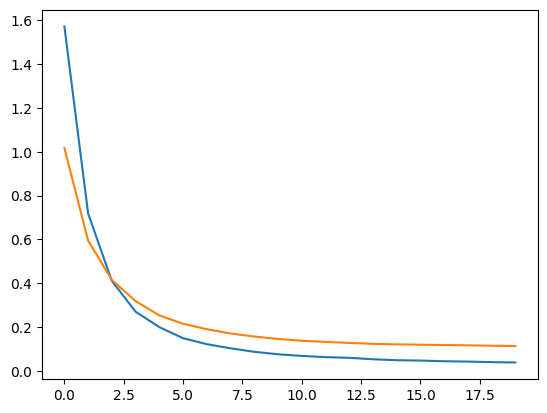

4/4 [==============================] - 0s 4ms/step


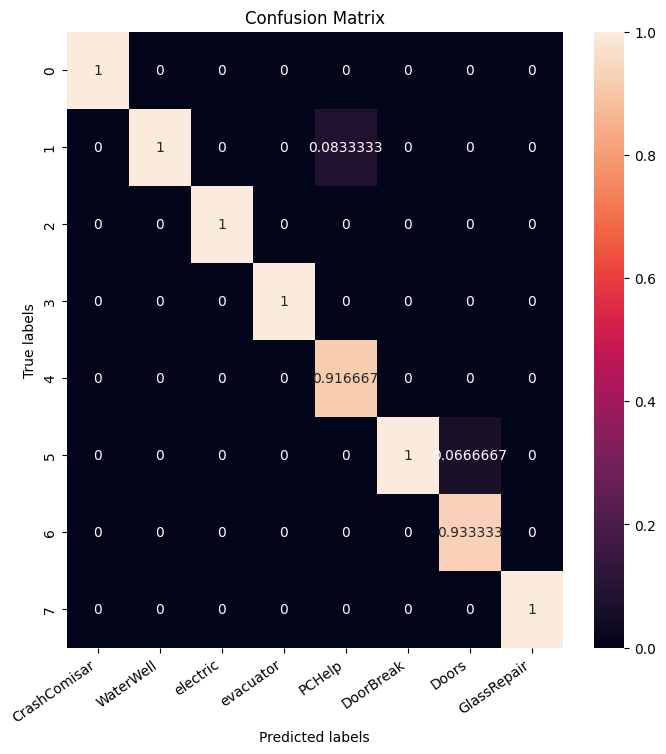

0.9812500000000001


In [23]:
  InputTrain=TrainTexts_encoded#.toarray()
  InputTest=TestTexts_encoded#.toarray()
  Model1=ModelTfIdfClass_1(InputTrain[0].shape,OutsClasses=CategoryAmount)#0.001),l2=#[0].shape
  Model1.compile(optimizer=keras.optimizers.Adam(learning_rate=0.0005),metrics=[tf.keras.metrics.Precision(name='precision')], loss="categorical_crossentropy")#categorical_crossentropy
  Model1.summary()
  WMS=WeightsFromOneOut(ClassesCountersS[:max(TrainLabels)+1])
  history1=Model1.fit(InputTrain,np.eye(CategoryAmount)[TrainLabels],validation_data=[InputTest,np.eye(CategoryAmount)[TestLabels]],batch_size=64,class_weight=WMS, epochs=20,verbose=2)
  plt.plot(history1.history["loss"])
  plt.plot(history1.history["val_loss"])
  plt.show()
  prd1=Model1.predict(InputTest)
  #prd1=(prd1-prd1.mean(axis=0))/prd1.std(axis=0)
  PlotClassificationMatrix(prd1,np.eye(CategoryAmount)[TestLabels],Captions1=Captions)

#Классификатор поверх LSI model

In [26]:
TrainTextsSplitted=[Text1.split(" ") for Text1 in TrainTexts]
TestTextsSplitted=[Text1.split(" ") for Text1 in TestTexts]
common_dictionary = gensim.corpora.dictionary.Dictionary(TrainTextsSplitted) #подаем список списков слов, формируем слова
common_corpus = [common_dictionary.doc2bow(text) for text in TrainTextsSplitted] #превращаем предложение в вектор bow
test_corpus = [common_dictionary.doc2bow(text) for text in TestTextsSplitted] #превращаем предложение в вектор bow

In [27]:
  LSI_Model=gensim.models.LsiModel(common_corpus, num_topics=40)
  LSI_out_train=[]
  LSI_out_test=[]
  for Item in common_corpus:
    arr1=np.array(LSI_Model[Item])
    Record=np.zeros(LSI_Model.num_topics)
    #print(Record.shape)
    Record[np.array(arr1[:,0],dtype=np.int16)]=arr1[:,1]
    LSI_out_train.append(Record)
    #print(Record)
  for Item in test_corpus:
    arr1=np.array(LSI_Model[Item])
    Record=np.zeros(LSI_Model.num_topics)
    #print(Record.shape)
    Record[np.array(arr1[:,0],dtype=np.int16)]=arr1[:,1]
    LSI_out_test.append(Record)
  LSI_out_train=np.array(LSI_out_train)
  LSI_out_test=np.array(LSI_out_test)

Model: "model_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_5 (InputLayer)        [(None, 40)]              0         
                                                                 
 dense_14 (Dense)            (None, 64)                2624      
                                                                 
 dropout_6 (Dropout)         (None, 64)                0         
                                                                 
 dense_15 (Dense)            (None, 32)                2080      
                                                                 
 dense_16 (Dense)            (None, 8)                 264       
                                                                 
Total params: 4,968
Trainable params: 4,968
Non-trainable params: 0
_________________________________________________________________
Epoch 1/200
10/10 - 2s - loss: 11.4801 - precision: 0.200

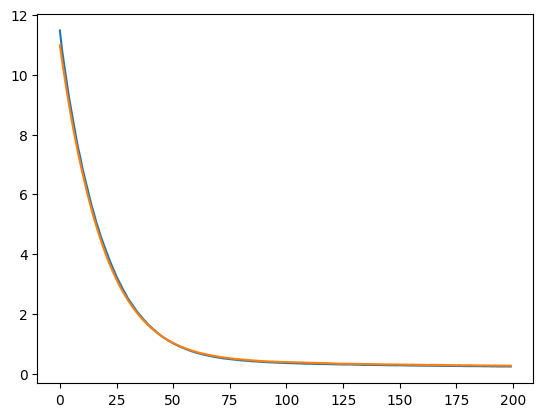

4/4 [==============================] - 0s 2ms/step


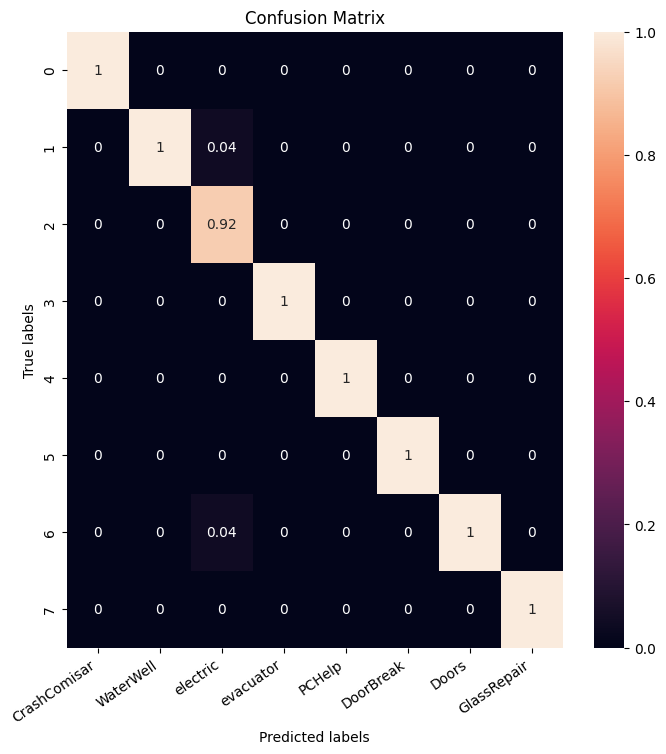

0.99
20/20 [==============================] - 0s 2ms/step


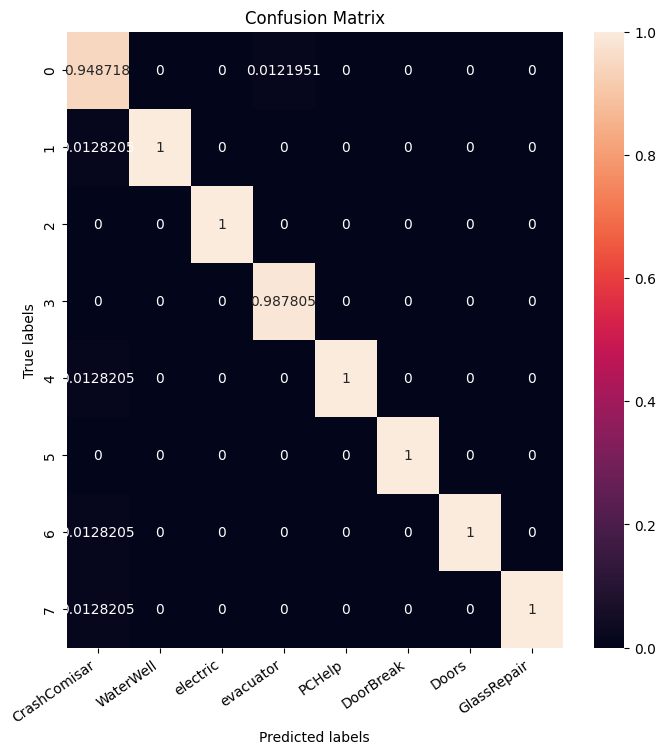

0.9920653533458412


In [30]:
#lsi
Model1=ModelTfIdfClass_0(LSI_out_train[0].shape,OutsClasses=CategoryAmount,l2=0.1)
Model1.compile(optimizer=keras.optimizers.Adam(learning_rate=0.0005),metrics=[tf.keras.metrics.Precision(name='precision')], loss="categorical_crossentropy")
Model1.summary()
history1=Model1.fit(LSI_out_train,np.eye(CategoryAmount)[TrainLabels],validation_data=[LSI_out_test,np.eye(CategoryAmount)[TestLabels]],batch_size=64,class_weight=WMS, epochs=200,verbose=2)
plt.plot(history1.history["loss"])
plt.plot(history1.history["val_loss"])
plt.show()
prd1=Model1.predict(LSI_out_test)
PlotClassificationMatrix(prd1,np.eye(CategoryAmount)[TestLabels],figsize = (8,8),Captions1=Captions)
prd1=Model1.predict(LSI_out_train)
PlotClassificationMatrix(prd1,np.eye(CategoryAmount)[TrainLabels],figsize = (8,8),Captions1=Captions)